In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import particle
import ROOT
import numpy as np
import sys
import pandas as pd
import glob
sys.path.append('/storage/gpfs_data/neutrino/users/gi/sand-physics/notebook/python_tools')
from ROOT_tools import ROOT_tools
from MultiPlotter import MultiPlotter
from ROOT2Pandas import Converter
from SampleManager import Sample, Manager
tool = ROOT_tools()

Welcome to JupyROOT 6.20/00


In [12]:
def GetLinePoints(vx, vy, vz, vtx, vty, vtz):
    x, y, z = ([] for i in range(3))
    
    # Normalize the direction vector
    norm = np.sqrt(vx**2 + vy**2 + vz**2)
    direction = np.array([vx / norm, vy / norm, vz / norm])
    
    start = np.array([vtx, vty, vtz])
    
    for i in np.arange(0, 4, 0.1):
        # Compute the point on the line at step i
        point = start + i * direction
        # Append the coordinates to the respective lists
        x.append(point[0])
        y.append(point[1])
        z.append(point[2])
    
    return {"x":x, "y":y,"z" : z}

def InteractionVolume_short(target):
    if("C3H6Target" in target):
        return "C3H6_Target"
    elif("CTarget" in target):
        return "C_Target"
    else:
        return "Other"

In [3]:
sand_center = [0, -2384.73, 23910]
sand_radius = 2000
theta = np.linspace(0, 2*np.pi, 100000)
z_sand = sand_center[2] + sand_radius * np.cos(theta)
y_sand = sand_center[1] + sand_radius * np.sin(theta)

def plotEvent(test_event, 
              tests_event_primaries, 
              test_event_fired_cells, 
              best_fired_cell):

    barrel_cells = test_event_fired_cells[test_event_fired_cells.Fired_Cells_mod < 30]
    endcap_cells = test_event_fired_cells[test_event_fired_cells.Fired_Cells_mod >= 30]

    neutron_first_hit = tests_event_primaries[tests_event_primaries.PDG==2112][['PrimariesFirstHitECAL_x','PrimariesFirstHitECAL_y','PrimariesFirstHitECAL_z']]

    neutron_true_trj = GetLinePoints(test_event['ExpectedHadronSystP3fX'].iloc[0], 
                                     test_event['ExpectedHadronSystP3fY'].iloc[0], 
                                     test_event['ExpectedHadronSystP3fZ'].iloc[0], 
                                     test_event['Interaction_vtxX'].iloc[0], 
                                     test_event['Interaction_vtxY'].iloc[0], 
                                     test_event['Interaction_vtxZ'].iloc[0]
                                     )

    fig, ax = plt.subplots(1,2,figsize=(18,8))

    ax[0].plot(z_sand, y_sand, linestyle='-', color='red', label = 'SAND')

    ax[1].vlines(sand_center[2] - sand_radius, -1650, 1650, color='red', label='SAND')
    ax[1].vlines(sand_center[2] + sand_radius, -1650, 1650, color='red')
    ax[1].hlines(-1650, sand_center[2] - sand_radius, sand_center[2] + sand_radius, color='red')
    ax[1].hlines(1650,  sand_center[2] - sand_radius, sand_center[2] + sand_radius,color='red')

    # -----------------------------------------------------------------------------------

    ax[0].scatter(x=barrel_cells['Fired_Cells_z'], 
                  y=barrel_cells['Fired_Cells_y'], 
                  label='ECAL fired cells', marker='x', color='gray')
    
    ax[0].scatter(x=endcap_cells['Fired_Cells_z'], 
                  y=endcap_cells['hit_reco_y'],
                  marker='x', color='gray')

    ax[0].scatter(x=test_event['ExpectedNeutronArrivalPositionECALfZ'], 
                  y=test_event['ExpectedNeutronArrivalPositionECALfY'], 
                  label='expected entry point')

    # ax[0].scatter(x=neutron_first_hit['PrimariesFirstHitECAL_z'], 
    #               y=neutron_first_hit['PrimariesFirstHitECAL_y'], 
    #               label='edepsim ECAL 1st hit')

    ax[0].plot(np.array(neutron_true_trj['z'])*1e3, 
               np.array(neutron_true_trj['y'])*1e3, 
               color='gray', label='expected neutron')
    
    # -----------------------------------------------------------------------------------
    
    ax[1].plot(np.array(neutron_true_trj['z'])*1e3, 
               np.array(neutron_true_trj['x'])*1e3, 
               color='gray', label='expected neutron')

    ax[1].scatter(x=barrel_cells['Fired_Cells_z'], 
                  y=barrel_cells['hit_reco_x'], 
                  label='ECAL fired cells', marker='x', color='gray')
    
    ax[1].scatter(x=endcap_cells['Fired_Cells_z'], 
                  y=endcap_cells['Fired_Cells_x'], 
                  label='ECAL fired cells', marker='x', color='gray')

    # ax[1].scatter(x=test_event['ExpectedNeutronArrivalPositionECALfZ'], 
    #               y=test_event['ExpectedNeutronArrivalPositionECALfX'], 
    #               label='expected entry point')

    ax[1].scatter(x=neutron_first_hit['PrimariesFirstHitECAL_z'], 
                  y=neutron_first_hit['PrimariesFirstHitECAL_x'], 
                  label='edepsim ECAL 1st hit')

    # -----------------------------------------------------------------------------------
        
    # if barrel it has no x coordinate -> take the one reco
    if(best_fired_cell.Fired_Cells_id.values[0] < 250000):
        ax[0].scatter(x=best_fired_cell['Fired_Cells_z'], 
                      y=best_fired_cell['Fired_Cells_y'], 
                      label='candidate cell expected neutrin hit', marker='x', color='black')
        ax[0].scatter(x=best_fired_cell['hit_reco_z'], 
                      y=best_fired_cell['hit_reco_y'], 
                      label='candidate cell reconstructed hit', marker='x', color='violet')
        
        ax[1].scatter(x=best_fired_cell['Fired_Cells_z'], 
                      y=best_fired_cell['hit_reco_x'], 
                      label='candidate cell expected neutrin hit', marker='x', color='black')
        ax[1].scatter(x=best_fired_cell['hit_reco_z'], 
                      y=best_fired_cell['hit_reco_x'], 
                      label='candidate cell reconstructed hit', marker='x', color='black')
    else:
    # if endcap it has no y coordinate -> take the one reco
        ax[0].scatter(x=best_fired_cell['Fired_Cells_z'], 
                      y=best_fired_cell['hit_reco_y'], 
                      label='candidate cell expected neutrin hit', marker='x', color='black', s=70)
        ax[0].scatter(x=best_fired_cell['hit_reco_z'], 
                      y=best_fired_cell['hit_reco_y'], 
                      label='candidate cell reconstructed hit', marker='x', color='violet', s=70)
        
        ax[1].scatter(x=best_fired_cell['Fired_Cells_z'], 
                      y=best_fired_cell['Fired_Cells_x'], 
                      label='candidate cell expected neutrin hit', marker='x', color='black', s=70)
        
        ax[1].scatter(x=best_fired_cell['hit_reco_z'], 
                      y=best_fired_cell['hit_reco_x'], 
                      label='candidate cell reconstructed hit', marker='x', color='violet', s=70)

    ax[0].legend()

In [3]:
production = glob.glob("/storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/events-in-SANDtracker.*00.to.*.ecal-digit.analysed.FV_Signal.root")
production

['/storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/events-in-SANDtracker.500.to.600.ecal-digit.analysed.FV_Signal.root',
 '/storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/events-in-SANDtracker.600.to.700.ecal-digit.analysed.FV_Signal.root',
 '/storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/events-in-SANDtracker.900.to.1000.ecal-digit.analysed.FV_Signal.root',
 '/storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/events-in-SANDtracker.100.to.200.ecal-digit.analysed.FV_Signal.root',
 '/storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/events-in-SANDtracker.300.to.400.ecal-digit.analysed.FV_Signal.root',
 '/storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/events-in-SANDtracker.800.to.900.ecal-digit.analysed.FV_Signal.root',
 '/storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/events-in-SANDtracker.700.to.800.ecal-digit.analysed.FV_Signa

In [4]:
trajectories = glob.glob("/storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/events-in-SANDtracker.*.to.*.ecal-digit.analysed.FV_Signal_trj.root")
trajectories

['/storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/events-in-SANDtracker.0.to.2.ecal-digit.analysed.FV_Signal_trj.root']

In [5]:
converter = Converter(production, "digit_extended")
# converter = Converter(['/storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/events-in-SANDtracker.0.to.100.ecal-digit.analysed.root'], "digit_extended")

In [7]:
converter_trj = Converter(trajectories, "trj_extended")

In [7]:
columns_df = ['FileName',
              'EventId',
              'EventType',
              'CCQEonHydrogen',
              'Interaction_vtxX',
              'Interaction_vtxY',
              'Interaction_vtxZ',
              'InteractionTarget',
              'InteractionVolume',
              'PrimaryStateHadronicSystemTopology_name',
              'NofFinalStateChargedParticles',
              'PrimaryStateHadronicSystemTotalKinE',
              'MissingTransverseMomentum',
              'ExpectedHadronSystP3',
            #   'ExpectedNeutronArrivalPositionECAL',
            #   'ExpectedFiredModuleByNeutron',
 ]

columns_primaries = ['FileName',
                      'EventId',
                      'EventType',
                      'CCQEonHydrogen',
                      'Interaction_vtxX',
                      'Interaction_vtxY',
                      'Interaction_vtxZ',
                      'Interaction_vtxT',
                      'PrimariesPDG',
                      'PrimariesTrackId',
                      'PrimariesP4',
                      'PrimariesBeta',
                      "ExpectedNeutron_Beta",
                      'PrimariesFirstHitECAL',
                      'PrimariesEDepECAL',
                      'PrimariesEmissionAngle',
                      'IsECALHitMissing',
                      'DeviationAngle',
                      ]

columns_fired_cells = ['FileName',
                       'CCQEonHydrogen',
                       'EventId',
                    #    'Interaction_vtxX',
                    #    'Interaction_vtxY',
                    #    'Interaction_vtxZ',
                    #    'Interaction_vtxT',
                       'Fired_Cells_mod',
                       'Fired_Cells_id',
                       'Fired_Cells_x',
                       'Fired_Cells_y',
                       'Fired_Cells_z',
                       'isCellComplete',
                       'Fired_Cells_adc1',
                       'Fired_Cells_tdc1',
                     #   'who_produced_tdc1',
                       'Fired_Cells_adc2',
                       'Fired_Cells_tdc2',
                     #   'who_produced_tdc2',
                       'Fired_Cell_true_hit1',
                       'Fired_Cell_true_hit2',
                        "Fired_by_primary_neutron",
                        "Fired_by_primary_antimu",
                        "Fired_Cell_true_Hit_x",
                        "Fired_Cell_true_Hit_y",
                        "Fired_Cell_true_Hit_z",
                        "Fired_Cell_true_Hit_t",
                        "ExpectedNeutron_HitPosition_x",
                        "ExpectedNeutron_HitPosition_y",
                        "ExpectedNeutron_HitPosition_z",
                        "ExpectedNeutron_TOF",
                        "Reconstructed_HitPosition_x",
                        "Reconstructed_HitPosition_y",
                        "Reconstructed_HitPosition_z",
                        "Reconstructed_HitTime",
                        "ExpectedNeutron_Beta",
                        "True_FlightLength",
                        "ExpectedNeutron_FlightLength",
                        "Reconstructed_FlightLength",
                        ]

columns_trj = [
     "FileName",
     "trackid",
     "pdg",
     "point_x",
     "point_y",
     "point_z",
     "point_px",
     "point_py",
     "point_pz",
     "process",
]

In [8]:
primaries = converter.CreatePandas(
    columns = columns_primaries,
    rename = True,
    indices = ['FileName', 'PrimariesTrackId']
)
primaries

DataFrame from file /storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/events-in-SANDtracker.500.to.600.ecal-digit.analysed.FV_Signal.root has MultiIndex structure, keeping entry and subentry as columns
DataFrame from file /storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/events-in-SANDtracker.600.to.700.ecal-digit.analysed.FV_Signal.root has MultiIndex structure, keeping entry and subentry as columns
DataFrame from file /storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/events-in-SANDtracker.900.to.1000.ecal-digit.analysed.FV_Signal.root has MultiIndex structure, keeping entry and subentry as columns
DataFrame from file /storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/events-in-SANDtracker.100.to.200.ecal-digit.analysed.FV_Signal.root has MultiIndex structure, keeping entry and subentry as columns
DataFrame from file /storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/events-in-S

entry  \
FileName                                           PrimariesTrackId subentry          
events-in-SANDtracker.500.gtrac.root:gRooTracker:0 0                0             0   
                                                   1                1             0   
events-in-SANDtracker.500.gtrac.root:gRooTracker:2 0                0             1   
                                                   1                1             1   
events-in-SANDtracker.500.gtrac.root:gRooTracke... 0                0             2   
...                                                                             ...   
events-in-SANDtracker.299.gtrac.root:gRooTracke... 1                1          2978   
events-in-SANDtracker.299.gtrac.root:gRooTracke... 0                0          2979   
                                                   1                1          2979   
events-in-SANDtracker.299.gtrac.root:gRooTracke... 0                0          2980   
                                                   1                1          2980   

                                                                              EventId  \
FileName                                           PrimariesTrackId subentry            
events-in-SANDtracker.500.gtrac.root:gRooTracker:0 0                0               0   
                                                   1                1               0   
events-in-SANDtracker.500.gtrac.root:gRooTracker:2 0                0               2   
                                                   1                1               2   
events-in-SANDtracker.500.gtrac.root:gRooTracke... 0                0              12   
...                                                                               ...   
events-in-SANDtracker.299.gtrac.root:gRooTracke... 1                1             907   
events-in-SANDtracker.299.gtrac.root:gRooTracke... 0                0             909   
                                                   1                1             909   
events-in-SANDtracker.299.gtrac.root:gRooTracke... 0                0             992   
                                                   1                1             992   

                                                                             EventType  \
FileName                                           PrimariesTrackId subentry             
events-in-SANDtracker.500.gtrac.root:gRooTracker:0 0                0              QES   
                                                   1                1              QES   
events-in-SANDtracker.500.gtrac.root:gRooTracker:2 0                0              QES   
                                                   1                1              QES   
events-in-SANDtracker.500.gtrac.root:gRooTracke... 0                0              QES   
...                                                                                ...   
events-in-SANDtracker.299.gtrac.root:gRooTracke... 1                1              QES   
events-in-SANDtracker.299.gtrac.root:gRooTracke... 0                0              QES   
                                                   1                1              QES   
events-in-SANDtracker.299.gtrac.root:gRooTracke... 0                0              QES   
                                                   1                1              QES   

                                                                              CCQEonHydrogen  \
FileName                                           PrimariesTrackId subentry                   
events-in-SANDtracker.500.gtrac.root:gRooTracker:0 0                0                      1   
                                                   1                1                      1   
events-in-SANDtracker.500.gtrac.root:gRooTracker:2 0                0                      1   
                                                   1                1                      1   
events-in-SANDtracker.500.gtrac.root:gRoo

In [9]:
df = converter.CreatePandas(
    columns = columns_df,
    rename = False,
    indices = ['FileName']
)
df

,EventId,EventType,CCQEonHydrogen,Interaction_vtxX,Interaction_vtxY,Interaction_vtxZ,InteractionTarget,InteractionVolume,PrimaryStateHadronicSystemTopology_name,NofFinalStateChargedParticles,PrimaryStateHadronicSystemTotalKinE,MissingTransverseMomentum,ExpectedHadronSystP3fX,ExpectedHadronSystP3fY,ExpectedHadronSystP3fZ
FileName,,,,,,,,,,,,,,,
events-in-SANDtracker.500.gtrac.root:gRooTracker:0,0,QES,1,-1.372439,-1.825586,25.512934,proton,C3H6Target_X0,n,1,0.149875,2.830524e-16,-0.215052,-0.448220,0.238649
events-in-SANDtracker.500.gtrac.root:gRooTracker:2,2,QES,1,-0.076146,-1.288528,24.125909,proton,C3H6Target_A,n,1,0.423082,1.241267e-16,0.768120,0.130218,0.605863
events-in-SANDtracker.500.gtrac.root:gRooTracker:12,12,QES,1,-0.781087,-2.318788,24.419031,proton,C3H6Target_B,n,1,0.012243,1.665335e-16,-0.110591,0.095420,0.042674
events-in-SANDtracker.500.gtrac.root:gRooTracker:60,60,QES,1,0.599413,-3.189680,23.137297,proton,C3H6Target_C,n,1,0.039801,3.608225e-16,-0.070370,-0.265643,0.029288
events-in-SANDtracker.500.gtrac.root:gRooTracker:117,117,QES,1,-0.197648,-1.654291,25.320174,proton,C3H6Target_X1,n,1,0.964693,4.603265e-16,-0.867326,-0.164572,1.401472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
events-in-SANDtracker.299.gtrac.root:gRooTracker:834,834,QES,1,-0.073800,-2.040878,23.792162,proton,C3H6Target_A,n,1,0.018203,6.557622e-16,0.036706,0.176218,0.046237
events-in-SANDtracker.299.gtrac.root:gRooTracker:904,904,QES,1,-0.784508,-1.999611,23.757667,proton,C3H6Target_A,n,1,0.011452,4.493773e-16,0.145669,0.000295,0.020761
events-in-SANDtracker.299.gtrac.root:gRooTracker:907,907,QES,1,0.039275,-1.605666,25.250590,proton,C3H6Target_X1,n,1,0.027492,2.221530e-16,0.116364,-0.192021,0.044776


In [13]:
fired_cells = converter.CreatePandas(
    columns = columns_fired_cells,
    rename = True,
    indices = ['FileName','Fired_Cells_id']
)
fired_cells

DataFrame from file /storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/events-in-SANDtracker.500.to.600.ecal-digit.analysed.FV_Signal.root has MultiIndex structure, keeping entry and subentry as columns
DataFrame from file /storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/events-in-SANDtracker.600.to.700.ecal-digit.analysed.FV_Signal.root has MultiIndex structure, keeping entry and subentry as columns
DataFrame from file /storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/events-in-SANDtracker.900.to.1000.ecal-digit.analysed.FV_Signal.root has MultiIndex structure, keeping entry and subentry as columns
DataFrame from file /storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/events-in-SANDtracker.100.to.200.ecal-digit.analysed.FV_Signal.root has MultiIndex structure, keeping entry and subentry as columns
DataFrame from file /storage/gpfs_data/neutrino/users/gi/sand-physics/production_antinumucc/events-in-S

entry  \
FileName                                           Fired_Cells_id subentry          
events-in-SANDtracker.500.gtrac.root:gRooTracker:0 219009         0             0   
                                                   219109         1             0   
                                                   219110         2             0   
                                                   219210         3             0   
                                                   219310         4             0   
...                                                                           ...   
events-in-SANDtracker.208.gtrac.root:gRooTracke... 216011         0           262   
                                                   216111         1           262   
                                                   216211         2           262   
                                                   217300         3           262   
                                                   217400         4           262   

                                                                            CCQEonHydrogen  \
FileName                                           Fired_Cells_id subentry                   
events-in-SANDtracker.500.gtrac.root:gRooTracker:0 219009         0                      1   
                                                   219109         1                      1   
                                                   219110         2                      1   
                                                   219210         3                      1   
                                                   219310         4                      1   
...                                                                                    ...   
events-in-SANDtracker.208.gtrac.root:gRooTracke... 216011         0                      1   
                                                   216111         1                      1   
                                                   216211         2                      1   
                                                   217300         3                      1   
                                                   217400         4                      1   

                                                                            EventId  \
FileName                                           Fired_Cells_id subentry            
events-in-SANDtracker.500.gtrac.root:gRooTracker:0 219009         0               0   
                                                   219109         1               0   
                                                   219110         2               0   
                                                   219210         3               0   
                                                   219310         4               0   
...                                                                             ...   
events-in-SANDtracker.208.gtrac.root:gRooTracke... 216011         0             993   
                                                   216111         1             993   
                                                   216211         2             993   
                                                   217300         3             993   
                                                   217400         4             993   

                                                                            Fired_Cells_mod  \
FileName                                           Fired_Cells_id subentry                    
events-in-SANDtracker.500.gtrac.root:gRooTracker:0 219009         0                      19   
                                                   219109         1                      19   
                                                   219110         2                      19   
                                                   219210         3                      19   
                                             

In [15]:
df["InteractionVolume_short"] = df.apply(lambda row: InteractionVolume_short(row['InteractionVolume']), axis=1)

In [16]:
primaries['HasChangedDirection'] = primaries.apply(
    lambda row: 1 if abs(row['DeviationAngle']) < 0.01 else (np.nan if row['DeviationAngle'] == -999 else 0),
    axis=1
)

In [17]:
df_manager = Manager(df, "df", reference_index="FileName")
primaries_manager = Manager(primaries, "primaries", reference_index="FileName")
fired_cells_manager = Manager(fired_cells, "fired_cells", reference_index="FileName")

# Samples

In [25]:
df_manager.DefineSample("signal", "CCQEonHydrogen==1")

primaries_manager.DefineSample("signal",                              "CCQEonHydrogen==1")
primaries_manager.DefineSample("signal_mu+",                          "CCQEonHydrogen==1 & PrimariesPDG==-13")
primaries_manager.DefineSample("signal_neutrons",                     "CCQEonHydrogen==1 & PrimariesPDG==2112")
primaries_manager.DefineSample("signal_neutrons_w_hits",              "CCQEonHydrogen==1 & PrimariesPDG==2112 & IsECALHitMissing == 0")
primaries_manager.DefineSample("signal_neutrons_no_direction_change", "CCQEonHydrogen==1 & PrimariesPDG==2112 & HasChangedDirection == 0")
primaries_manager.DefineSample("signal_neutrons_w_direction_change",  "CCQEonHydrogen==1 & PrimariesPDG==2112 & HasChangedDirection == 1")
primaries_manager.DefineSample("signal_neutrons_reconstructable",     "CCQEonHydrogen==1 & PrimariesPDG==2112 & HasChangedDirection == 0 & IsECALHitMissing == 0")


fired_cells_manager.DefineSample("complete_fired",                    "isCellComplete==1")
fired_cells_manager.DefineSample("complete_fired_by_neutron",         "isCellComplete==1 & Fired_by_primary_neutron==1")
fired_cells_manager.DefineSample("complete_fired_by_antimu",          "isCellComplete==1 & Fired_by_primary_antimu==1")

primaries_manager.CombineSamples("signal_neutrons_reconstructable", 
                                 fired_cells_manager,
                                 "complete_fired_by_neutron",
                                 "signal_neutrons_reconstructable_complete")

primaries_manager.CombineSamples("signal_mu+",
                                 fired_cells_manager,
                                 "complete_fired_by_antimu",
                                 "signal_antimu_complete")

fired_cells_manager.CombineSamples("complete_fired_by_neutron",
                                   primaries_manager,
                                   "signal_neutrons_reconstructable",
                                   "fired_by_reconstructable_neutron")

fired_cells_manager.CombineSamples("complete_fired_by_antimu",
                                   primaries_manager,
                                   "signal_antimu_complete",
                                   "fired_by_antimuon")

In [23]:
signal_antimuons = primaries_manager.GetSample("signal_mu+")
signal_antimuons_complete = primaries_manager.GetSample("signal_antimu_complete")

signal_neutrons = primaries_manager.GetSample("signal_neutrons")
signal_neutrons_no_direction_change = primaries_manager.GetSample("signal_neutrons_no_direction_change")
signal_neutrons_w_hits = primaries_manager.GetSample("signal_neutrons_w_hits")
signal_neutrons_reconstructable = primaries_manager.GetSample("signal_neutrons_reconstructable")
signal_neutrons_reconstructable_complete = primaries_manager.GetSample("signal_neutrons_reconstructable_complete")

neutron_mass = 939.565 # MeV
signal_neutrons.dataframe['E_kin'] = signal_neutrons.dataframe.PrimariesP4_t - neutron_mass

complete_cells = fired_cells_manager.GetSample("complete_fired")
fired_by_reconstructable_neutron = fired_cells_manager.GetSample("fired_by_reconstructable_neutron")
fired_by_antimuons = fired_cells_manager.GetSample("fired_by_antimuon")

/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [46]:
print(f'total number of events in fiducial volume {len(df)}, CCQE {df_manager.GetSample("signal").size()/len(df)*1e2} [%]')
print(f'total simulated neutrons from signal {signal_neutrons.size()}')
print(f'with no directions before ECAL {signal_neutrons_no_direction_change.size()}, {signal_neutrons_no_direction_change.size()/signal_neutrons.size() * 1e2} [%]')
print(f'... and at least 1 hit in ECAL {signal_neutrons_reconstructable.size()}, {signal_neutrons_reconstructable.size()/signal_neutrons.size() * 1e2} [%]')
print(f'... that produce complete cells {signal_neutrons_reconstructable_complete.size()}, {signal_neutrons_reconstructable_complete.size()/signal_neutrons.size() * 1e2} [%]')

total number of events in fiducial volume 26129, CCQE 100.0 [%]
total simulated neutrons from signal 26129
with no directions before ECAL 15076, 57.698342837460295 [%]
... and at least 1 hit in ECAL 15076, 57.698342837460295 [%]
... that produce complete cells 11667, 44.65153660683532 [%]


In [31]:
signal_neutrons.dataframe

,,,entry,EventId,EventType,CCQEonHydrogen,Interaction_vtxX,Interaction_vtxY,Interaction_vtxZ,Interaction_vtxT,PrimariesPDG,PrimariesP4_x,...,PrimariesFirstHitECAL_x,PrimariesFirstHitECAL_y,PrimariesFirstHitECAL_z,PrimariesFirstHitECAL_t,PrimariesEDepECAL,PrimariesEmissionAngle,IsECALHitMissing,DeviationAngle,HasChangedDirection,E_kin
FileName,PrimariesTrackId,subentry,,,,,,,,,,,,,,,,,,,,,
events-in-SANDtracker.500.gtrac.root:gRooTracker:0,1,1,0,0,QES,1,-1.372439,-1.825586,25.512934,1.010049e-08,2112,-215.052248,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.032232,1,-9.990000e+02,NaN,149.875448
events-in-SANDtracker.500.gtrac.root:gRooTracker:2,1,1,1,2,QES,1,-0.076146,-1.288528,24.125909,5.449644e-09,2112,768.120412,...,1618.355400,-994.580864,25463.889947,11.047913,76.210463,0.930951,0,3.030055e-03,1.0,423.082230
events-in-SANDtracker.500.gtrac.root:gRooTracker:12,1,1,2,12,QES,1,-0.781087,-2.318788,24.419031,6.432801e-09,2112,-110.590551,...,-1753.944249,-1479.382410,24794.369726,28.929744,0.633799,1.351825,0,3.551357e-07,1.0,12.243187
events-in-SANDtracker.500.gtrac.root:gRooTracker:60,1,1,3,60,QES,1,0.599413,-3.189680,23.137297,2.136878e-09,2112,-70.369959,...,283.597271,-4379.378651,23265.135975,16.061873,10.614438,1.366670,0,2.714076e-03,1.0,39.801351
events-in-SANDtracker.500.gtrac.root:gRooTracker:117,1,1,4,117,QES,1,-0.197648,-1.654291,25.320174,9.452714e-09,2112,-867.326396,...,-1914.020232,-1698.500363,26030.828809,12.128058,5.111941,0.551227,0,6.272693e-01,0.0,964.693202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
events-in-SANDtracker.299.gtrac.root:gRooTracker:834,1,1,2976,834,QES,1,-0.073800,-2.040878,23.792162,4.331500e-09,2112,36.706298,...,858.910466,-432.995449,24503.538978,41.594206,0.441386,1.416963,0,3.254883e-01,0.0,18.203612
events-in-SANDtracker.299.gtrac.root:gRooTracker:904,1,1,2977,904,QES,1,-0.784508,-1.999611,23.757667,4.216383e-09,2112,145.669223,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.434463,1,-9.990000e+02,NaN,11.452036
events-in-SANDtracker.299.gtrac.root:gRooTracker:907,1,1,2978,907,QES,1,0.039275,-1.605666,25.250590,9.217316e-09,2112,116.363673,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.293374,1,-9.990000e+02,NaN,27.492312


In [40]:
complete_cells_fired_by_neutron = complete_cells.dataframe.query("Fired_by_primary_neutron==1")

In [63]:
complete_cells_fired_by_neutron

entry  \
FileName                                           Fired_Cells_id subentry          
events-in-SANDtracker.500.gtrac.root:gRooTracker:2 220111         3             1   
                                                   221002         8             1   
                                                   221004         10            1   
                                                   221007         11            1   
                                                   221009         12            1   
...                                                                           ...   
events-in-SANDtracker.208.gtrac.root:gRooTracke... 212007         0           258   
                                                   212108         2           258   
events-in-SANDtracker.208.gtrac.root:gRooTracke... 200002         0           259   
                                                   200003         1           259   
events-in-SANDtracker.208.gtrac.root:gRooTracke... 220410         7           261   

                                                                            CCQEonHydrogen  \
FileName                                           Fired_Cells_id subentry                   
events-in-SANDtracker.500.gtrac.root:gRooTracker:2 220111         3                      1   
                                                   221002         8                      1   
                                                   221004         10                     1   
                                                   221007         11                     1   
                                                   221009         12                     1   
...                                                                                    ...   
events-in-SANDtracker.208.gtrac.root:gRooTracke... 212007         0                      1   
                                                   212108         2                      1   
events-in-SANDtracker.208.gtrac.root:gRooTracke... 200002         0                      1   
                                                   200003         1                      1   
events-in-SANDtracker.208.gtrac.root:gRooTracke... 220410         7                      1   

                                                                            EventId  \
FileName                                           Fired_Cells_id subentry            
events-in-SANDtracker.500.gtrac.root:gRooTracker:2 220111         3               2   
                                                   221002         8               2   
                                                   221004         10              2   
                                                   221007         11              2   
                                                   221009         12              2   
...                                                                             ...   
events-in-SANDtracker.208.gtrac.root:gRooTracke... 212007         0             808   
                                                   212108         2             808   
events-in-SANDtracker.208.gtrac.root:gRooTracke... 200002         0             893   
                                                   200003         1             893   
events-in-SANDtracker.208.gtrac.root:gRooTracke... 220410         7             953   

                                                                            Fired_Cells_mod  \
FileName                                           Fired_Cells_id subentry                    
events-in-SANDtracker.500.gtrac.root:gRooTracker:2 220111         3                      20   
                                                   221002         8                      21   
                                                   221004         10                     21   
                                                   221007         11                     21   
                                             

In [51]:
complete_cells_fired_by_neutron.columns

Index(['entry', 'CCQEonHydrogen', 'EventId', 'Fired_Cells_mod',
       'Fired_Cells_x', 'Fired_Cells_y', 'Fired_Cells_z', 'isCellComplete',
       'Fired_Cells_adc1', 'Fired_Cells_tdc1', 'Fired_Cells_adc2',
       'Fired_Cells_tdc2', 'Fired_Cell_true_hit1_x', 'Fired_Cell_true_hit1_y',
       'Fired_Cell_true_hit1_z', 'Fired_Cell_true_hit1_t',
       'Fired_Cell_true_hit2_x', 'Fired_Cell_true_hit2_y',
       'Fired_Cell_true_hit2_z', 'Fired_Cell_true_hit2_t',
       'Fired_by_primary_neutron', 'Fired_by_primary_antimu',
       'Fired_Cell_true_Hit_x', 'Fired_Cell_true_Hit_y',
       'Fired_Cell_true_Hit_z', 'Fired_Cell_true_Hit_t',
       'ExpectedNeutron_HitPosition_x', 'ExpectedNeutron_HitPosition_y',
       'ExpectedNeutron_HitPosition_z', 'ExpectedNeutron_TOF',
       'Reconstructed_HitPosition_x', 'Reconstructed_HitPosition_y',
       'Reconstructed_HitPosition_z', 'Reconstructed_HitTime',
       'ExpectedNeutron_Beta', 'True_FlightLength',
       'ExpectedNeutron_FlightLength', 'R

In [67]:
min_indices = complete_cells_fired_by_neutron.groupby('FileName')['Fired_Cell_true_Hit_t'].idxmin()

# Seleziona le righe corrispondenti agli indici trovati
first_complete_cells_fired_by_neutron = complete_cells_fired_by_neutron.loc[min_indices]

first_complete_cells_fired_by_neutron

,,,entry,CCQEonHydrogen,EventId,Fired_Cells_mod,Fired_Cells_x,Fired_Cells_y,Fired_Cells_z,isCellComplete,Fired_Cells_adc1,Fired_Cells_tdc1,...,ExpectedNeutron_TOF,Reconstructed_HitPosition_x,Reconstructed_HitPosition_y,Reconstructed_HitPosition_z,Reconstructed_HitTime,ExpectedNeutron_Beta,True_FlightLength,ExpectedNeutron_FlightLength,Reconstructed_FlightLength,t_hit_residulas_exp
FileName,Fired_Cells_id,subentry,,,,,,,,,,,,,,,,,,,,,
events-in-SANDtracker.100.gtrac.root:gRooTracker:139,212311,5,3,1,139,12,-4.696243e-13,-4538.730000,24169.268007,1,32.0,29.616877,...,10.238274,-785.633344,-4538.730000,24169.268007,12.443422,0.612587,1664.739708,1880.246149,1632.209449,1.908880
events-in-SANDtracker.100.gtrac.root:gRooTracker:173,330416,10,4,1,173,30,1.893000e+03,-2384.730000,25176.666667,1,16.0,69.691463,...,42.366580,1893.000000,-1881.689170,25176.666667,63.653272,0.350142,2535.035904,4447.213128,2530.783122,20.203023
events-in-SANDtracker.100.gtrac.root:gRooTracker:192,330126,11,6,1,192,30,1.756000e+03,-2384.730000,24732.222222,1,456.0,29.633895,...,0.693640,1756.000000,-1579.817225,24732.222222,23.620952,0.705664,3254.904086,146.741207,3267.135785,21.886832
events-in-SANDtracker.100.gtrac.root:gRooTracker:322,220111,9,10,1,322,20,2.348122e-13,-1136.400534,25574.887959,1,28.0,75.223206,...,33.634982,-1133.090177,-1136.400534,25574.887959,56.017128,0.404142,3077.509190,4075.167090,3071.922966,20.117350
events-in-SANDtracker.100.gtrac.root:gRooTracker:356,213004,3,11,1,356,13,-4.536223e-13,-4355.007787,24369.231277,1,268.0,26.061872,...,6.629633,-793.652160,-4355.007787,24369.231277,8.841507,0.633354,1274.771627,1258.797673,1272.383830,1.133285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
events-in-SANDtracker.915.gtrac.root:gRooTracker:658,212300,1,469,1,658,12,-4.696243e-13,-4538.730000,23650.731993,1,120.0,52.342132,...,128.092484,856.941209,-4538.730000,23650.731993,44.777738,0.118848,1297.695098,4563.892811,1287.243118,-83.598243
events-in-SANDtracker.915.gtrac.root:gRooTracker:677,330024,6,470,1,677,30,1.712000e+03,-2384.730000,24821.111111,1,12.0,56.662839,...,67.105094,1712.000000,-2594.212127,24821.111111,45.052489,0.194653,2169.522253,3915.951557,2098.587627,-24.376928
events-in-SANDtracker.915.gtrac.root:gRooTracker:715,140444,13,471,1,715,40,-1.893000e+03,-2384.730000,23887.777778,1,28.0,30.397284,...,2.589633,-1893.000000,-4101.141137,23887.777778,8.659054,0.624538,523.455433,484.861113,557.008416,1.711560


In [86]:
complete_cells_fired_by_neutron['t_hit_residulas_exp'] = complete_cells_fired_by_neutron['Fired_Cell_true_Hit_t'] - complete_cells_fired_by_neutron['ExpectedNeutron_TOF']
fired_by_reconstructable_neutron.dataframe['t_hit_residulas_exp'] = fired_by_reconstructable_neutron.dataframe['Fired_Cell_true_Hit_t'] - fired_by_reconstructable_neutron.dataframe['ExpectedNeutron_TOF']

/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [88]:
# min_indices = complete_cells_fired_by_neutron.groupby('FileName')['t_hit_residulas_exp'].idxmin()
min_indices = fired_by_reconstructable_neutron.dataframe.groupby('FileName')['t_hit_residulas_exp'].idxmin()

# Seleziona le righe corrispondenti agli indici trovati
first_complete_cells_fired_by_neutron = fired_by_reconstructable_neutron.dataframe.loc[min_indices]

first_complete_cells_fired_by_neutron

,,,entry,CCQEonHydrogen,EventId,Fired_Cells_mod,Fired_Cells_x,Fired_Cells_y,Fired_Cells_z,isCellComplete,Fired_Cells_adc1,Fired_Cells_tdc1,...,ExpectedNeutron_TOF,Reconstructed_HitPosition_x,Reconstructed_HitPosition_y,Reconstructed_HitPosition_z,Reconstructed_HitTime,ExpectedNeutron_Beta,True_FlightLength,ExpectedNeutron_FlightLength,Reconstructed_FlightLength,t_hit_residulas_exp
FileName,Fired_Cells_id,subentry,,,,,,,,,,,,,,,,,,,,,
events-in-SANDtracker.100.gtrac.root:gRooTracker:139,212311,5,3,1,139,12,-4.696243e-13,-4538.730000,24169.268007,1,32.0,29.616877,...,10.238274,-785.633344,-4538.730000,24169.268007,12.443422,0.612587,1664.739708,1880.246149,1632.209449,1.908880
events-in-SANDtracker.100.gtrac.root:gRooTracker:173,330416,10,4,1,173,30,1.893000e+03,-2384.730000,25176.666667,1,16.0,69.691463,...,42.366580,1893.000000,-1881.689170,25176.666667,63.653272,0.350142,2535.035904,4447.213128,2530.783122,20.203023
events-in-SANDtracker.100.gtrac.root:gRooTracker:192,217110,10,6,1,192,17,-1.215477e-13,-2722.948392,25958.255244,1,12.0,32.347458,...,9.155840,904.384236,-2722.948392,25958.255244,25.060605,0.705664,2271.718626,1936.939968,2280.066434,15.622049
events-in-SANDtracker.100.gtrac.root:gRooTracker:322,220111,9,10,1,322,20,2.348122e-13,-1136.400534,25574.887959,1,28.0,75.223206,...,33.634982,-1133.090177,-1136.400534,25574.887959,56.017128,0.404142,3077.509190,4075.167090,3071.922966,20.117350
events-in-SANDtracker.100.gtrac.root:gRooTracker:356,213004,3,11,1,356,13,-4.536223e-13,-4355.007787,24369.231277,1,268.0,26.061872,...,6.629633,-793.652160,-4355.007787,24369.231277,8.841507,0.633354,1274.771627,1258.797673,1272.383830,1.133285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
events-in-SANDtracker.915.gtrac.root:gRooTracker:658,212300,1,469,1,658,12,-4.696243e-13,-4538.730000,23650.731993,1,120.0,52.342132,...,128.092484,856.941209,-4538.730000,23650.731993,44.777738,0.118848,1297.695098,4563.892811,1287.243118,-83.598243
events-in-SANDtracker.915.gtrac.root:gRooTracker:677,330423,8,470,1,677,30,1.893000e+03,-2384.730000,24865.555556,1,44.0,59.755400,...,71.859241,1893.000000,-2809.410222,24865.555556,46.944395,0.194653,2334.298867,4193.382227,2324.815665,-25.475991
events-in-SANDtracker.915.gtrac.root:gRooTracker:715,140444,13,471,1,715,40,-1.893000e+03,-2384.730000,23887.777778,1,28.0,30.397284,...,2.589633,-1893.000000,-4101.141137,23887.777778,8.659054,0.624538,523.455433,484.861113,557.008416,1.711560


In [48]:
all_hists = []

Neutron True Kinetic energy and tof (signal event)


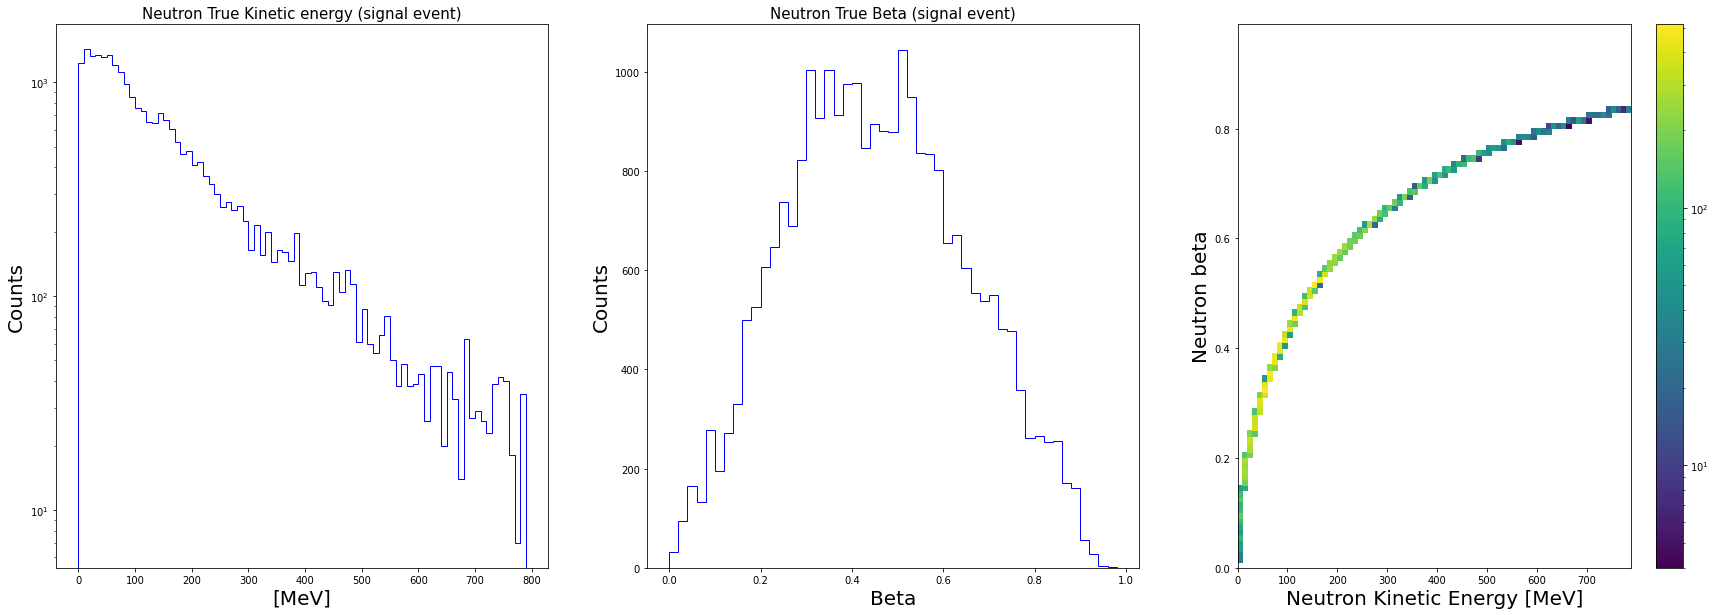

In [47]:
print("Neutron True Kinetic energy and tof (signal event)")
plotter = MultiPlotter(nrows=1, ncols=3, figsize=(30, 10))
# First histogram: Neutron True Kinetic Energy
plotter.plot_hist(
    data = signal_neutrons.dataframe['E_kin'],
    bins = np.arange(0, 800, 10),
    color = 'blue',
    xlabel = "[MeV]",
    ylabel = "Counts",
    log_scale = True
)
plotter.axes[0].set_title("Neutron True Kinetic energy (signal event)", fontsize=15)
plotter.next_plot()

# Second histogram: Neutron True Beta
plotter.plot_hist(
    data = signal_neutrons.dataframe['PrimariesBeta'],
    bins = np.arange(0, 1, 0.02),
    color = 'blue',
    xlabel = "Beta",
    ylabel = "Counts"
)
plotter.axes[1].set_title("Neutron True Beta (signal event)", fontsize=15)

plotter.next_plot()

plotter.plot_hist2d(
    x = signal_neutrons.dataframe['E_kin'],
    y = signal_neutrons.dataframe['PrimariesBeta'],
    bins_x = np.arange(0, 800, 10),
    bins_y = np.arange(0, 1, 0.01),
    xlabel = "Neutron Kinetic Energy [MeV]",
    ylabel = "Neutron beta",
    log_scale = True
)

all_hists.append(plotter)

Neutron angle of deviation wrt initial direction


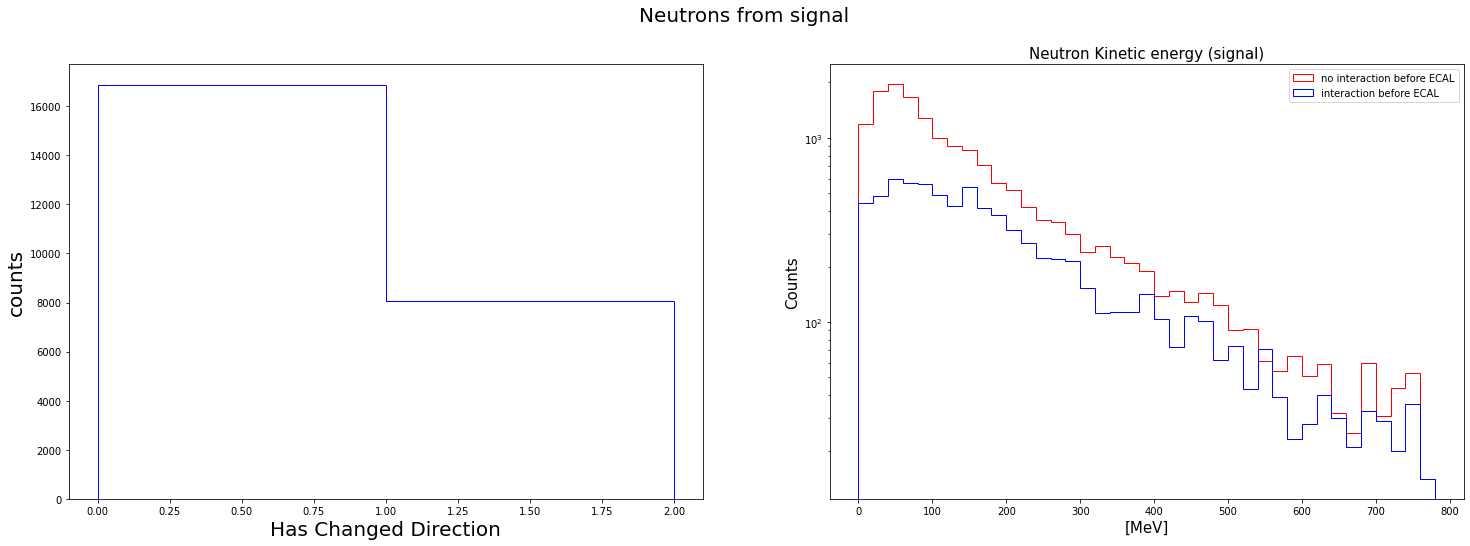

In [23]:
print("Neutron angle of deviation wrt initial direction")
plotter = MultiPlotter(nrows=1, ncols=2, figsize=(25, 8), suptitle = "Neutrons from signal")

plotter.plot_hist(
    data = signal_neutrons.dataframe["HasChangedDirection"],
    bins = [0,1,2],
    color = 'blue',
    xlabel = 'Has Changed Direction',
    ylabel = "counts",
)


plotter.next_plot()

plotter.plot_hist(
    data = primaries_manager.GetSample("signal_neutrons_no_direction_change").dataframe["E_kin"],
    bins = np.arange(0, 800, 20),
    color = 'red',
    label = 'no interaction before ECAL',
)

plotter.plot_hist(
    data = primaries_manager.GetSample("signal_neutrons_w_direction_change").dataframe["E_kin"],
    bins = np.arange(0, 800, 20),
    color = 'blue',
    label = 'interaction before ECAL',
)

plotter.axes[1].set_yscale("log")
plotter.axes[1].set_title("Neutron Kinetic energy (signal)", fontsize=15)
plotter.set_labels(xlabel="[MeV]", ylabel="Counts", fontsize=15)

plotter.next_plot(plot_legend=True)

all_hists.append(plotter)

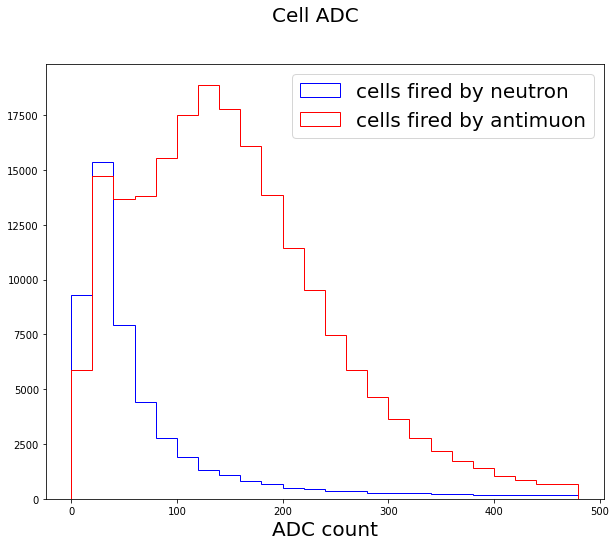

In [66]:
plotter = MultiPlotter(nrows=1, ncols=1, figsize=(10, 8), suptitle = "Cell ADC")

plotter.plot_hist(
    data = fired_by_reconstructable_neutron.dataframe['Fired_Cells_adc1'],
    bins = np.arange(0, 500, 20),
    color = 'blue',
    label = 'cells fired by neutron',
)

plotter.plot_hist(
    data = fired_by_antimuons.dataframe['Fired_Cells_adc1'],
    bins = np.arange(0, 500, 20),
    color = 'red',
    label = 'cells fired by antimuon',
    xlabel = 'ADC count'
)
plotter.axes[plotter.current_ax].legend(fontsize=20)
# plotter.next_plot(legend=True)

all_hists.append(plotter)

KeyError: 'E_kin'

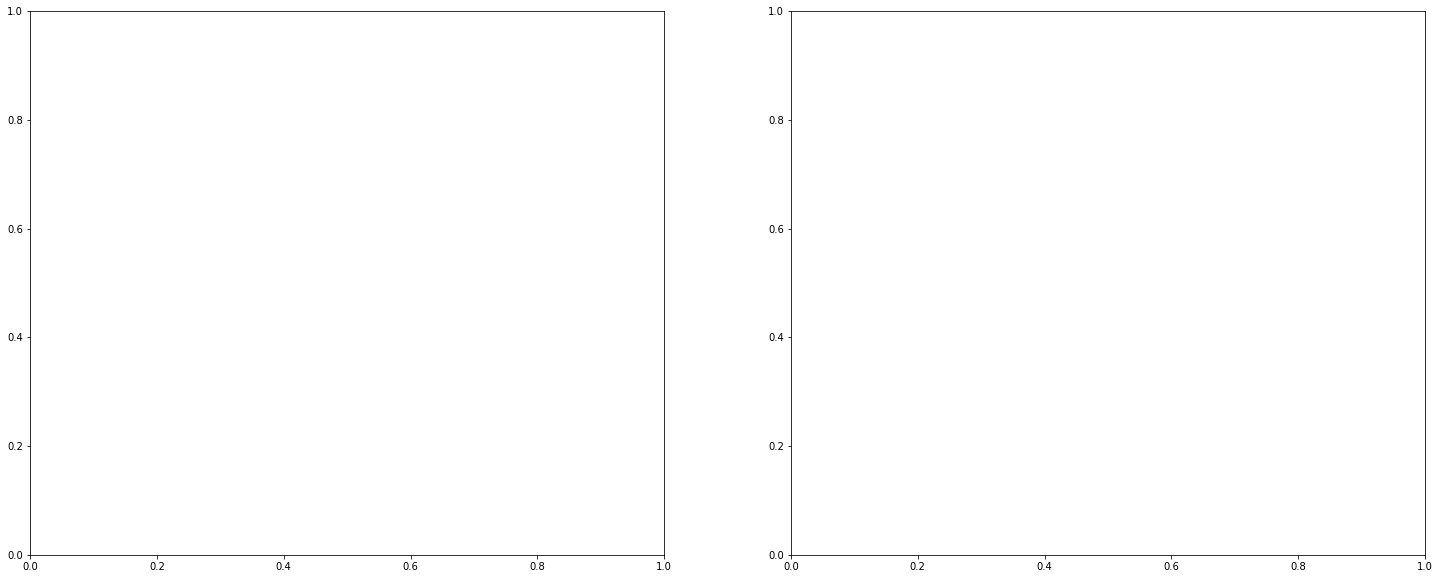

In [20]:
plotter = MultiPlotter(nrows=1, ncols=2, figsize=(25, 10), )

plotter.plot_hist2d(
    x = fired_by_reconstructable_neutron.AddInfo(signal_neutrons_reconstructable_complete, 'E_kin'),
    y = fired_by_reconstructable_neutron.dataframe['Fired_Cells_adc1'] + fired_by_reconstructable_neutron.dataframe['Fired_Cells_adc2'],
    bins_x = np.arange(0, 500, 10),
    bins_y = np.arange(0, 200, 5),
    xlabel = "Neutron Kinetic Energy [MeV]",
    ylabel = "ADC1 + ADC2 count on cell PMTs",
    log_scale = True
)

plotter.next_plot()

plotter.plot_hist2d(
    x = fired_by_reconstructable_neutron.AddInfo(signal_neutrons_reconstructable_complete, 'E_kin'),
    y = fired_by_reconstructable_neutron.AddInfo(signal_neutrons_reconstructable_complete, 'PrimariesEDepECAL'),
    bins_x = np.arange(0, 500, 10),
    bins_y = np.arange(0, 100, 2.5),
    xlabel = "Neutron Kinetic Energy [MeV]",
    ylabel = "Energy Deposit in Cell Fibers (edepsim) [MeV]",
    log_scale = True
)

all_hists.append(plotter)

plt.savefig("/storage/gpfs_data/neutrino/users/gi/sand-physics/notebook/figures/ECAL_reco/general_kin_info_neutrons.pdf")

 FCN=47.2456 FROM MIGRAD    STATUS=CONVERGED      65 CALLS          66 TOTAL
                     EDM=1.05456e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.46343e+02   7.34393e+00   1.80299e-02  -6.52062e-05
   2  Mean        -1.67186e+00   4.91982e-01   1.66428e-03   1.75084e-03
   3  Sigma        2.66658e+01   5.61766e-01   1.89927e-05   1.08231e-01
 FCN=47.2456 FROM MIGRAD    STATUS=CONVERGED      65 CALLS          66 TOTAL
                     EDM=1.05456e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.46343e+02   7.34393e+00   1.80299e-02  -6.52062e-05
   2  Mean        -1.67186e+00   4.91982e-01   1.66428e-03   1.75084e-03
   3  Sigma        2.66658e+01   

Warning in <TROOT::Append>: Replacing existing TH1:  time:1727188439 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas_name


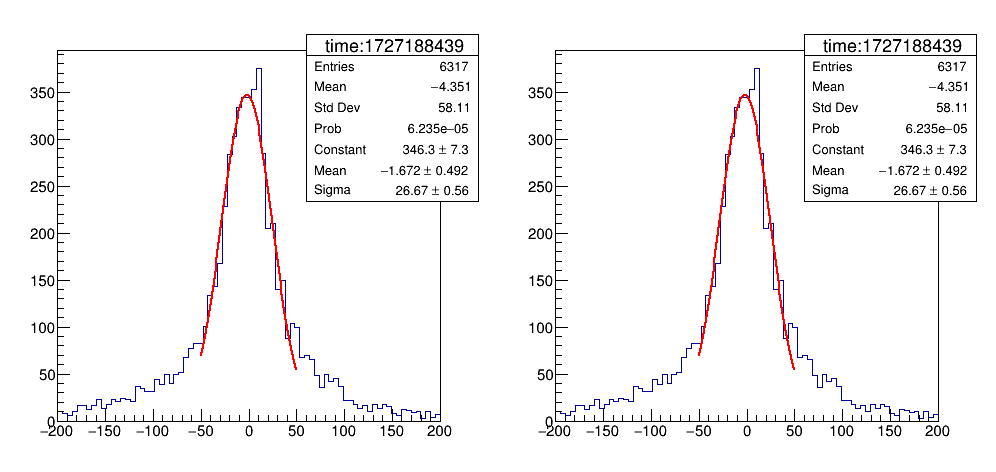

In [21]:
residuals_x = tool.FillTH1D(iterable = fired_by_reconstructable_neutron.dataframe['True_FlightLength'] - fired_by_reconstructable_neutron.dataframe['Reconstructed_FlightLength'], 
                          histogram_name = "", 
                          title = "", 
                          nbins = int(np.sqrt(len(fired_by_reconstructable_neutron.dataframe['True_FlightLength']))),
                          #  nbins = 30,
                          x_min = -200, 
                          x_max = 200)

residuals_y = tool.FillTH1D(iterable = fired_by_reconstructable_neutron.dataframe['True_FlightLength'] - fired_by_reconstructable_neutron.dataframe['ExpectedNeutron_FlightLength'], 
                          histogram_name = "", 
                          title = "", 
                          nbins = int(np.sqrt(len(fired_by_reconstructable_neutron.dataframe['True_FlightLength']))),
                          #  nbins = 30,
                          x_min = -200, 
                          x_max = 200)


residuals_x_hist, mean_res_x, sigma_res_x = tool.FitTH1D_w_gauss(hist = residuals_x, 
                                             gauss_range = (-200, 200), 
                                             fit_range = (-50,50))

residuals_y_hist, mean_res_y, sigma_res_y = tool.FitTH1D_w_gauss(hist = residuals_x, 
                                             gauss_range = (-200, 200), 
                                             fit_range = (-50,50))

c = ROOT.TCanvas("canvas_name", "Canvas", 1000, 500)
c.Divide(2)

c.cd(1)
ROOT.gStyle.SetOptFit(1011)
residuals_x_hist.Draw()
c.Draw()

c.cd(2)
ROOT.gStyle.SetOptFit(1011)
residuals_y_hist.Draw()
c.Draw()

Text(0.5, 1.0, 'Time of Neutron hit in cell (signal)')

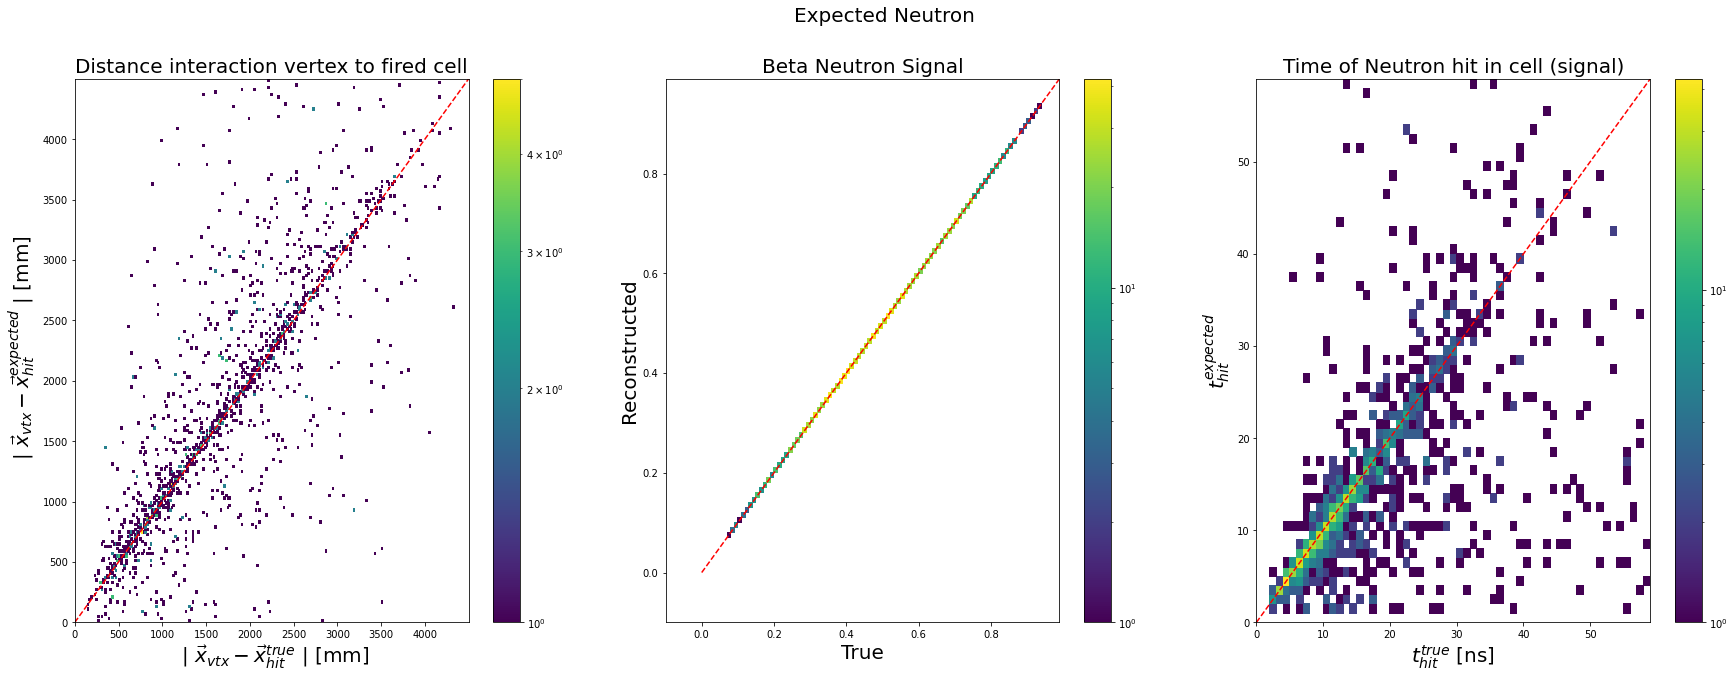

In [93]:
plotter = MultiPlotter(nrows=1, ncols=3, figsize=(30, 10), suptitle="Expected Neutron")

plotter.plot_hist2d(
    x = first_complete_cells_fired_by_neutron['True_FlightLength'],
    y = first_complete_cells_fired_by_neutron['ExpectedNeutron_FlightLength'],
    bins_x = np.arange(-0.1, 4500, 20),
    bins_y = np.arange(-0.1, 4500, 20),
    xlabel = r" | $\vec{x}_{vtx}-\vec{x}_{hit}^{true}$ | [mm]",
    ylabel = r" | $\vec{x}_{vtx}-\vec{x}_{hit}^{expected}$ | [mm]",
    log_scale = True,
)

plotter.axes[plotter.current_ax].plot([0,6000],[0,6000], linestyle='--', color='red')
plotter.axes[plotter.current_ax].set_title("Distance interaction vertex to fired cell", fontsize = 20)  

plotter.next_plot()

plotter.plot_hist2d(
    # x = fired_by_reconstructable_neutron.AddInfo(other_sample=signal_neutrons_reconstructable_complete, variable='PrimariesBeta'),
    x = signal_neutrons_reconstructable_complete.dataframe['PrimariesBeta'],
    y = signal_neutrons_reconstructable_complete.dataframe['ExpectedNeutron_Beta'],
    bins_x = np.arange(-0.1, 1, 0.01),
    bins_y = np.arange(-0.1, 1, 0.01),
    xlabel = "True",
    ylabel = "Reconstructed",
    log_scale = True,
)

plotter.axes[plotter.current_ax].plot([0,60],[0,60], linestyle='--', color='red')
plotter.axes[plotter.current_ax].set_title("Beta Neutron Signal", fontsize = 20) 

plotter.next_plot()

plotter.plot_hist2d(
    x = first_complete_cells_fired_by_neutron['Fired_Cell_true_Hit_t'],
    y = first_complete_cells_fired_by_neutron['ExpectedNeutron_TOF'] + 1,
    bins_x = np.arange(0, 60, 1),
    bins_y = np.arange(0, 60, 1),
    xlabel = r"$t_{hit}^{true}$ [ns]",
    ylabel = r"$t_{hit}^{expected}$",
    log_scale = True,
)

plotter.axes[plotter.current_ax].plot([0,60],[0,60], linestyle='--', color='red')
plotter.axes[plotter.current_ax].set_title("Time of Neutron hit in cell (signal)", fontsize = 20)

Comparison Time of flight to ECAL for neutrons and muons


Text(0.5, 1.0, 'muon tof - neutron tof')

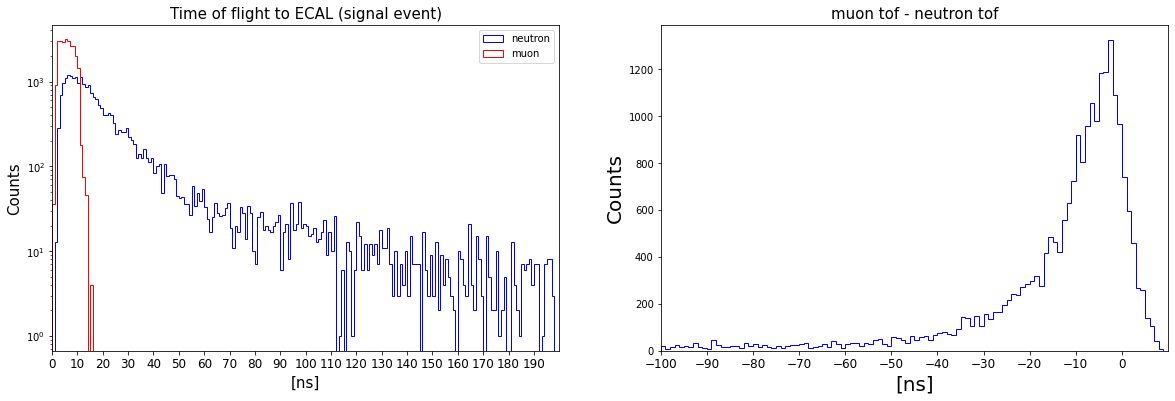

In [25]:
print("Comparison Time of flight to ECAL for neutrons and muons")
plotter = MultiPlotter(nrows=1, ncols=2, figsize=(20, 6))

# First histogram: Time of flight to ECAL for neutrons and muons
plotter.plot_hist(
    data = signal_neutrons_w_hits.dataframe['PrimariesFirstHitECAL_t'],
    bins = np.arange(0, 200, 1),
    label = 'neutron',
    color = 'blue',
    xlabel = "[ns]",
    ylabel = "Counts",
    xlim = (0, 200),
    ticks = np.arange(0, 200, 10)
)
plotter.plot_hist(
    data=signal_antimuons.dataframe.loc[signal_neutrons_w_hits.SampleIndex()]['PrimariesFirstHitECAL_t'],
    bins=np.arange(0, 200, 1),
    label='muon',
    color='red',
)
plotter.set_labels(xlabel="[ns]", ylabel="Counts", fontsize=15)
plotter.axes[0].set_yscale('log')
plotter.axes[0].set_title("Time of flight to ECAL (signal event)", fontsize=15)

plotter.next_plot(plot_legend=True)

# Second histogram: Difference between muon and neutron time of flight
plotter.plot_hist(
    data = signal_antimuons.dataframe.loc[signal_neutrons_w_hits.SampleIndex()]['PrimariesFirstHitECAL_t'].values - signal_neutrons_w_hits.dataframe['PrimariesFirstHitECAL_t'].values,
    bins = np.arange(-100, 10, 1),
    xlabel = "[ns]",
    ylabel = "Counts",
    xlim = (-100, 10),
    ticks = np.arange(-100, 10, 10)
)
plotter.axes[1].set_title("muon tof - neutron tof", fontsize=15)

all_hists.append(plotter)

In [56]:
fired_by_antimuons.dataframe.columns

Index(['entry', 'CCQEonHydrogen', 'EventId', 'Fired_Cells_mod',
       'Fired_Cells_x', 'Fired_Cells_y', 'Fired_Cells_z', 'isCellComplete',
       'Fired_Cells_adc1', 'Fired_Cells_tdc1', 'Fired_Cells_adc2',
       'Fired_Cells_tdc2', 'Fired_Cell_true_hit1_x', 'Fired_Cell_true_hit1_y',
       'Fired_Cell_true_hit1_z', 'Fired_Cell_true_hit1_t',
       'Fired_Cell_true_hit2_x', 'Fired_Cell_true_hit2_y',
       'Fired_Cell_true_hit2_z', 'Fired_Cell_true_hit2_t',
       'Fired_by_primary_neutron', 'Fired_by_primary_antimu',
       'Fired_Cell_true_Hit_x', 'Fired_Cell_true_Hit_y',
       'Fired_Cell_true_Hit_z', 'Fired_Cell_true_Hit_t',
       'ExpectedNeutron_HitPosition_x', 'ExpectedNeutron_HitPosition_y',
       'ExpectedNeutron_HitPosition_z', 'ExpectedNeutron_TOF',
       'Reconstructed_HitPosition_x', 'Reconstructed_HitPosition_y',
       'Reconstructed_HitPosition_z', 'Reconstructed_HitTime',
       'ExpectedNeutron_Beta', 'True_FlightLength',
       'ExpectedNeutron_FlightLength', 'R

In [107]:
fired_by_reconstructable_neutron.dataframe.columns

Index(['entry', 'CCQEonHydrogen', 'EventId', 'Fired_Cells_mod',
       'Fired_Cells_x', 'Fired_Cells_y', 'Fired_Cells_z', 'isCellComplete',
       'Fired_Cells_adc1', 'Fired_Cells_tdc1', 'Fired_Cells_adc2',
       'Fired_Cells_tdc2', 'Fired_Cell_true_hit1_x', 'Fired_Cell_true_hit1_y',
       'Fired_Cell_true_hit1_z', 'Fired_Cell_true_hit1_t',
       'Fired_Cell_true_hit2_x', 'Fired_Cell_true_hit2_y',
       'Fired_Cell_true_hit2_z', 'Fired_Cell_true_hit2_t',
       'Fired_by_primary_neutron', 'Fired_by_primary_antimu',
       'Fired_Cell_true_Hit_x', 'Fired_Cell_true_Hit_y',
       'Fired_Cell_true_Hit_z', 'Fired_Cell_true_Hit_t',
       'ExpectedNeutron_HitPosition_x', 'ExpectedNeutron_HitPosition_y',
       'ExpectedNeutron_HitPosition_z', 'ExpectedNeutron_TOF',
       'Reconstructed_HitPosition_x', 'Reconstructed_HitPosition_y',
       'Reconstructed_HitPosition_z', 'Reconstructed_HitTime',
       'ExpectedNeutron_Beta', 'True_FlightLength',
       'ExpectedNeutron_FlightLength', 'R

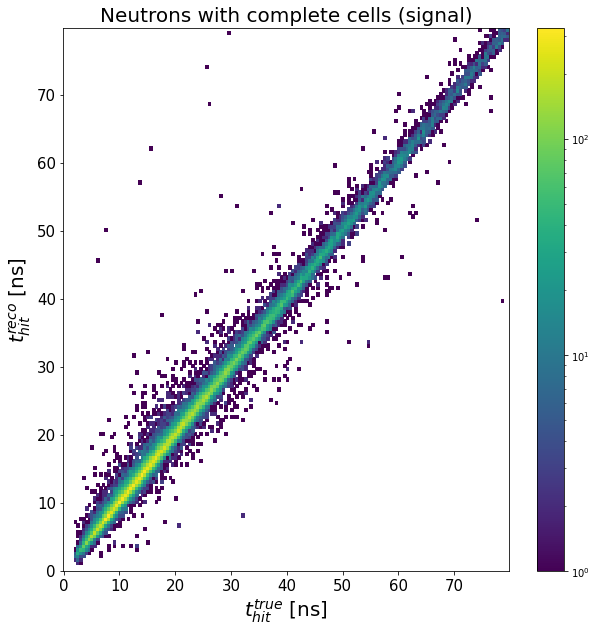

In [123]:
plotter = MultiPlotter(nrows=1, ncols=1, figsize=(10, 10))

# First 2D histogram plot with logarithmic scale
plotter.plot_hist2d(
    x = fired_by_reconstructable_neutron.dataframe['Fired_Cell_true_Hit_t'],
    y = fired_by_reconstructable_neutron.dataframe['Reconstructed_HitTime'] - 1,
    bins_x = np.arange(-0.1, 80, 0.5),
    bins_y = np.arange(-0.1, 80, 0.5),
    log_scale = True,
    xlabel = r'$t_{hit}^{true}$ [ns]',
    ylabel = r'$t_{hit}^{reco}$ [ns]',
)

plotter.axes[plotter.current_ax].tick_params(axis='x', labelsize=15)
plotter.axes[plotter.current_ax].tick_params(axis='y', labelsize=15)
plotter.axes[plotter.current_ax].set_title("Neutrons with complete cells (signal)", fontsize = 20)
# plotter.axes[plotter.current_ax].plot([0, 80], [0, 80], color='red', linestyle='--', linewidth=2)
# plotter.next_plot()

# plotter.plot_hist2d(
#     x = fired_by_reconstructable_neutron.dataframe.query("Fired_Cells_mod >= 30")['Fired_Cell_true_Hit_t'],
#     y = fired_by_reconstructable_neutron.dataframe.query("Fired_Cells_mod >= 30")['Reconstructed_HitTime'] - 1,
#     bins_x = np.arange(-0.1, 80, 0.5),
#     bins_y = np.arange(-0.1, 80, 0.5),
#     log_scale = True,
#     xlabel = r'$t_{hit}^{true}$ [ns]',
#     ylabel = r'$t_{hit}^{reco}$ [ns]',
# )

# # plotter.axes[plotter.current_ax].plot([0, 80], [0, 80], color='red', linestyle='--', linewidth=2)
# plotter.axes[plotter.current_ax].tick_params(axis='x', labelsize=15)
# plotter.axes[plotter.current_ax].tick_params(axis='y', labelsize=15)
# plotter.axes[plotter.current_ax].set_title("ENDCAP", fontsize = 15)
plt.savefig("/storage/gpfs_data/neutrino/users/gi/sand-physics/notebook/figures/ECAL_reco/t_hit_true_vs_reco_neutrons.pdf")

fwhm_x is :1.0279329608938546


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas_name
Info in <TCanvas::Print>: pdf file /storage/gpfs_data/neutrino/users/gi/sand-physics/notebook/figures/ECAL_reco/hit_time_true_vs_reco_neutrons.pdf has been created


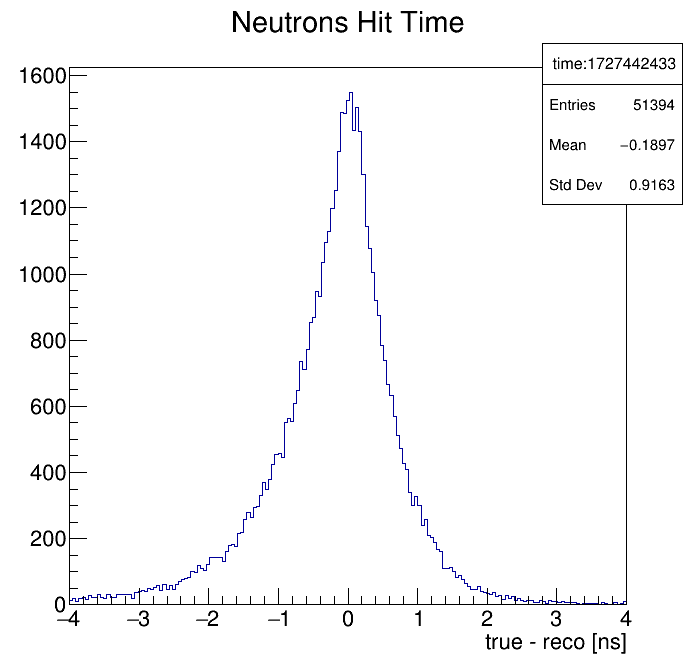

In [124]:
residuals_x = tool.FillTH1D(iterable = fired_by_reconstructable_neutron.dataframe['Fired_Cell_true_Hit_t'] + 1 - fired_by_reconstructable_neutron.dataframe['Reconstructed_HitTime'], 
                          histogram_name = "", 
                          title = "Neutrons Hit Time; true - reco [ns]", 
                          nbins = int(np.sqrt(len(fired_by_reconstructable_neutron.dataframe.query("Fired_Cells_mod < 30")['Fired_Cell_true_hit1_t']))),
                          #  nbins = 30,
                          x_min = -4, 
                          x_max = 4)

# residuals_y = tool.FillTH1D(iterable = fired_by_reconstructable_neutron.dataframe.query("Fired_Cells_mod >= 30")['Fired_Cell_true_Hit_t'] + 1 - fired_by_reconstructable_neutron.dataframe.query("Fired_Cells_mod >= 30")['Reconstructed_HitTime'], 
#                           histogram_name = "", 
#                           title = "Neutrons Hit Time (ENDCAP); true - reco [ns]", 
#                           nbins = int(np.sqrt(len(fired_by_reconstructable_neutron.dataframe.query("Fired_Cells_mod >= 30")['Fired_Cell_true_hit1_t']))),
#                           #  nbins = 30,
#                           x_min = -4, 
#                           x_max = 4)


# residuals_x, mean_res_x, sigma_res_x = tool.FitTH1D_w_gauss(hist = residuals_x, 
#                                              gauss_range = (-4, 4), 
#                                              fit_range = (-2,2))

# residuals_y, mean_res_y, sigma_res_y = tool.FitTH1D_w_gauss(hist = residuals_y, 
#                                              gauss_range = (-4, 4), 
#                                              fit_range = (-2,2))

bin1_x = residuals_x.FindFirstBinAbove(residuals_x.GetMaximum()/2)
bin2_x = residuals_x.FindLastBinAbove(residuals_x.GetMaximum()/2)
fwhm_x = residuals_x.GetBinCenter(bin2_x) - residuals_x.GetBinCenter(bin1_x)

# bin1_y = residuals_y.FindFirstBinAbove(residuals_y.GetMaximum()/2)
# bin2_y = residuals_y.FindLastBinAbove(residuals_y.GetMaximum()/2)
# fwhm_y = residuals_y.GetBinCenter(bin2_y) - residuals_y.GetBinCenter(bin1_y)

print(f"fwhm_x is :{fwhm_x}")
# print(f"fwhm_y is :{fwhm_y}")


c = ROOT.TCanvas("canvas_name", "Canvas", 700, 700)
# c.Divide(2)

# c.cd(1)
ROOT.gStyle.SetOptFit(1011)
residuals_x.Draw()
c.Draw()

# c.cd(2)
# ROOT.gStyle.SetOptFit(1011)
# residuals_y.Draw()
c.Draw()

c.SaveAs("/storage/gpfs_data/neutrino/users/gi/sand-physics/notebook/figures/ECAL_reco/hit_time_true_vs_reco_neutrons.pdf")

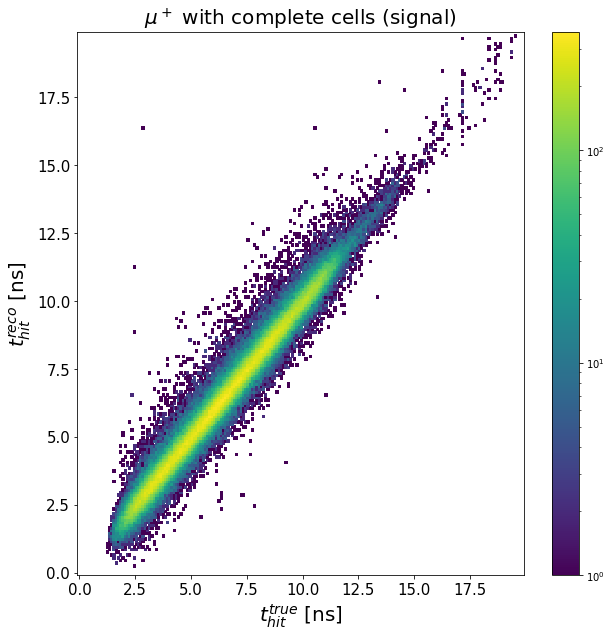

In [134]:
plotter = MultiPlotter(nrows=1, ncols=1, figsize=(10, 10))

# First 2D histogram plot with logarithmic scale
plotter.plot_hist2d(
    x = fired_by_antimuons.dataframe['Fired_Cell_true_Hit_t'],
    y = fired_by_antimuons.dataframe['Reconstructed_HitTime'] - 1,
    bins_x = np.arange(-0.1, 20, 0.1),
    bins_y = np.arange(-0.1, 20, 0.1),
    log_scale = True,
    xlabel = r'$t_{hit}^{true}$ [ns]',
    ylabel = r'$t_{hit}^{reco}$ [ns]',
)

plotter.axes[plotter.current_ax].tick_params(axis='x', labelsize=15)
plotter.axes[plotter.current_ax].tick_params(axis='y', labelsize=15)
plotter.axes[plotter.current_ax].set_title(r"$\mu^+$ with complete cells (signal)", fontsize = 20)
# plotter.axes[plotter.current_ax].plot([0, 80], [0, 80], color='red', linestyle='--', linewidth=2)
# plotter.next_plot()

# plotter.plot_hist2d(
#     x = fired_by_reconstructable_neutron.dataframe.query("Fired_Cells_mod >= 30")['Fired_Cell_true_Hit_t'],
#     y = fired_by_reconstructable_neutron.dataframe.query("Fired_Cells_mod >= 30")['Reconstructed_HitTime'] - 1,
#     bins_x = np.arange(-0.1, 80, 0.5),
#     bins_y = np.arange(-0.1, 80, 0.5),
#     log_scale = True,
#     xlabel = r'$t_{hit}^{true}$ [ns]',
#     ylabel = r'$t_{hit}^{reco}$ [ns]',
# )

# # plotter.axes[plotter.current_ax].plot([0, 80], [0, 80], color='red', linestyle='--', linewidth=2)
# plotter.axes[plotter.current_ax].tick_params(axis='x', labelsize=15)
# plotter.axes[plotter.current_ax].tick_params(axis='y', labelsize=15)
# plotter.axes[plotter.current_ax].set_title("ENDCAP", fontsize = 15)
plt.savefig("/storage/gpfs_data/neutrino/users/gi/sand-physics/notebook/figures/ECAL_reco/t_hit_true_vs_reco_antimu.pdf")

fwhm_x is :0.6917960088691795


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas_name
Info in <TCanvas::Print>: pdf file /storage/gpfs_data/neutrino/users/gi/sand-physics/notebook/figures/ECAL_reco/hit_time_true_vs_reco_antimu.pdf has been created


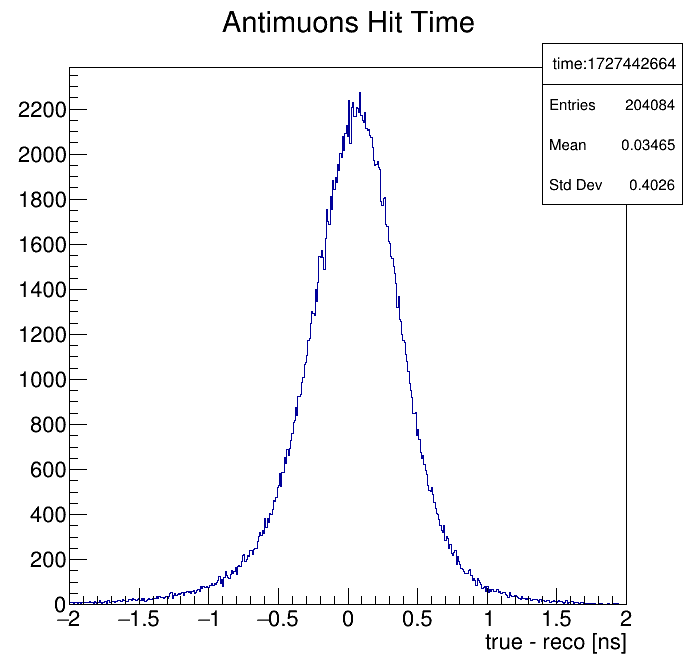

In [130]:
residuals_x = tool.FillTH1D(iterable = fired_by_antimuons.dataframe['Fired_Cell_true_Hit_t'] + 1 - fired_by_antimuons.dataframe['Reconstructed_HitTime'], 
                          histogram_name = "", 
                          title = "Antimuons Hit Time; true - reco [ns]", 
                          nbins = int(np.sqrt(len(fired_by_antimuons.dataframe['Fired_Cell_true_hit1_t']))),
                          #  nbins = 30,
                          x_min = -2, 
                          x_max = 2)

# residuals_y = tool.FillTH1D(iterable = fired_by_antimuons.dataframe.query("Fired_Cells_mod >= 30")['Fired_Cell_true_Hit_t'] + 1 - fired_by_antimuons.dataframe.query("Fired_Cells_mod >= 30")['Reconstructed_HitTime'], 
#                           histogram_name = "", 
#                           title = "Antimuons Hit Time (ENDCAP); true - reco [ns]", 
#                           nbins = int(np.sqrt(len(fired_by_antimuons.dataframe.query("Fired_Cells_mod >= 30")['Fired_Cell_true_hit1_t']))),
#                           #  nbins = 30,
#                           x_min = -2, 
#                           x_max = 2)


# residuals_x, mean_res_x, sigma_res_x = tool.FitTH1D_w_gauss(hist = residuals_x, 
#                                              gauss_range = (-2, 2), 
#                                              fit_range = (-1,1))

# residuals_y, mean_res_y, sigma_res_y = tool.FitTH1D_w_gauss(hist = residuals_y, 
#                                              gauss_range = (-2, 2), 
#                                              fit_range = (-1,1))

bin1_x = residuals_x.FindFirstBinAbove(residuals_x.GetMaximum()/2)
bin2_x = residuals_x.FindLastBinAbove(residuals_x.GetMaximum()/2)
fwhm_x = residuals_x.GetBinCenter(bin2_x) - residuals_x.GetBinCenter(bin1_x)

# bin1_y = residuals_y.FindFirstBinAbove(residuals_y.GetMaximum()/2)
# bin2_y = residuals_y.FindLastBinAbove(residuals_y.GetMaximum()/2)
# fwhm_y = residuals_y.GetBinCenter(bin2_y) - residuals_y.GetBinCenter(bin1_y)

print(f"fwhm_x is :{fwhm_x}")
# print(f"fwhm_y is :{fwhm_y}")


c = ROOT.TCanvas("canvas_name", "Canvas", 700, 700)
# c.Divide(2)

# c.cd(1)
ROOT.gStyle.SetOptFit(1011)
residuals_x.Draw()
c.Draw()

# c.cd(2)
# ROOT.gStyle.SetOptFit(1011)
# residuals_y.Draw()
# c.Draw()

c.SaveAs("/storage/gpfs_data/neutrino/users/gi/sand-physics/notebook/figures/ECAL_reco/hit_time_true_vs_reco_antimu.pdf")

In [69]:
fired_by_reconstructable_neutron.dataframe.columns

Index(['entry', 'CCQEonHydrogen', 'EventId', 'Fired_Cells_mod',
       'Fired_Cells_x', 'Fired_Cells_y', 'Fired_Cells_z', 'isCellComplete',
       'Fired_Cells_adc1', 'Fired_Cells_tdc1', 'Fired_Cells_adc2',
       'Fired_Cells_tdc2', 'Fired_Cell_true_hit1_x', 'Fired_Cell_true_hit1_y',
       'Fired_Cell_true_hit1_z', 'Fired_Cell_true_hit1_t',
       'Fired_Cell_true_hit2_x', 'Fired_Cell_true_hit2_y',
       'Fired_Cell_true_hit2_z', 'Fired_Cell_true_hit2_t',
       'Fired_by_primary_neutron', 'Fired_by_primary_antimu',
       'Fired_Cell_true_Hit_x', 'Fired_Cell_true_Hit_y',
       'Fired_Cell_true_Hit_z', 'Fired_Cell_true_Hit_t',
       'ExpectedNeutron_HitPosition_x', 'ExpectedNeutron_HitPosition_y',
       'ExpectedNeutron_HitPosition_z', 'ExpectedNeutron_TOF',
       'Reconstructed_HitPosition_x', 'Reconstructed_HitPosition_y',
       'Reconstructed_HitPosition_z', 'Reconstructed_HitTime',
       'ExpectedNeutron_Beta', 'True_FlightLength',
       'ExpectedNeutron_FlightLength', 'R

fwhm_x is :163.8888888888888
fwhm_y is :158.1395348837209


Warning in <TROOT::Append>: Replacing existing TH1:  time:1727438947 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas_name
Info in <TCanvas::Print>: pdf file /storage/gpfs_data/neutrino/users/gi/sand-physics/notebook/figures/ECAL_reco/hit_position_along_fiber_true_vs_reco_neutrons.pdf has been created


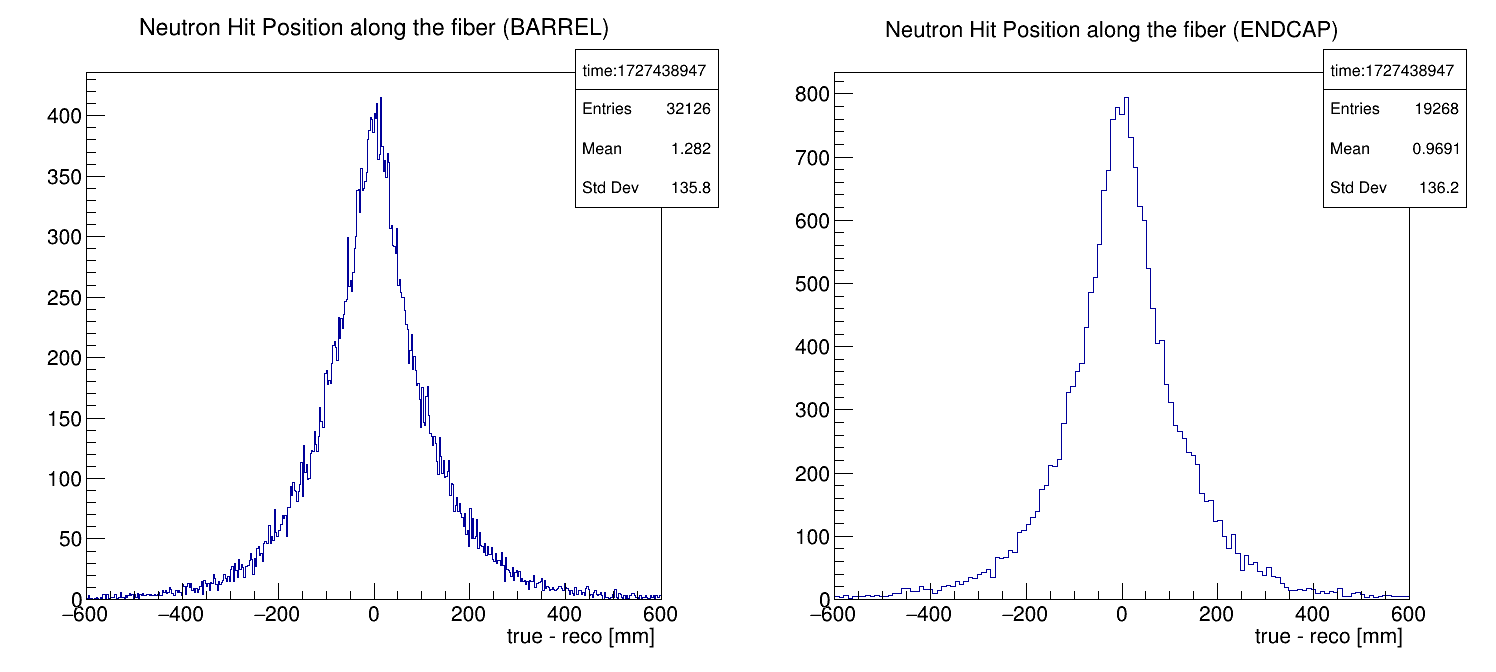

In [100]:

# barrels
residuals_hit_x = tool.FillTH1D(iterable = fired_by_reconstructable_neutron.dataframe.query("Fired_Cells_mod < 30")['Fired_Cell_true_Hit_x'] - fired_by_reconstructable_neutron.dataframe.query("Fired_Cells_mod < 30")['Reconstructed_HitPosition_x'], 
                          histogram_name = "", 
                          title = "Neutron Hit Position along the fiber (BARREL); true - reco [mm]", 
                          nbins = int(np.sqrt(len(fired_by_antimuons.dataframe.query("Fired_Cells_mod < 30")['Fired_Cell_true_Hit_x']))),
                          #  nbins = 30,
                          x_min = -600, 
                          x_max = 600)
# endcaps
residuals_hit_y = tool.FillTH1D(iterable = fired_by_reconstructable_neutron.dataframe.query("Fired_Cells_mod >= 30")['Fired_Cell_true_Hit_y'] - fired_by_reconstructable_neutron.dataframe.query("Fired_Cells_mod >= 30")['Reconstructed_HitPosition_y'], 
                          histogram_name = "", 
                          title = "Neutron Hit Position along the fiber (ENDCAP); true - reco [mm]", 
                          nbins = int(np.sqrt(len(fired_by_antimuons.dataframe.query("Fired_Cells_mod >= 30")['Fired_Cell_true_Hit_y']))),
                          #  nbins = 30,
                          x_min = -600, 
                          x_max = 600)

bin1_x = residuals_hit_x.FindFirstBinAbove(residuals_hit_x.GetMaximum()/2)
bin2_x = residuals_hit_x.FindLastBinAbove(residuals_hit_x.GetMaximum()/2)
fwhm_x = residuals_hit_x.GetBinCenter(bin2_x) - residuals_hit_x.GetBinCenter(bin1_x)

bin1_y = residuals_hit_y.FindFirstBinAbove(residuals_hit_y.GetMaximum()/2)
bin2_y = residuals_hit_y.FindLastBinAbove(residuals_hit_y.GetMaximum()/2)
fwhm_y = residuals_hit_y.GetBinCenter(bin2_y) - residuals_hit_y.GetBinCenter(bin1_y)

print(f"fwhm_x is :{fwhm_x}")
print(f"fwhm_y is :{fwhm_y}")

# residuals_hit_z = tool.FillTH1D(iterable = fired_by_reconstructable_neutron.dataframe['Fired_Cell_true_Hit_z'] - fired_by_reconstructable_neutron.dataframe['Reconstructed_HitPosition_z'], 
#                           histogram_name = "", 
#                           title = "neutron hit_z; true - reco [mm]", 
#                           nbins = int(np.sqrt(len(fired_by_antimuons.dataframe['Fired_Cell_true_hit1_z']))),
#                           #  nbins = 30,
#                           x_min = -60, 
#                           x_max = 60)


# residuals_hit_x, mean_res_x, sigma_res_x = tool.FitTH1D_w_gauss(hist = residuals_hit_x, 
#                                              gauss_range = (-500, 500), 
#                                              fit_range = (-180,180))

# residuals_hit_y, mean_res_y, sigma_res_y = tool.FitTH1D_w_gauss(hist = residuals_hit_y, 
#                                              gauss_range = (-500, 500), 
#                                              fit_range = (-180,180))


c = ROOT.TCanvas("canvas_name", "Canvas", 1500, 700)
c.Divide(2)

c.cd(1)
ROOT.gStyle.SetOptFit(1011)
residuals_hit_x.Draw()
c.Draw()

c.cd(2)
ROOT.gStyle.SetOptFit(1011)
residuals_hit_y.Draw()
c.Draw()

# c.cd(3)
# ROOT.gStyle.SetOptFit(1011)
# residuals_hit_z.Draw()
# c.Draw()
c.SaveAs("/storage/gpfs_data/neutrino/users/gi/sand-physics/notebook/figures/ECAL_reco/hit_position_along_fiber_true_vs_reco_neutrons.pdf")

fwhm_x is :113.8888888888888
fwhm_y is :102.32558139534888


Warning in <TROOT::Append>: Replacing existing TH1:  time:1727439000 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas_name
Info in <TCanvas::Print>: pdf file /storage/gpfs_data/neutrino/users/gi/sand-physics/notebook/figures/ECAL_reco/hit_position_along_fiber_true_vs_reco_antimu.pdf has been created


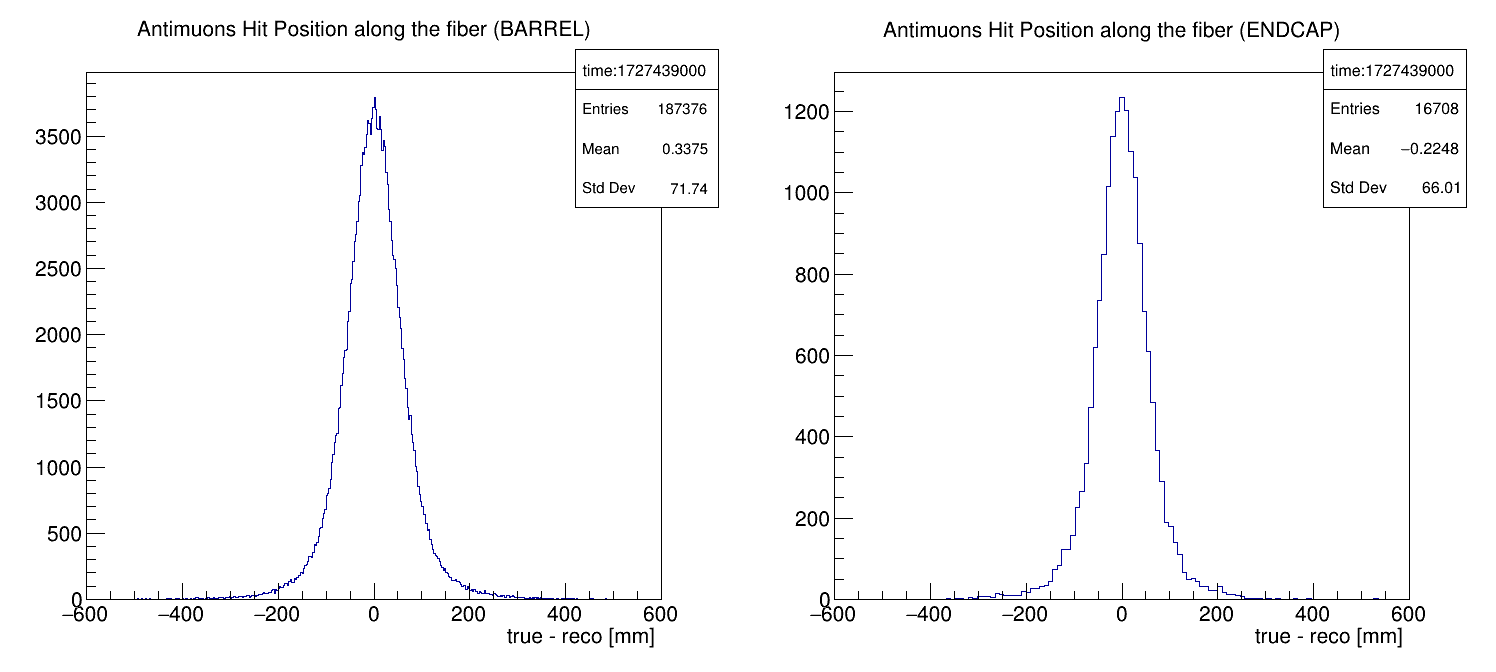

In [101]:
# barrels
residuals_hit_x = tool.FillTH1D(iterable = fired_by_antimuons.dataframe.query("Fired_Cells_mod < 30")['Fired_Cell_true_Hit_x'] - fired_by_antimuons.dataframe.query("Fired_Cells_mod < 30")['Reconstructed_HitPosition_x'], 
                          histogram_name = "", 
                          title = "Antimuons Hit Position along the fiber (BARREL); true - reco [mm];", 
                          nbins = int(np.sqrt(len(fired_by_antimuons.dataframe.query("Fired_Cells_mod < 30")['Fired_Cell_true_Hit_x']))),
                          #  nbins = 30,
                          x_min = -600, 
                          x_max = 600)
# endcaps
residuals_hit_y = tool.FillTH1D(iterable = fired_by_antimuons.dataframe.query("Fired_Cells_mod >= 30")['Fired_Cell_true_Hit_y'] - fired_by_antimuons.dataframe.query("Fired_Cells_mod >= 30")['Reconstructed_HitPosition_y'], 
                          histogram_name = "", 
                          title = "Antimuons Hit Position along the fiber (ENDCAP); true - reco [mm];", 
                          nbins = int(np.sqrt(len(fired_by_antimuons.dataframe.query("Fired_Cells_mod >= 30")['Fired_Cell_true_Hit_y']))),
                          #  nbins = 30,
                          x_min = -600, 
                          x_max = 600)

# residuals_hit_z = tool.FillTH1D(iterable = fired_by_antimuons.dataframe['Fired_Cell_true_hit1_z'] - fired_by_antimuons.dataframe['Cell_Reconstructed_hit_z'], 
#                           histogram_name = "", 
#                           title = "neutron hit_z; true - reco [mm]", 
#                           nbins = int(np.sqrt(len(fired_by_antimuons.dataframe['Fired_Cell_true_hit1_z']))),
#                           #  nbins = 30,
#                           x_min = -60, 
#                           x_max = 60)


# residuals_hit_x, mean_res_x, sigma_res_x = tool.FitTH1D_w_gauss(hist = residuals_hit_x, 
#                                              gauss_range = (-500, 500), 
#                                              fit_range = (-200,200))

# residuals_hit_y, mean_res_y, sigma_res_y = tool.FitTH1D_w_gauss(hist = residuals_hit_y, 
#                                              gauss_range = (-500, 500), 
#                                              fit_range = (-200,200))


bin1_x = residuals_hit_x.FindFirstBinAbove(residuals_hit_x.GetMaximum()/2)
bin2_x = residuals_hit_x.FindLastBinAbove(residuals_hit_x.GetMaximum()/2)
fwhm_x = residuals_hit_x.GetBinCenter(bin2_x) - residuals_hit_x.GetBinCenter(bin1_x)

bin1_y = residuals_hit_y.FindFirstBinAbove(residuals_hit_y.GetMaximum()/2)
bin2_y = residuals_hit_y.FindLastBinAbove(residuals_hit_y.GetMaximum()/2)
fwhm_y = residuals_hit_y.GetBinCenter(bin2_y) - residuals_hit_y.GetBinCenter(bin1_y)


print(f"fwhm_x is :{fwhm_x}")
print(f"fwhm_y is :{fwhm_y}")

bin1_x = residuals_hit_x.FindFirstBinAbove(residuals_hit_x.GetMaximum()/2)
bin2_x = residuals_hit_x.FindLastBinAbove(residuals_hit_x.GetMaximum()/2)
fwhm_x = residuals_hit_x.GetBinCenter(bin2_x) - residuals_hit_x.GetBinCenter(bin1_x)

bin1_y = residuals_hit_y.FindFirstBinAbove(residuals_hit_y.GetMaximum()/2)
bin2_y = residuals_hit_y.FindLastBinAbove(residuals_hit_y.GetMaximum()/2)
fwhm_y = residuals_hit_y.GetBinCenter(bin2_y) - residuals_hit_y.GetBinCenter(bin1_y)

c = ROOT.TCanvas("canvas_name", "Canvas", 1500, 700)
c.Divide(2)

c.cd(1)
ROOT.gStyle.SetOptFit(1011)
residuals_hit_x.Draw()
c.Draw()

c.cd(2)
ROOT.gStyle.SetOptFit(1011)
residuals_hit_y.Draw()
c.Draw()

# c.cd(3)
# ROOT.gStyle.SetOptFit(1011)
# residuals_hit_z.Draw()
# c.Draw()

c.SaveAs("/storage/gpfs_data/neutrino/users/gi/sand-physics/notebook/figures/ECAL_reco/hit_position_along_fiber_true_vs_reco_antimu.pdf")

In [101]:
fired_by_reconstructable_neutron.dataframe.columns

Index(['entry', 'CCQEonHydrogen', 'EventId', 'Fired_Cells_mod',
       'Fired_Cells_x', 'Fired_Cells_y', 'Fired_Cells_z', 'isCellComplete',
       'Fired_Cells_adc1', 'Fired_Cells_tdc1', 'who_produced_tdc1',
       'Fired_Cells_adc2', 'Fired_Cells_tdc2', 'who_produced_tdc2',
       'Fired_Cell_true_hit1_x', 'Fired_Cell_true_hit1_y',
       'Fired_Cell_true_hit1_z', 'Fired_Cell_true_hit1_t',
       'Fired_Cell_true_hit2_x', 'Fired_Cell_true_hit2_y',
       'Fired_Cell_true_hit2_z', 'Fired_Cell_true_hit2_t',
       'Cell_Reconstructed_hit_x', 'Cell_Reconstructed_hit_y',
       'Cell_Reconstructed_hit_z', 'Cell_Reconstructed_hit_t',
       'ExpectedNeutronHit_x', 'ExpectedNeutronHit_y', 'ExpectedNeutronHit_z',
       'ExpectedNeutronHit_t'],
      dtype='object')

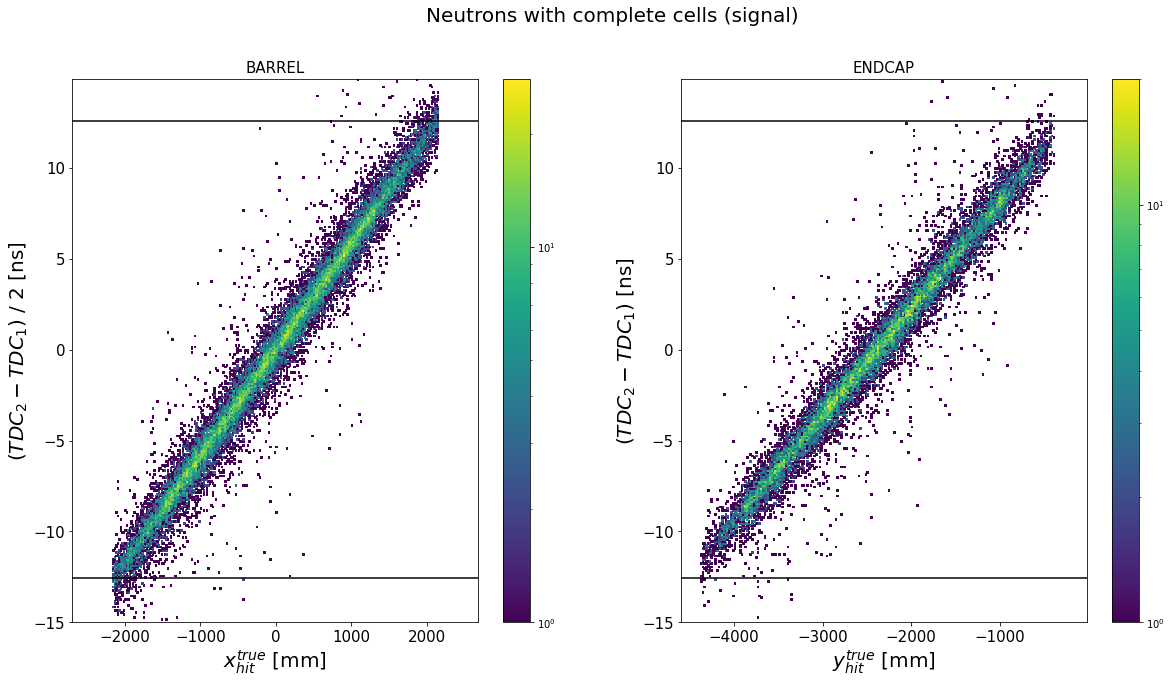

In [88]:
plotter = MultiPlotter(nrows=1, ncols=2, figsize=(20, 10), suptitle="Neutrons with complete cells (signal)")

L_cell = 4300 # mm
v_signal_in_fiber = 5.85/1e3 # ns/mm
max_tdc = L_cell / 2 * v_signal_in_fiber 

delta_tdc_over_2_barrel =  (fired_by_reconstructable_neutron.dataframe.query("Fired_Cells_mod < 30")['Fired_Cells_tdc2'] - fired_by_reconstructable_neutron.dataframe.query("Fired_Cells_mod < 30")['Fired_Cells_tdc1'])/2
delta_tdc_over_2_endcap =  (fired_by_reconstructable_neutron.dataframe.query("Fired_Cells_mod >= 30")['Fired_Cells_tdc2'] - fired_by_reconstructable_neutron.dataframe.query("Fired_Cells_mod >= 30")['Fired_Cells_tdc1'])/2

# First 2D histogram plot with logarithmic scale
plotter.plot_hist2d(
    x = fired_by_reconstructable_neutron.dataframe.query("Fired_Cells_mod < 30")['Fired_Cell_true_hit2_x'],
    y = delta_tdc_over_2_barrel,
    bins_x = np.arange(-2700, 2700, 20),
    bins_y = np.arange(-15, 15, 0.1),
    log_scale = True,
    xlabel = r'$x_{hit}^{true}$ [mm]',
    ylabel = r'$(TDC_2 - TDC_1)$ / 2 [ns]',
)

plotter.axes[plotter.current_ax].tick_params(axis='x', labelsize=15)
plotter.axes[plotter.current_ax].tick_params(axis='y', labelsize=15)
plotter.axes[plotter.current_ax].axhline(y = max_tdc, color = 'black')
plotter.axes[plotter.current_ax].axhline(y = -max_tdc, color = 'black')
plotter.axes[plotter.current_ax].set_title("BARREL", fontsize = 15)
plotter.next_plot()

plotter.plot_hist2d(
    x = fired_by_reconstructable_neutron.dataframe.query("Fired_Cells_mod >= 30")['Fired_Cell_true_hit2_y'],
    y = delta_tdc_over_2_endcap,
    bins_x = np.arange(-4600, 0, 20),
    bins_y = np.arange(-15, 15, 0.1),
    log_scale = True,
    xlabel = r'$y_{hit}^{true}$ [mm]',
    ylabel = r'$(TDC_2 - TDC_1)$ [ns]',
)

plotter.axes[plotter.current_ax].tick_params(axis='x', labelsize=15)
plotter.axes[plotter.current_ax].tick_params(axis='y', labelsize=15)
plotter.axes[plotter.current_ax].axhline(y = max_tdc, color = 'black')
plotter.axes[plotter.current_ax].axhline(y = -max_tdc, color = 'black')
plotter.axes[plotter.current_ax].set_title("ENDCAP", fontsize = 15)
plt.savefig("/storage/gpfs_data/neutrino/users/gi/sand-physics/notebook/figures/ECAL_reco/x_hit_true_vs_tdc_neutrons.pdf")

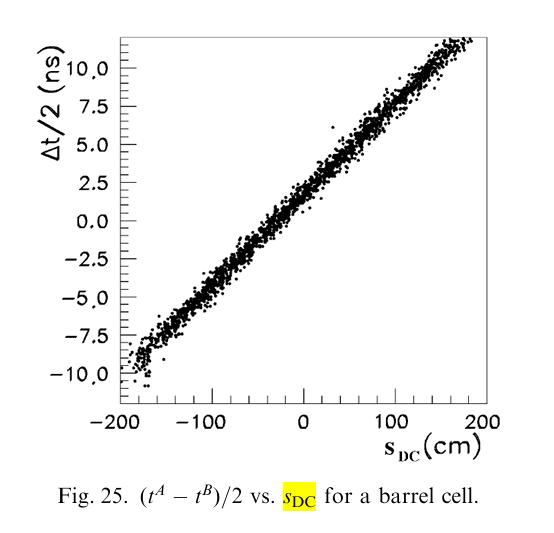

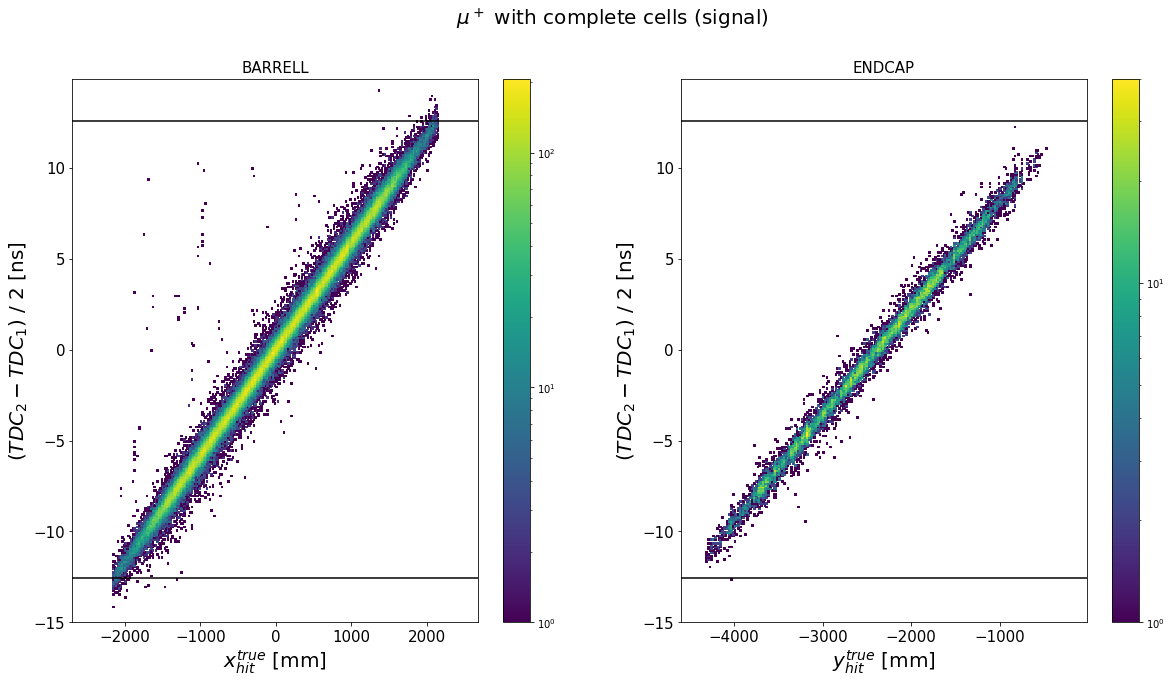

In [87]:
plotter = MultiPlotter(nrows=1, ncols=2, figsize=(20, 10), suptitle=r"$\mu^+$ with complete cells (signal)")

L_cell = 4300 # mm
v_signal_in_fiber = 5.85/1e3 # ns/mm
max_tdc = L_cell / 2 * v_signal_in_fiber 

delta_tdc_over_2_barrel =  (fired_by_antimuons.dataframe.query("Fired_Cells_mod < 30")['Fired_Cells_tdc2'] - fired_by_antimuons.dataframe.query("Fired_Cells_mod < 30")['Fired_Cells_tdc1'])/2
delta_tdc_over_2_endcap =  (fired_by_antimuons.dataframe.query("Fired_Cells_mod >= 30")['Fired_Cells_tdc2'] - fired_by_antimuons.dataframe.query("Fired_Cells_mod >= 30")['Fired_Cells_tdc1'])/2

# First 2D histogram plot with logarithmic scale
plotter.plot_hist2d(
    x = fired_by_antimuons.dataframe.query("Fired_Cells_mod < 30")['Fired_Cell_true_hit2_x'],
    y = delta_tdc_over_2_barrel,
    bins_x = np.arange(-2700, 2700, 20),
    bins_y = np.arange(-15, 15, 0.1),
    log_scale = True,
    xlabel = r'$x_{hit}^{true}$ [mm]',
    ylabel = r'$(TDC_2 - TDC_1)$ / 2 [ns]',
)

plotter.axes[plotter.current_ax].tick_params(axis='x', labelsize=15)
plotter.axes[plotter.current_ax].tick_params(axis='y', labelsize=15)
plotter.axes[plotter.current_ax].axhline(y = max_tdc, color = 'black')
plotter.axes[plotter.current_ax].axhline(y = -max_tdc, color = 'black')
plotter.axes[plotter.current_ax].set_title("BARRELL", fontsize=15)
plotter.next_plot()

plotter.plot_hist2d(
    x = fired_by_antimuons.dataframe.query("Fired_Cells_mod >= 30")['Fired_Cell_true_hit2_y'],
    y = delta_tdc_over_2_endcap,
    bins_x = np.arange(-4600, 0, 20),
    bins_y = np.arange(-15, 15, 0.1),
    log_scale = True,
    xlabel = r'$y_{hit}^{true}$ [mm]',
    ylabel = r'$(TDC_2 - TDC_1)$ / 2 [ns]',
)

plotter.axes[plotter.current_ax].tick_params(axis='x', labelsize=15)
plotter.axes[plotter.current_ax].tick_params(axis='y', labelsize=15)
plotter.axes[plotter.current_ax].axhline(y = max_tdc, color = 'black')
plotter.axes[plotter.current_ax].axhline(y = -max_tdc, color = 'black')
plotter.axes[plotter.current_ax].set_title("ENDCAP", fontsize=15)
plt.savefig("/storage/gpfs_data/neutrino/users/gi/sand-physics/notebook/figures/ECAL_reco/x_hit_true_vs_tdc_antimu.pdf")

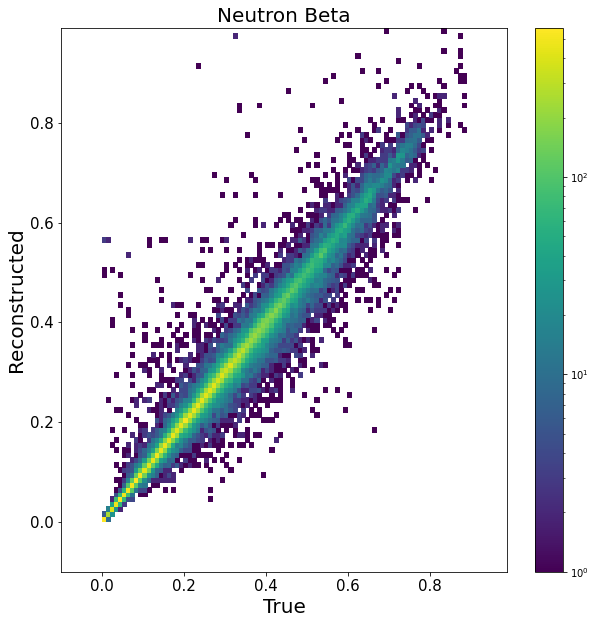

In [151]:
c = 299.792 # mm / ns
plotter = MultiPlotter(nrows=1, ncols=1, figsize=(10, 10))

# plotter.plot_hist2d(
#     x = fired_by_reconstructable_neutron.dataframe['True_FlightLength'],
#     y = fired_by_reconstructable_neutron.dataframe['Reconstructed_FlightLength'],
#     bins_x = np.arange(-0.1, 4500, 20),
#     bins_y = np.arange(-0.1, 4500, 20),
#     xlabel = r" | $\vec{x}_{vtx}-\vec{x}_{hit}^{true}$ | [mm]",
#     ylabel = r" | $\vec{x}_{vtx}-\vec{x}_{hit}^{reco}$ | [mm]",
#     log_scale = True,
# )

# plotter.axes[plotter.current_ax].tick_params(axis='x', labelsize=15)
# plotter.axes[plotter.current_ax].tick_params(axis='y', labelsize=15)
# # plotter.axes[plotter.current_ax].plot([0,6000],[0,6000], linestyle='--', color='red')
# plotter.axes[plotter.current_ax].set_title("Distance interaction vertex to hit in cell", fontsize = 20)

# plotter.next_plot()

# plotter.plot_hist2d(
#     x = fired_by_reconstructable_neutron.dataframe['Fired_Cell_true_Hit_t'],
#     y = fired_by_reconstructable_neutron.dataframe['Reconstructed_HitTime'] - 1,
#     bins_x = np.arange(0, 80, 1),
#     bins_y = np.arange(0, 80, 1),
#     xlabel = r"$t_{hit}^{true}$ [ns]",
#     ylabel = r"$t_{hit}^{reco}$",
#     log_scale = True,
# )

# plotter.axes[plotter.current_ax].plot([0,80],[0,80], linestyle='--', color='red')
# plotter.axes[plotter.current_ax].set_title("Time of Neutron hit in cell", fontsize = 20)

# plotter.next_plot()

plotter.plot_hist2d(
    # x = fired_by_reconstructable_neutron.AddInfo(other_sample=signal_neutrons_reconstructable_complete, variable='PrimariesBeta'),
    x = fired_by_reconstructable_neutron.dataframe['True_FlightLength']/((fired_by_reconstructable_neutron.dataframe['Fired_Cell_true_Hit_t'] ) * c),
    y = fired_by_reconstructable_neutron.dataframe['Reconstructed_FlightLength']/((fired_by_reconstructable_neutron.dataframe['Reconstructed_HitTime'] - 1) * c),
    bins_x = np.arange(-0.1, 1, 0.01),
    bins_y = np.arange(-0.1, 1, 0.01),
    xlabel = "True",
    ylabel = "Reconstructed",
    log_scale = True,
)

plotter.axes[plotter.current_ax].tick_params(axis='x', labelsize=15)
plotter.axes[plotter.current_ax].tick_params(axis='y', labelsize=15)
# plotter.axes[plotter.current_ax].plot([-1,60],[-1,60], linestyle='--', color='red')
plotter.axes[plotter.current_ax].set_title("Neutron Beta", fontsize = 20)

plt.savefig("/storage/gpfs_data/neutrino/users/gi/sand-physics/notebook/figures/ECAL_reco/beta_true_vs_reco_neutrons.pdf")



fwhm_x is :0.00530973451327435


Info in <TCanvas::Print>: pdf file /storage/gpfs_data/neutrino/users/gi/sand-physics/notebook/figures/ECAL_reco/beta_true_residuals_neutron.pdf has been created


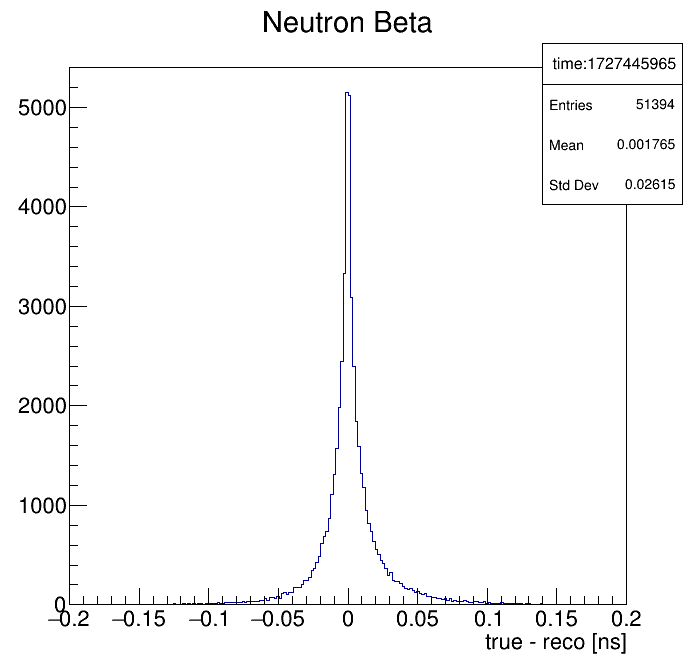

In [149]:
c = 299.792 # mm / ns
beta_true = fired_by_reconstructable_neutron.dataframe['True_FlightLength']/((fired_by_reconstructable_neutron.dataframe['Fired_Cell_true_Hit_t'] ) * c)
beta_reco = fired_by_reconstructable_neutron.dataframe['Reconstructed_FlightLength']/((fired_by_reconstructable_neutron.dataframe['Reconstructed_HitTime'] - 1) * c)

residuals_x = tool.FillTH1D(iterable = beta_true - beta_reco, 
                          histogram_name = "", 
                          title = "Neutron Beta; true - reco [ns]", 
                          nbins = int(np.sqrt(len(beta_true))),
                          #  nbins = 30,
                          x_min = -0.2, 
                          x_max = 0.2)

# residuals_y = tool.FillTH1D(iterable = fired_by_antimuons.dataframe.query("Fired_Cells_mod >= 30")['Fired_Cell_true_Hit_t'] + 1 - fired_by_antimuons.dataframe.query("Fired_Cells_mod >= 30")['Reconstructed_HitTime'], 
#                           histogram_name = "", 
#                           title = "Antimuons Hit Time (ENDCAP); true - reco [ns]", 
#                           nbins = int(np.sqrt(len(fired_by_antimuons.dataframe.query("Fired_Cells_mod >= 30")['Fired_Cell_true_hit1_t']))),
#                           #  nbins = 30,
#                           x_min = -2, 
#                           x_max = 2)


# residuals_x, mean_res_x, sigma_res_x = tool.FitTH1D_w_gauss(hist = residuals_x, 
#                                              gauss_range = (-2, 2), 
#                                              fit_range = (-1,1))

# residuals_y, mean_res_y, sigma_res_y = tool.FitTH1D_w_gauss(hist = residuals_y, 
#                                              gauss_range = (-2, 2), 
#                                              fit_range = (-1,1))

bin1_x = residuals_x.FindFirstBinAbove(residuals_x.GetMaximum()/2)
bin2_x = residuals_x.FindLastBinAbove(residuals_x.GetMaximum()/2)
fwhm_x = residuals_x.GetBinCenter(bin2_x) - residuals_x.GetBinCenter(bin1_x)

# bin1_y = residuals_y.FindFirstBinAbove(residuals_y.GetMaximum()/2)
# bin2_y = residuals_y.FindLastBinAbove(residuals_y.GetMaximum()/2)
# fwhm_y = residuals_y.GetBinCenter(bin2_y) - residuals_y.GetBinCenter(bin1_y)

print(f"fwhm_x is :{fwhm_x}")
# print(f"fwhm_y is :{fwhm_y}")


c = ROOT.TCanvas("canvas_name", "Canvas", 700, 700)
# c.Divide(2)

# c.cd(1)
ROOT.gStyle.SetOptFit(1011)
residuals_x.Draw()
c.Draw()

# c.cd(2)
# ROOT.gStyle.SetOptFit(1011)
# residuals_y.Draw()
# c.Draw()

c.SaveAs("/storage/gpfs_data/neutrino/users/gi/sand-physics/notebook/figures/ECAL_reco/beta_true_residuals_neutron.pdf")

Missing Transverse Momentum comparison C and C3H6


Text(0.5, 1.0, 'Missing Transverse Momentum : $p_T^m = |\\vec{p_T}^\\mu - \\vec{p_T}^H|$')

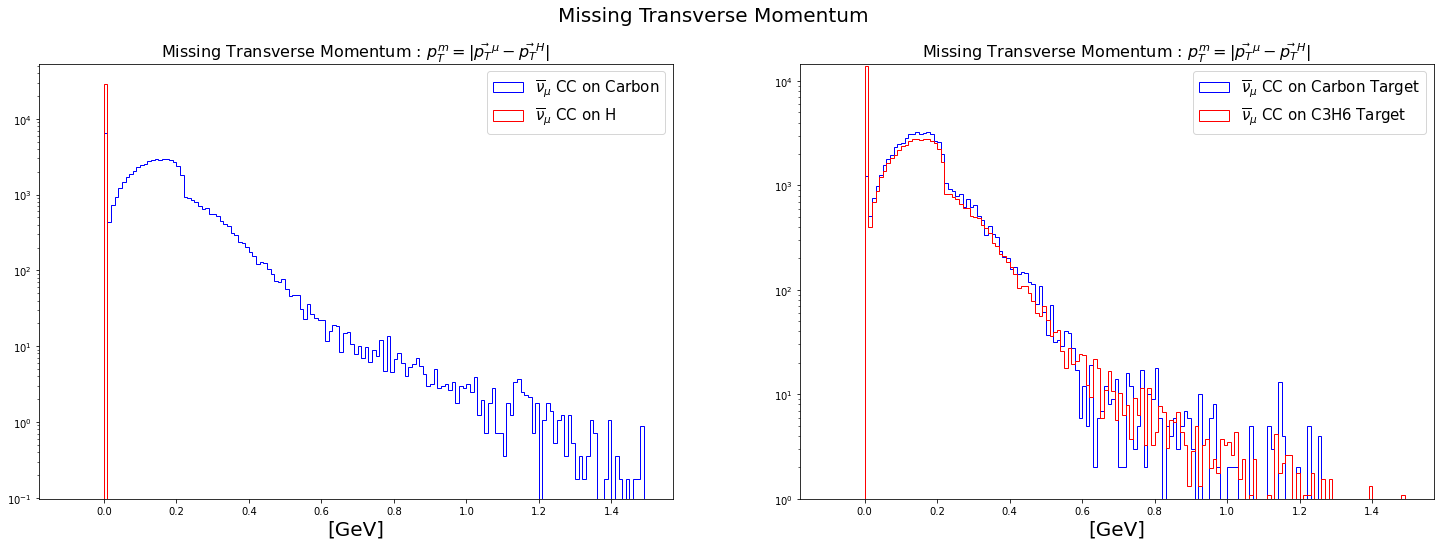

In [28]:
print("Missing Transverse Momentum comparison C and C3H6")
ratio_C12_H = 311685 / 55008
ratio_mass_target_C3H6_mass_target_C = 3.2 / 0.7

plotter = MultiPlotter(nrows=1, ncols=2, figsize=(25, 8), suptitle="Missing Transverse Momentum")

plotter.plot_hist(
    data=df[df.CCQEonHydrogen==0]['MissingTransverseMomentum'],
    bins=np.arange(-0.1,1.5,0.01),
    weights=np.ones(len(df[df.CCQEonHydrogen==0]['MissingTransverseMomentum'])) * (1/ratio_C12_H),
    color='blue',
    label=r'$\overline{\nu}_\mu$ CC on Carbon',
)

plotter.plot_hist(
    data=df[df.CCQEonHydrogen==1]['MissingTransverseMomentum'], 
    bins=np.arange(-0.1, 1.5, 0.01),
    color='red', 
    label=r'$\overline{\nu}_\mu$ CC on H',
    xlabel="[GeV]",
)

plotter.add_legend(labels=[r'$\overline{\nu}_\mu$ CC on Carbon', r'$\overline{\nu}_\mu$ CC on H'])
plotter.axes[plotter.current_ax].set_title(r"Missing Transverse Momentum : $p_T^m = |\vec{p_T}^\mu - \vec{p_T}^H|$", fontsize=16)
plotter.axes[plotter.current_ax].set_yscale("log")

plotter.next_plot()

plotter.plot_hist(
    data=df[df.InteractionVolume_short=='C_Target']['MissingTransverseMomentum'], 
    bins=np.arange(-0.1, 1.5, 0.01),
    color='blue', 
    label=r'$\overline{\nu}_\mu$ CC on Carbon Target'
)

plotter.plot_hist(
    data=df[df.InteractionVolume_short=='C3H6_Target']['MissingTransverseMomentum'], 
    bins=np.arange(-0.1, 1.5, 0.01),
    weights=np.ones(len(df[df.InteractionVolume_short=='C3H6_Target']['MissingTransverseMomentum'])) * (1 / ratio_mass_target_C3H6_mass_target_C),
    color='red', 
    label=r'$\overline{\nu}_\mu$ CC on C3H6 Target'
)

plotter.add_legend(labels=[r'$\overline{\nu}_\mu$ CC on Carbon Target', r'$\overline{\nu}_\mu$ CC on C3H6 Target'])
plotter.set_labels(xlabel="[GeV]")
plotter.set_limits(ylim=(1, None))  # For log scale y-axis
plotter.axes[plotter.current_ax].set_yscale("log")
plotter.axes[plotter.current_ax].set_title(r"Missing Transverse Momentum : $p_T^m = |\vec{p_T}^\mu - \vec{p_T}^H|$", fontsize=16)

all_hists.append(plotter)

In [193]:
fired_by_reconstructable_neutron.condition

'(isCellComplete==1 & who_produced_tdc1==1) & (CCQEonHydrogen==1 & PrimariesPDG==2112 & HasChangedDirection == 0 & IsECALHitMissing == 0)'

Neutron tof to ECAL (signal, complete cells) comparison: true, prediction, reconstructed


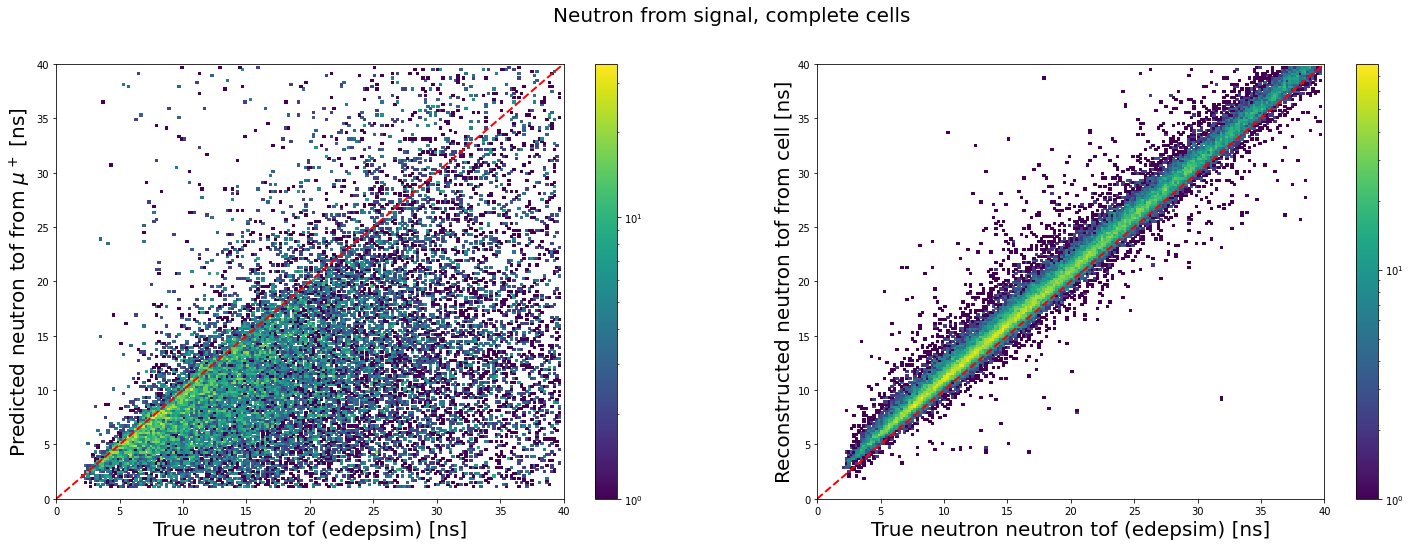

In [29]:
print("Neutron tof to ECAL (signal, complete cells) comparison: true, prediction, reconstructed")
plotter = MultiPlotter(nrows=1, ncols=2, figsize=(25, 8), suptitle="Neutron from signal, complete cells")

plotter.plot_hist2d(
    x = fired_by_reconstructable_neutron.dataframe['Fired_Cell_true_hit1_t'],
    y = fired_by_reconstructable_neutron.dataframe['ExpectedNeutronHit_t'],
    bins_x = np.arange(0,40,0.2),
    bins_y = np.arange(0,40,0.2),
    log_scale = True,
    # label='',
    xlabel = 'True neutron tof (edepsim) [ns]',
    ylabel = r'Predicted neutron tof from $\mu^+$ [ns]',
    xlim = [0,40],
    ylim = [0,40]
)

plotter.axes[plotter.current_ax].plot([0, 40], [0, 40], color='red', linestyle='--', linewidth=2)

plotter.next_plot()

plotter.plot_hist2d(
    x = fired_by_reconstructable_neutron.dataframe['Fired_Cell_true_hit1_t'],
    y = fired_by_reconstructable_neutron.dataframe['Cell_Reconstructed_hit_t'],
    bins_x = np.arange(0,40,0.2),
    bins_y = np.arange(0,40,0.2),
    log_scale = True,
    xlabel = 'True neutron neutron tof (edepsim) [ns]',
    ylabel = 'Reconstructed neutron tof from cell [ns]',
    xlim = [0,40],
    ylim = [0,40]
)

plotter.axes[plotter.current_ax].plot([0, 40], [0, 40], color='red', linestyle='--', linewidth=2)

all_hists.append(plotter)

In [22]:
signal_neutrons_reconstructable_complete.dataframe.columns

Index(['entry', 'EventId', 'EventType', 'CCQEonHydrogen', 'Interaction_vtxX',
       'Interaction_vtxY', 'Interaction_vtxZ', 'Interaction_vtxT',
       'PrimariesPDG', 'PrimariesP4_x', 'PrimariesP4_y', 'PrimariesP4_z',
       'PrimariesP4_t', 'PrimariesFirstHitECAL_x', 'PrimariesFirstHitECAL_y',
       'PrimariesFirstHitECAL_z', 'PrimariesFirstHitECAL_t',
       'PrimariesEDepECAL', 'PrimariesEmissionAngle', 'IsECALHitMissing',
       'DeviationAngle', 'HasChangedDirection', 'dist_Vtx2ECAL', 'mass',
       'E_kin', 'gamma', 'beta'],
      dtype='object')

In [ ]:
df

Text(0.5, 1.0, '$\\mu^+$ tof true - reco')

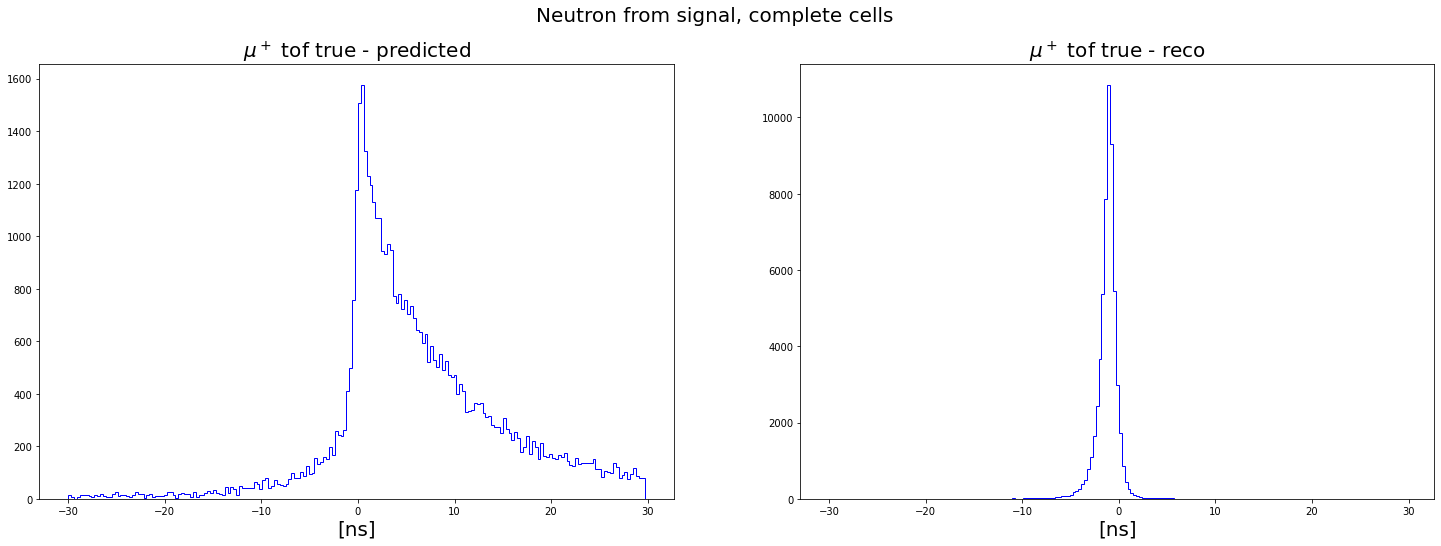

In [30]:
plotter = MultiPlotter(nrows=1, ncols=2, figsize=(25, 8), suptitle="Neutron from signal, complete cells")

plotter.plot_hist(
    fired_by_reconstructable_neutron.dataframe['Fired_Cell_true_hit1_t'] - fired_by_reconstructable_neutron.dataframe['ExpectedNeutronHit_t'],
    bins = np.arange(-30,30,0.3),
    xlabel = "[ns]",
)

plotter.axes[plotter.current_ax].set_title(r"$\mu^+$ tof true - predicted", fontsize = 20)

plotter.next_plot()

plotter.plot_hist(
    fired_by_reconstructable_neutron.dataframe['Fired_Cell_true_hit1_t'] - fired_by_reconstructable_neutron.dataframe['Cell_Reconstructed_hit_t'],
    bins = np.arange(-30,30,0.3),
    xlabel = "[ns]",
)
plotter.axes[plotter.current_ax].set_title(r"$\mu^+$ tof true - reco", fontsize = 20)


In [188]:
fired_by_antimuons.condition

'(isCellComplete==1 & who_produced_tdc1==0) & ((CCQEonHydrogen==1 & PrimariesPDG==-13) & (isCellComplete==1 & who_produced_tdc1==0))'

Muon tof to ECAL (signal, complete cells) comparison: true, reconstructed


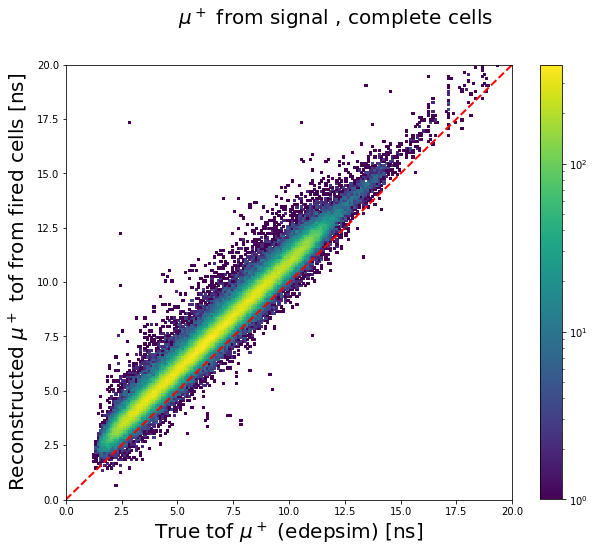

In [31]:
print("Muon tof to ECAL (signal, complete cells) comparison: true, reconstructed")
plotter = MultiPlotter(nrows=1, ncols=1, figsize=(10, 8), suptitle=r"$\mu^+$ from signal , complete cells")

plotter.plot_hist2d(
    x = fired_by_antimuons.dataframe['Fired_Cell_true_hit1_t'],
    y = fired_by_antimuons.dataframe['Cell_Reconstructed_hit_t'],
    bins_x = np.arange(0, 50, 0.1),
    bins_y = np.arange(0, 50, 0.1),
    log_scale = True,
    xlabel = r'True tof $\mu^+$ (edepsim) [ns]',
    ylabel = r'Reconstructed $\mu^+$ tof from fired cells [ns]',
    xlim = [0,20],
    ylim = [0,20],
)

plotter.axes[plotter.current_ax].plot([0, 20], [0, 20], color='red', linestyle='--', linewidth=2)

all_hists.append(plotter)

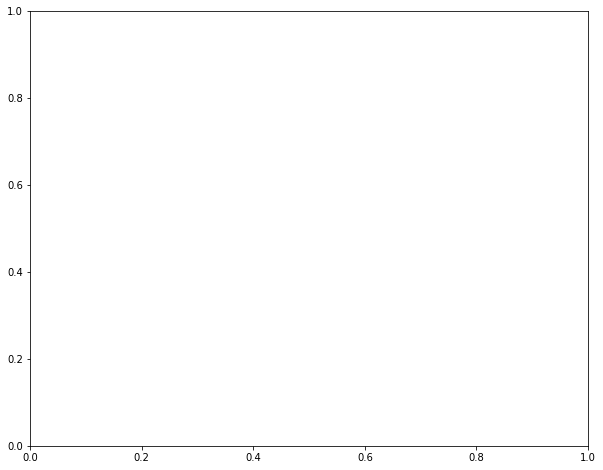

In [161]:
MultiPlotter().save_multiple_figures_to_pdf('/storage/gpfs_data/neutrino/users/gi/sand-physics/scratch/multiple_plots.pdf', all_hists)

# Checks on reconstructed hit

# Check:
check neutron expected hit position in similare to neutron first hit from edepsim

how many times neutron changes its direction on the way to ECAL?

For neutrons that haven't changed their initial directions, how good i am in predicting the tof and the arrival position to the ECAL?

prediction on arrival point in the ECAL

In [32]:
tscin = 3.08
tscex = 0.588

# Generazione di numeri casuali uniformi e calcolo di tdec
random_uniform_values = np.random.uniform(size=10000)  # Genera 10000 valori casuali
tdec_values = tscin * np.power(1. / random_uniform_values - 1., tscex)

# Calcolo del valore medio
mean_tdec = np.mean(tdec_values)

print("Mean value of tdec:", mean_tdec)

Mean value of tdec: 5.654763449348679


 FCN=112.893 FROM MIGRAD    STATUS=CONVERGED      66 CALLS          67 TOTAL
                     EDM=4.84837e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.77115e+02   1.12124e+01   4.16296e-02   3.31047e-06
   2  Mean         3.25067e+00   1.68462e+00   8.77404e-03   6.27317e-06
   3  Sigma        9.58742e+01   1.73831e+00   2.28419e-05   6.20946e-03
 FCN=132.383 FROM MIGRAD    STATUS=CONVERGED      65 CALLS          66 TOTAL
                     EDM=6.0117e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.97574e+02   1.05020e+01   4.14870e-02  -5.69923e-05
   2  Mean        -4.30246e+00   2.00948e+00   1.13235e-02  -2.22437e-04
   3  Sigma        1.03980e+02   2

Warning in <TROOT::Append>: Replacing existing TH1:  time:1726522953 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas_name


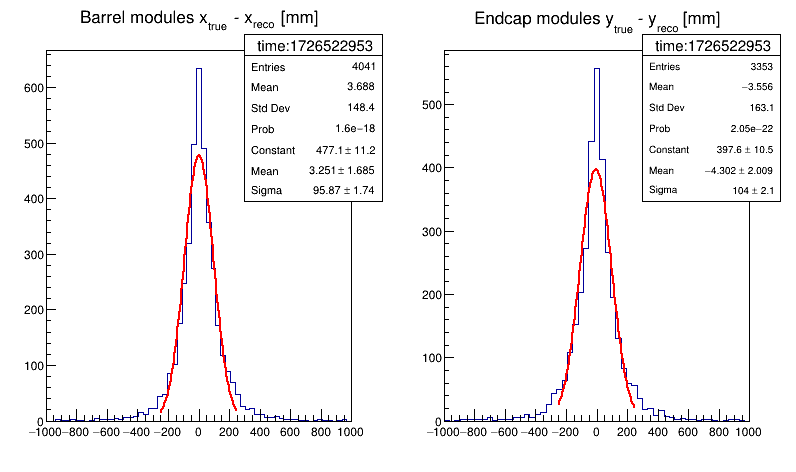

In [63]:
residuals_x = tool.FillTH1D(iterable = neutron_signal_complete_fired_cells_barrels.True_hit1_x - neutron_signal_complete_fired_cells_barrels.hit_reco_x.values, 
                          histogram_name = "", 
                          title = r"Barrel modules x_{true} - x_{reco} [mm]", 
                          nbins = int(np.sqrt(len(neutron_signal_complete_fired_cells_barrels))),
                          #  nbins = 30,
                          x_min = -1000, 
                          x_max = 1000)

residuals_y = tool.FillTH1D(iterable = neutron_signal_complete_fired_cells_encaps.True_hit1_y - neutron_signal_complete_fired_cells_encaps.hit_reco_y.values, 
                          histogram_name = "", 
                          title = r"Endcap modules y_{true} - y_{reco} [mm]", 
                          nbins = int(np.sqrt(len(neutron_signal_complete_fired_cells_encaps))),
                          #  nbins = 30,
                          x_min = -1000, 
                          x_max = 1000)

residuals_x_hist, mean_res_x, sigma_res_x = tool.FitTH1D_w_gauss(hist = residuals_x, 
                                             gauss_range = (-1000, 1000), 
                                             fit_range = (-250,250))

residuals_y_hist, mean_res_y, sigma_res_y = tool.FitTH1D_w_gauss(hist = residuals_y, 
                                             gauss_range = (-1000, 1000), 
                                             fit_range = (-250,250))

c = ROOT.TCanvas("canvas_name", "Canvas", 800, 500)
c.Divide(2)

c.cd(1)
ROOT.gStyle.SetOptFit(1011)
residuals_x_hist.Draw()
c.Draw()

c.cd(2)
ROOT.gStyle.SetOptFit(1011)
residuals_y_hist.Draw()
c.Draw()

 FCN=272.733 FROM MIGRAD    STATUS=CONVERGED      76 CALLS          77 TOTAL
                     EDM=1.28429e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.85050e+02   1.08072e+01   5.72888e-02  -2.03156e-05
   2  Mean         3.00334e+00   1.91830e+00   1.54781e-02  -2.00003e-05
   3  Sigma        9.84704e+01   2.32755e+00   4.28095e-05  -2.75167e-02
 FCN=186.757 FROM MIGRAD    STATUS=CONVERGED      75 CALLS          76 TOTAL
                     EDM=1.83035e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.83169e+02   8.83634e+00   3.86546e-02   9.72513e-06
   2  Mean        -3.45628e+00   2.75491e+00   1.84320e-02   7.52088e-06
   3  Sigma        1.22589e+02   

Warning in <TROOT::Append>: Replacing existing TH1:  time:1726523113 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas_name


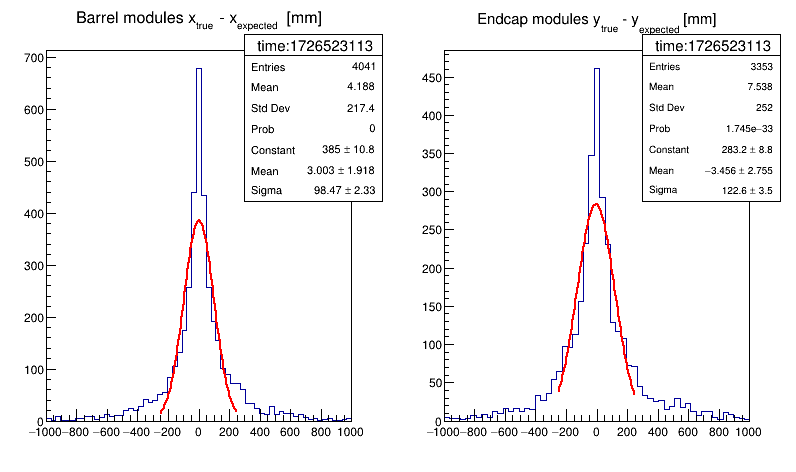

In [65]:
residuals_x = tool.FillTH1D(iterable = neutron_signal_complete_fired_cells_barrels.True_hit1_x - neutron_signal_complete_fired_cells_barrels.ExpectedNeutronHit_x, 
                          histogram_name = "", 
                          title = r"Barrel modules x_{true} - x_{expected} [mm]", 
                          nbins = int(np.sqrt(len(neutron_signal_complete_fired_cells_barrels))),
                          #  nbins = 30,
                          x_min = -1000, 
                          x_max = 1000)

residuals_y = tool.FillTH1D(iterable = neutron_signal_complete_fired_cells_encaps.True_hit1_y - neutron_signal_complete_fired_cells_encaps.ExpectedNeutronHit_y, 
                          histogram_name = "", 
                          title = r"Endcap modules y_{true} - y_{expected} [mm]", 
                          nbins = int(np.sqrt(len(neutron_signal_complete_fired_cells_encaps))),
                          #  nbins = 30,
                          x_min = -1000, 
                          x_max = 1000)

residuals_x_hist, mean_res_x, sigma_res_x = tool.FitTH1D_w_gauss(hist = residuals_x, 
                                             gauss_range = (-1000, 1000), 
                                             fit_range = (-250,250))

residuals_y_hist, mean_res_y, sigma_res_y = tool.FitTH1D_w_gauss(hist = residuals_y, 
                                             gauss_range = (-1000, 1000), 
                                             fit_range = (-250,250))

c = ROOT.TCanvas("canvas_name", "Canvas", 800, 500)
c.Divide(2)

c.cd(1)
ROOT.gStyle.SetOptFit(1011)
residuals_x_hist.Draw()
c.Draw()

c.cd(2)
ROOT.gStyle.SetOptFit(1011)
residuals_y_hist.Draw()
c.Draw()

In [57]:
neutron_signal_complete_fired_cells.columns

Index(['CCQEonHydrogen', 'Fired_Cells_mod', 'Fired_Cells_id', 'Fired_Cells_x',
       'Fired_Cells_y', 'Fired_Cells_z', 'isCellComplete', 'Fired_Cells_tdc1',
       'who_produced_tdc1', 'Fired_Cells_tdc2', 'who_produced_tdc2',
       'True_hit1_x', 'True_hit1_y', 'True_hit1_z', 'True_hit1_t',
       'True_hit2_x', 'True_hit2_y', 'True_hit2_z', 'True_hit2_t',
       'hit_reco_x', 'hit_reco_y', 'hit_reco_z', 'hit_reco_t',
       'ExpectedNeutronHit_x', 'ExpectedNeutronHit_y', 'ExpectedNeutronHit_z',
       'ExpectedNeutronHit_t', 'ExpectedFiredModuleByNeutron'],
      dtype='object')

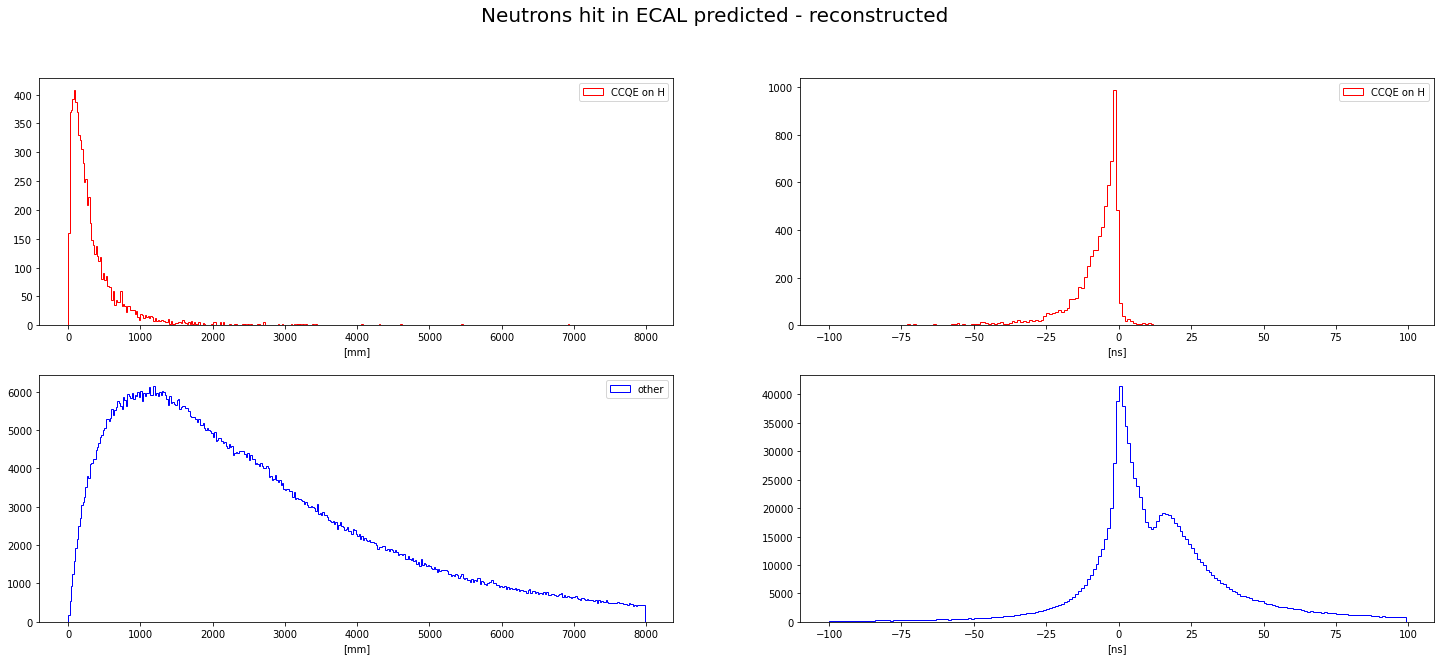

In [28]:
plotter = MultiPlotter(nrows=2, ncols=2, figsize=(25,10), suptitle="Neutrons hit in ECAL predicted - reconstructed")

plotter.plot_hist(
    data = neutron_signal_complete_fired_cells[neutron_signal_complete_fired_cells.CCQEonHydrogen==1].space_residuals,
    bins = np.arange(0, 8000, 20),
    label = "CCQE on H",
    color = "red",
    xlabel = "[mm]",
    ylabel = "",
    # ticks = [np.arange(0,8000,500)],
)

plotter.next_plot(plot_legend=True)

plotter.plot_hist(
    data = neutron_signal_complete_fired_cells[neutron_signal_complete_fired_cells.CCQEonHydrogen==1].time_residuals,
    bins = np.arange(-100, 100, 1),
    label = "CCQE on H",
    color = "red",
    xlabel = "[ns]",
    ylabel = "",
    # ticks = [np.arange(-100, 100, 1)],
)

plotter.next_plot(plot_legend=True)

plotter.plot_hist(
    data = fired_cells[fired_cells.CCQEonHydrogen==0].space_residuals,
    bins = np.arange(0, 8000, 20),
    label = "other",
    color = "blue",
    xlabel = "[mm]",
    ylabel = "",
    # ticks = [np.arange(0,8000,500)],
)

plotter.next_plot(plot_legend=True)

plotter.plot_hist(
    data = fired_cells[fired_cells.CCQEonHydrogen==0].time_residuals,
    bins = np.arange(-100, 100, 1),
    label = "other",
    color = "blue",
    xlabel = "[ns]",
    ylabel = "",
    # ticks = [np.arange(-100, 100, 1)],
)

prediction on the tof in ECAL

# Select signal

In [19]:
print(f"Number of all events signal (truth) {len(df_signal)}")
print(f"Number of all events background (truth) {len(df[df.CCQEonHydrogen==0])}")

Number of all events signal (truth) 2912
Number of all events background (truth) 35725


Select events with charge multiplicity == 1

In [25]:
df_1cp = df[df.NofFinalStateChargedParticles==1]
index_event_1cp = df_1cp.index.get_level_values(0)
primaries_1cp = primaries.loc[index_event_1cp]
# ci sono eventi che non alcuna cella del calorimetro accesa
common_indices = df_1cp.index.intersection(fired_cells.index)
fired_cells_events1cp = fired_cells.loc[common_indices]
fired_cells_events1cp

CCQEonHydrogen  \
FileName                                           EventId                   
events-in-SANDtracker.0.gtrac.root:gRooTracker:3   3                     0   
                                                   3                     0   
                                                   3                     0   
                                                   3                     0   
                                                   3                     0   
...                                                                    ...   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 999                   1   
                                                   999                   1   
                                                   999                   1   
                                                   999                   1   
                                                   999                   1   

                                                            Fired_Cells_mod  \
FileName                                           EventId                    
events-in-SANDtracker.0.gtrac.root:gRooTracker:3   3                     15   
                                                   3                     15   
                                                   3                     15   
                                                   3                     15   
                                                   3                     15   
...                                                                     ...   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 999                   15   
                                                   999                   15   
                                                   999                   15   
                                                   999                   15   
                                                   999                   15   

                                                            Fired_Cells_id  \
FileName                                           EventId                   
events-in-SANDtracker.0.gtrac.root:gRooTracker:3   3                215002   
                                                   3                215003   
                                                   3                215100   
                                                   3                215103   
                                                   3                215104   
...                                                                    ...   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 999              215203   
                                                   999              215302   
                                                   999              215303   
                                                   999              215403   
                                                   999              215404   

                                                            Fired_Cells_x  \
FileName                                           EventId                  
events-in-SANDtracker.0.gtrac.root:gRooTracker:3   3        -3.320746e-13   
                                                   3        -3.320746e-13   
                                                   3        -3.320746e-13   
                                                   3        -3.320746e-13   
                                                   3        -3.320746e-13   
...                                                                   ...   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 999      -3.320746e-13   
                                                   999      -3.320746e-13   
                                                   999      -3.320746e-13   
                                                   999      -3.320746e-13   
                                                   999      -3.320746e-13   



For the selected cut how many signal and background events? What are the efficiency of the cut and purity of the selected sample?

In [26]:
nof_events_1cp = len(df_1cp)
nof_signal_events_1cp = len(df_1cp[df_1cp.CCQEonHydrogen==1])
print(f"Number of events signal (truth) {nof_signal_events_1cp}, selection efficiency {nof_signal_events_1cp / tot_nof_neutrons_signal}, purity {nof_signal_events_1cp / nof_events_1cp}")
print(f"Number of events background (truth) {nof_events_1cp - nof_signal_events_1cp}")

Number of events signal (truth) 2912, selection efficiency 1.0, purity 0.21064814814814814
Number of events background (truth) 10912


Which events have 1 final state charged particle but are not signal?

Text(204.0, 0.5, 'Interaction Target')

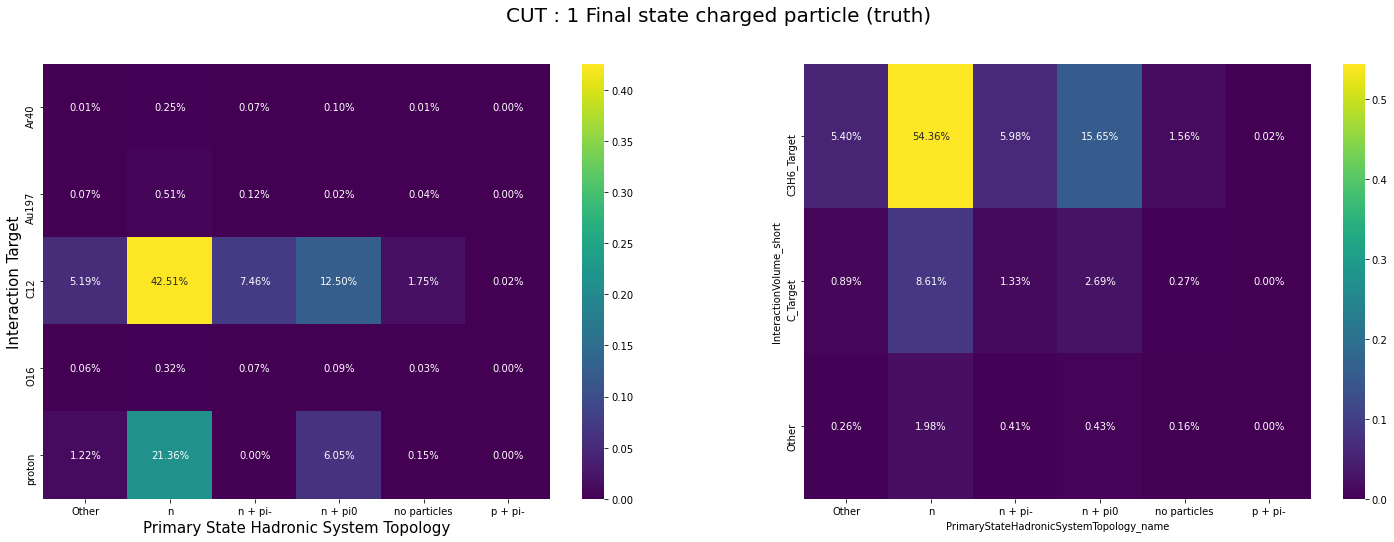

In [27]:
fig, ax = plt.subplots(1,2, figsize=(25, 8))

pivot_table_1cp = df_1cp.pivot_table(
    index='InteractionTarget',
    columns='PrimaryStateHadronicSystemTopology_name',
    values='NofFinalStateChargedParticles',
    aggfunc='count',
    fill_value=0
)

pivot_table_1cp_ = df_1cp.pivot_table(
    index='InteractionVolume_short',
    columns='PrimaryStateHadronicSystemTopology_name',
    values='NofFinalStateChargedParticles',
    aggfunc='count',
    fill_value=0
)

sns.heatmap(pivot_table_1cp/len(df_1cp), annot=True, fmt=".2%", cmap="viridis", ax=ax[0])

sns.heatmap(pivot_table_1cp_/len(df_1cp), annot=True, fmt=".2%", cmap="viridis", ax=ax[1])

plt.suptitle('CUT : 1 Final state charged particle (truth)', fontsize=20)
ax[0].set_xlabel('Primary State Hadronic System Topology', fontsize=15)
ax[0].set_ylabel('Interaction Target', fontsize=15)

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'Ar40'),
  Text(0, 1.5, 'Au197'),
  Text(0, 2.5, 'C12'),
  Text(0, 3.5, 'O16'),
  Text(0, 4.5, 'proton')])

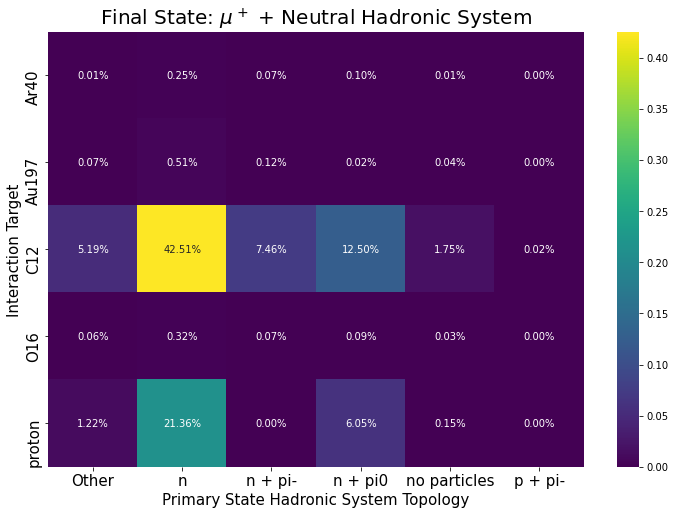

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))

pivot_table_1cp = df_1cp.pivot_table(
    index='InteractionTarget',
    columns='PrimaryStateHadronicSystemTopology_name',
    values='NofFinalStateChargedParticles',
    aggfunc='count',
    fill_value=0
)

sns.heatmap(pivot_table_1cp/len(df_1cp), annot=True, fmt=".2%", cmap="viridis")

plt.title(r'Final State: $\mu^+$ + Neutral Hadronic System', fontsize=20)
ax.set_xlabel('Primary State Hadronic System Topology', fontsize=15)
ax.set_ylabel('Interaction Target', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

Possible backgrounds : 
- CCQE on C :
    - $\overline{\nu}+p\rightarrow \mu^+ + n$

- CCRES on C:
    - $\overline{\nu}+n \rightarrow \mu^+ + \Delta^- \rightarrow \mu^+ + n + \pi^-$ 
    - $\overline{\nu}+p \rightarrow \mu^+ + \Delta^0 \rightarrow \mu^+ + n + \pi^0$ ($\pi^0$ absorbed or 2 photons )

- CCRES on H:
    - $\overline{\nu}+p \rightarrow \mu^+ + \Delta^0 \rightarrow \mu^+ + n + \pi^0$

For the selected events, let's look at the kinematic

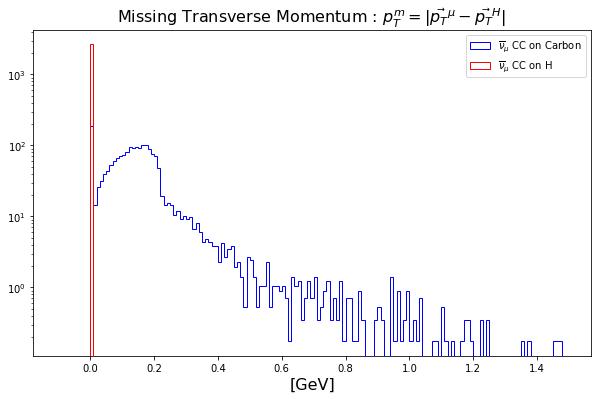

In [56]:
ratio_C12_H = 311685 / 55008

fig, ax = plt.subplots(figsize=(10, 6))

plt.hist(x=df_1cp[df_1cp.CCQEonHydrogen==0]['MissingTransverseMomentum'], 
         weights=np.array([1/ratio_C12_H for i in range(len(df_1cp[df_1cp.CCQEonHydrogen==0]['MissingTransverseMomentum']))]),
         bins=np.arange(-0.1,1.5,0.01), 
         histtype='step', color = 'blue', label=r'$\overline{\nu}_\mu$ CC on Carbon')

plt.hist(x=df_1cp[df_1cp.CCQEonHydrogen==1]['MissingTransverseMomentum'], 
         bins=np.arange(-0.1,1.5,0.01), 
         histtype='step', color = 'red', label=r'$\overline{\nu}_\mu$ CC on H')

plt.legend()

plt.title(r"Missing Transverse Momentum : $p_T^m = |\vec{p_T}^\mu - \vec{p_T}^H|$", fontsize=16)
plt.xlabel("[GeV]", fontsize=16)

plt.yscale("log")

Main source of background is CCQE events on C. For these evens we expect the kinematic to be different, namely the neutron should have a different beta because of the fermi motion

Of the remaining sample os signal, how many times my prediction on the arrival point in the ECAL and its tof is correct?

I need to find a cut on the space to define a "coincidence" between predicted hit in ECAL and reconstructed hits form cells

In [30]:
df_signal_left = df_1cp[df_1cp.CCQEonHydrogen==1]
df_bkg_left = df_1cp[df_1cp.CCQEonHydrogen==0]

How many time an event that has the expected fired module has also a reconstructed time compaticble with the expected tof?

In [31]:
complete_fired_cells_1cp = fired_cells_events1cp[fired_cells_events1cp.isCellComplete==1]
incomplete_fired_cells_1cp = fired_cells_events1cp[fired_cells_events1cp.isCellComplete==0]

In [32]:
selected_events_complete_fired_cells_1cp =  complete_fired_cells_1cp[
    (complete_fired_cells_1cp.Fired_Cells_mod == complete_fired_cells_1cp.ExpectedFiredModuleByNeutron) &
    (complete_fired_cells_1cp.space_residuals <= 250) & 
    (abs(complete_fired_cells_1cp.time_residuals) <= 10)
    ]

In [55]:
selected_events_complete_fired_cells_1cp

CCQEonHydrogen  \
FileName                                           EventId                   
events-in-SANDtracker.0.gtrac.root:gRooTracker:61  61                    1   
events-in-SANDtracker.0.gtrac.root:gRooTracker:105 105                   1   
events-in-SANDtracker.0.gtrac.root:gRooTracker:161 161                   1   
events-in-SANDtracker.0.gtrac.root:gRooTracker:228 228                   0   
events-in-SANDtracker.0.gtrac.root:gRooTracker:348 348                   1   
...                                                                    ...   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 765                   1   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 808                   0   
                                                   808                   0   
                                                   808                   0   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 812                   0   

                                                            Fired_Cells_mod  \
FileName                                           EventId                    
events-in-SANDtracker.0.gtrac.root:gRooTracker:61  61                    18   
events-in-SANDtracker.0.gtrac.root:gRooTracker:105 105                    0   
events-in-SANDtracker.0.gtrac.root:gRooTracker:161 161                   15   
events-in-SANDtracker.0.gtrac.root:gRooTracker:228 228                   19   
events-in-SANDtracker.0.gtrac.root:gRooTracker:348 348                   15   
...                                                                     ...   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 765                   40   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 808                    1   
                                                   808                    1   
                                                   808                    1   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 812                   15   

                                                            Fired_Cells_id  \
FileName                                           EventId                   
events-in-SANDtracker.0.gtrac.root:gRooTracker:61  61               218102   
events-in-SANDtracker.0.gtrac.root:gRooTracker:105 105              200204   
events-in-SANDtracker.0.gtrac.root:gRooTracker:161 161              215210   
events-in-SANDtracker.0.gtrac.root:gRooTracker:228 228              219406   
events-in-SANDtracker.0.gtrac.root:gRooTracker:348 348              215008   
...                                                                    ...   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 765              140474   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 808              201000   
                                                   808              201007   
                                                   808              201106   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 812              215407   

                                                            Fired_Cells_x  \
FileName                                           EventId                  
events-in-SANDtracker.0.gtrac.root:gRooTracker:61  61       -1.042776e-28   
events-in-SANDtracker.0.gtrac.root:gRooTracker:105 105       4.696243e-13   
events-in-SANDtracker.0.gtrac.root:gRooTracker:161 161      -3.320746e-13   
events-in-SANDtracker.0.gtrac.root:gRooTracker:228 228       1.215477e-13   
events-in-SANDtracker.0.gtrac.root:gRooTracker:348 348      -3.320746e-13   
...                                                                   ...   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 765      -1.893000e+03   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 808       4.536223e-13   
                                                   808       4.536223e-13   
                                                   808       4.536223e-13   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 812      -3.320746e-13   



In [34]:
selected_file_names = selected_events_complete_fired_cells_1cp.index.get_level_values(0).unique()

# Create a boolean mask using the 'FileName' level of df_1cp's index
mask = df_1cp.index.get_level_values(0).isin(selected_file_names)

# Use the mask to select the corresponding rows
selected_events = df_1cp[mask]

# Display the selected events
selected_events

,,EventType,CCQEonHydrogen,Interaction_vtxX,Interaction_vtxY,Interaction_vtxZ,InteractionTarget,InteractionVolume,PrimaryStateHadronicSystemTopology_name,NofFinalStateChargedParticles,PrimaryStateHadronicSystemTotalKinE,...,ExpectedNeutronArrivalPositionECALfY,ExpectedNeutronArrivalPositionECALfZ,ExpectedFiredModuleByNeutron,InteractionVolume_short,dist_Vtx2ECAL,ExpectedHadronSystPtot,ExpectedNeutronE,ExpectedNeutronGamma,ExpectedNeutronBeta,ExpectedNeutronCrossingTimeECAL
FileName,EventId,,,,,,,,,,,,,,,,,,,,,
events-in-SANDtracker.0.gtrac.root:gRooTracker:61,61,QES,1,0.422471,-2.686012,24.264480,proton,C3H6Target_A,n,1,0.511221,...,-2550.012686,25976.808179,18,C3H6_Target,2655.789816,1105.446940,1450.791543,1.544109,0.761961,11.618219
events-in-SANDtracker.0.gtrac.root:gRooTracker:105,105,QES,1,1.459176,-1.017790,23.689375,proton,C3H6Target_A,n,1,0.047697,...,-277.521351,23969.107642,0,C3H6_Target,793.429860,303.158766,987.263087,1.050766,0.307070,8.612913
events-in-SANDtracker.0.gtrac.root:gRooTracker:161,161,QES,1,0.670199,-2.331946,24.266286,proton,C3H6Target_A,n,1,0.152955,...,-3743.958114,25527.805391,15,C3H6_Target,1906.123171,557.516720,1092.523711,1.162797,0.510302,12.450955
events-in-SANDtracker.0.gtrac.root:gRooTracker:228,228,RES,0,0.316472,-2.260742,25.355607,proton,C3H6Target_X1,n,1,2.179114,...,-2001.168538,25977.159986,19,C3H6_Target,738.305412,1582.475295,1840.383445,1.958760,0.859862,2.862109
events-in-SANDtracker.0.gtrac.root:gRooTracker:348,348,QES,1,-0.278116,-2.428885,24.157082,proton,C3H6Target_A,n,1,0.937701,...,-3731.778593,25534.783455,15,C3H6_Target,1967.930475,1625.231628,1877.274889,1.998025,0.865740,7.577067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
events-in-SANDtracker.99.gtrac.root:gRooTracker:656,656,QES,0,1.477218,-2.416844,24.228469,C12,C3H6Target_A,n,1,0.577267,...,-2310.921252,24479.752079,30,C3H6_Target,403.618330,1059.112577,1415.804582,1.506872,0.748064,1.798502
events-in-SANDtracker.99.gtrac.root:gRooTracker:665,665,DIS,0,0.374366,-0.851021,24.451585,C12,C3H6Target_B,n + pi0,1,2.254204,...,-523.238813,24833.501944,22,C3H6_Target,680.930258,760.027311,1208.480318,1.286212,0.628912,3.609041
events-in-SANDtracker.99.gtrac.root:gRooTracker:765,765,QES,1,0.228943,-2.112582,23.723683,proton,C3H6Target_A,n,1,0.287682,...,-1469.113770,25043.333906,40,C3H6_Target,2490.585894,789.530938,1227.249880,1.306189,0.643333,12.904587


Text(204.0, 0.5, 'Interaction Target')

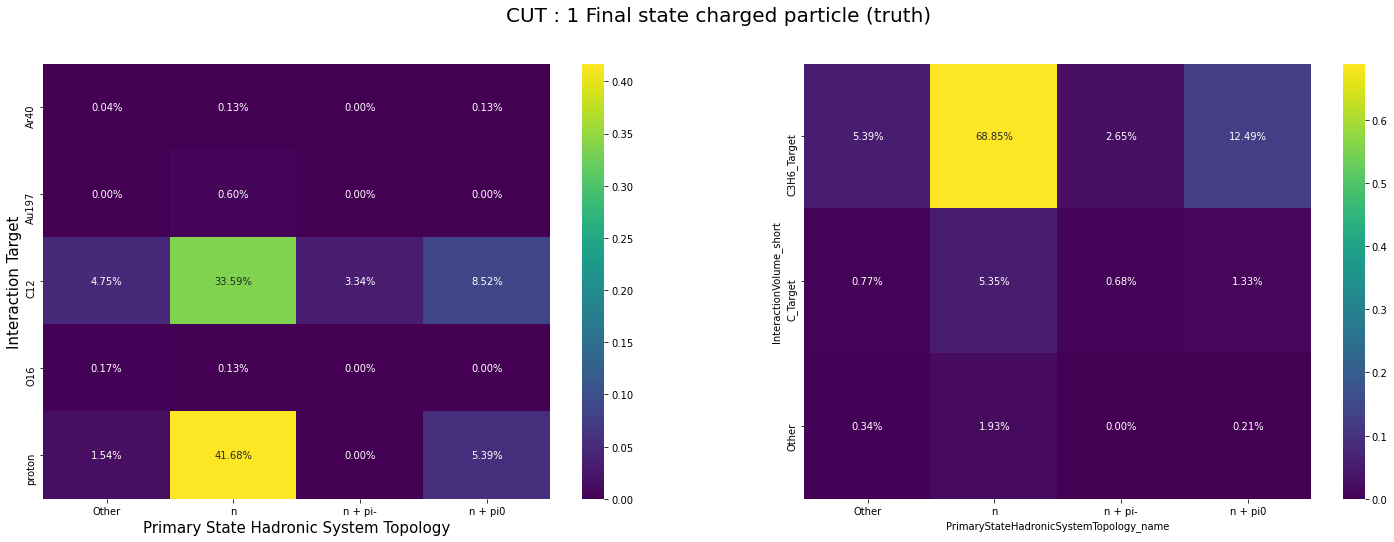

In [35]:
fig, ax = plt.subplots(1,2, figsize=(25, 8))

pivot_table_1cp = selected_events.pivot_table(
    index='InteractionTarget',
    columns='PrimaryStateHadronicSystemTopology_name',
    values='NofFinalStateChargedParticles',
    aggfunc='count',
    fill_value=0
)

pivot_table_1cp_ = selected_events.pivot_table(
    index='InteractionVolume_short',
    columns='PrimaryStateHadronicSystemTopology_name',
    values='NofFinalStateChargedParticles',
    aggfunc='count',
    fill_value=0
)

sns.heatmap(pivot_table_1cp/len(selected_events), annot=True, fmt=".2%", cmap="viridis", ax=ax[0])

sns.heatmap(pivot_table_1cp_/len(selected_events), annot=True, fmt=".2%", cmap="viridis", ax=ax[1])

plt.suptitle('CUT : 1 Final state charged particle (truth)', fontsize=20)
ax[0].set_xlabel('Primary State Hadronic System Topology', fontsize=15)
ax[0].set_ylabel('Interaction Target', fontsize=15)

In [36]:
nof_selected_events = len(selected_events)
nof_selected_events_signal = len(selected_events[selected_events.CCQEonHydrogen==1])
print(f"Number of events signal (truth) {nof_signal_events_1cp}, selection efficiency {nof_selected_events_signal / tot_nof_neutrons_signal}, purity {nof_selected_events_signal / nof_selected_events}")

Number of events signal (truth) 2912, selection efficiency 0.33379120879120877, purity 0.4159178433889602


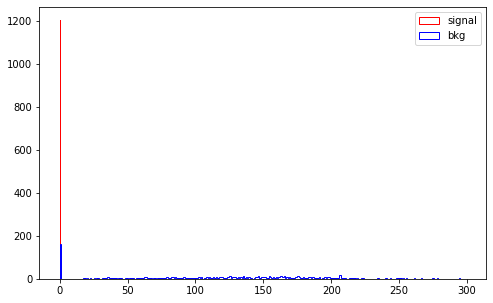

In [109]:
fig, ax = plt.subplots(figsize=(8,5))

ax.hist(x = selected_events[selected_events.CCQEonHydrogen==1].MissingTransverseMomentum*1e3 ,
        histtype='step', label='signal', color='red')

ax.hist(x = selected_events[selected_events.CCQEonHydrogen==0].MissingTransverseMomentum*1e3,
        histtype='step', label='bkg', color='blue', bins=np.arange(0,300,1))

ax.legend()

In [71]:
selected_events[selected_events.InteractionTarget=='C12']

,,EventType,CCQEonHydrogen,Interaction_vtxX,Interaction_vtxY,Interaction_vtxZ,InteractionTarget,InteractionVolume,PrimaryStateHadronicSystemTopology_name,NofFinalStateChargedParticles,PrimaryStateHadronicSystemTotalKinE,...,ExpectedNeutronArrivalPositionECALfY,ExpectedNeutronArrivalPositionECALfZ,ExpectedFiredModuleByNeutron,InteractionVolume_short,dist_Vtx2ECAL,ExpectedHadronSystPtot,ExpectedNeutronE,ExpectedNeutronGamma,ExpectedNeutronBeta,ExpectedNeutronCrossingTimeECAL
FileName,EventId,,,,,,,,,,,,,,,,,,,,,
events-in-SANDtracker.0.gtrac.root:gRooTracker:391,391,QES,0,-0.953176,-3.240428,23.428837,C12,C3H6Target_B,n,1,0.384553,...,-3524.658999,24577.560476,40,C3H6_Target,1429.139485,1052.017030,1410.504519,1.501231,0.745844,6.387120
events-in-SANDtracker.0.gtrac.root:gRooTracker:537,537,QES,0,0.050329,-3.760744,24.486421,C12,C3H6Target_B,n,1,0.351700,...,-4305.367301,24750.897915,14,C3H6_Target,719.780545,743.540522,1198.180151,1.275249,0.620558,3.866307
events-in-SANDtracker.0.gtrac.root:gRooTracker:565,565,QES,0,-0.796216,-2.837410,25.300117,C12,C3H6Mylar_X1,n,1,0.219098,...,-2694.918533,25834.231217,40,Other,1137.630488,604.751446,1117.366313,1.189237,0.541229,7.006460
events-in-SANDtracker.0.gtrac.root:gRooTracker:620,620,QES,0,0.240896,-3.775777,24.815641,C12,C3H6Target_C,n,1,0.181315,...,-4209.223802,24973.676178,14,C3H6_Target,466.144512,552.047980,1089.743152,1.159837,0.506585,3.067232
events-in-SANDtracker.0.gtrac.root:gRooTracker:623,623,QES,0,-0.723937,-2.943373,25.723201,C12,C3H6Target_X0,n,1,0.167846,...,-2636.487383,25928.277896,18,C3H6_Target,541.564212,479.705119,1054.940836,1.122797,0.454722,3.969926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
events-in-SANDtracker.99.gtrac.root:gRooTracker:597,597,QES,0,0.990842,-2.761782,25.756220,C12,C3H6Target_X0,n,1,0.336482,...,-2943.418398,25885.093572,17,C3H6_Target,376.013696,551.403213,1089.416664,1.159490,0.506145,2.476322
events-in-SANDtracker.99.gtrac.root:gRooTracker:656,656,QES,0,1.477218,-2.416844,24.228469,C12,C3H6Target_A,n,1,0.577267,...,-2310.921252,24479.752079,30,C3H6_Target,403.618330,1059.112577,1415.804582,1.506872,0.748064,1.798502
events-in-SANDtracker.99.gtrac.root:gRooTracker:665,665,DIS,0,0.374366,-0.851021,24.451585,C12,C3H6Target_B,n + pi0,1,2.254204,...,-523.238813,24833.501944,22,C3H6_Target,680.930258,760.027311,1208.480318,1.286212,0.628912,3.609041


In [60]:
selected_events_complete_fired_cells_1cp

CCQEonHydrogen  \
FileName                                           EventId                   
events-in-SANDtracker.0.gtrac.root:gRooTracker:61  61                    1   
events-in-SANDtracker.0.gtrac.root:gRooTracker:105 105                   1   
events-in-SANDtracker.0.gtrac.root:gRooTracker:161 161                   1   
events-in-SANDtracker.0.gtrac.root:gRooTracker:228 228                   0   
events-in-SANDtracker.0.gtrac.root:gRooTracker:348 348                   1   
...                                                                    ...   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 765                   1   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 808                   0   
                                                   808                   0   
                                                   808                   0   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 812                   0   

                                                            Fired_Cells_mod  \
FileName                                           EventId                    
events-in-SANDtracker.0.gtrac.root:gRooTracker:61  61                    18   
events-in-SANDtracker.0.gtrac.root:gRooTracker:105 105                    0   
events-in-SANDtracker.0.gtrac.root:gRooTracker:161 161                   15   
events-in-SANDtracker.0.gtrac.root:gRooTracker:228 228                   19   
events-in-SANDtracker.0.gtrac.root:gRooTracker:348 348                   15   
...                                                                     ...   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 765                   40   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 808                    1   
                                                   808                    1   
                                                   808                    1   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 812                   15   

                                                            Fired_Cells_id  \
FileName                                           EventId                   
events-in-SANDtracker.0.gtrac.root:gRooTracker:61  61               218102   
events-in-SANDtracker.0.gtrac.root:gRooTracker:105 105              200204   
events-in-SANDtracker.0.gtrac.root:gRooTracker:161 161              215210   
events-in-SANDtracker.0.gtrac.root:gRooTracker:228 228              219406   
events-in-SANDtracker.0.gtrac.root:gRooTracker:348 348              215008   
...                                                                    ...   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 765              140474   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 808              201000   
                                                   808              201007   
                                                   808              201106   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 812              215407   

                                                            Fired_Cells_x  \
FileName                                           EventId                  
events-in-SANDtracker.0.gtrac.root:gRooTracker:61  61       -1.042776e-28   
events-in-SANDtracker.0.gtrac.root:gRooTracker:105 105       4.696243e-13   
events-in-SANDtracker.0.gtrac.root:gRooTracker:161 161      -3.320746e-13   
events-in-SANDtracker.0.gtrac.root:gRooTracker:228 228       1.215477e-13   
events-in-SANDtracker.0.gtrac.root:gRooTracker:348 348      -3.320746e-13   
...                                                                   ...   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 765      -1.893000e+03   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 808       4.536223e-13   
                                                   808       4.536223e-13   
                                                   808       4.536223e-13   
events-in-SANDtracker.99.gtrac.root:gRooTracker... 812      -3.320746e-13   



# selected signal events

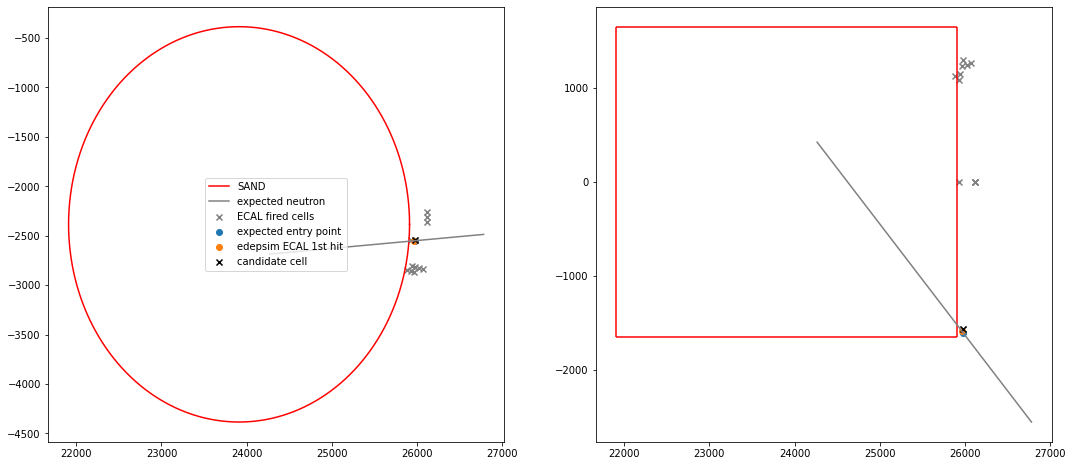

In [57]:

plotEvent(selected_events.loc['events-in-SANDtracker.0.gtrac.root:gRooTracker:61'], 
          primaries_1cp.loc['events-in-SANDtracker.0.gtrac.root:gRooTracker:61'],
          fired_cells_events1cp.loc['events-in-SANDtracker.0.gtrac.root:gRooTracker:61'], 
          selected_events_complete_fired_cells_1cp.loc['events-in-SANDtracker.0.gtrac.root:gRooTracker:61'])

# background included in the selection

In [64]:
selected_events.loc['events-in-SANDtracker.0.gtrac.root:gRooTracker:228']

,EventType,CCQEonHydrogen,Interaction_vtxX,Interaction_vtxY,Interaction_vtxZ,InteractionTarget,InteractionVolume,PrimaryStateHadronicSystemTopology_name,NofFinalStateChargedParticles,PrimaryStateHadronicSystemTotalKinE,...,ExpectedNeutronArrivalPositionECALfY,ExpectedNeutronArrivalPositionECALfZ,ExpectedFiredModuleByNeutron,InteractionVolume_short,dist_Vtx2ECAL,ExpectedHadronSystPtot,ExpectedNeutronE,ExpectedNeutronGamma,ExpectedNeutronBeta,ExpectedNeutronCrossingTimeECAL
EventId,,,,,,,,,,,,,,,,,,,,,
228,RES,0,0.316472,-2.260742,25.355607,proton,C3H6Target_X1,n,1,2.179114,...,-2001.168538,25977.159986,19,C3H6_Target,738.305412,1582.475295,1840.383445,1.95876,0.859862,2.862109


In [65]:
primaries_1cp.loc['events-in-SANDtracker.0.gtrac.root:gRooTracker:228']

,EventType,CCQEonHydrogen,Interaction_vtxX,Interaction_vtxY,Interaction_vtxZ,Interaction_vtxT,PDG,TrackId,Px,Py,...,PrimariesFirstHitECAL_t,PrimariesEDepECAL,PrimariesEmissionAngle,HasNoECALHit,HasChangedDirection,mass,E_kin,gamma,beta,dist_Vtx2ECAL
EventId,,,,,,,,,,,,,,,,,,,,,
228,RES,0,0.316472,-2.260742,25.355607,9.573733e-09,-13,0,647.517476,-789.857531,...,3.568565,38.075291,0.734376,0,0,105.658374,1308.199037,13.381404,0.997204,767.597027
228,RES,0,0.316472,-2.260742,25.355607,9.573733e-09,2112,1,-525.007711,142.975207,...,3.278797,168.844354,0.348242,0,0,939.565413,1084.275695,2.154018,0.885705,556.562718
228,RES,0,0.316472,-2.260742,25.355607,9.573733e-09,22,2,-244.047582,293.473780,...,3.635871,103.456144,0.988636,0,0,0.000000,483.595689,inf,1.000000,790.214299
228,RES,0,0.316472,-2.260742,25.355607,9.573733e-09,22,3,120.851852,-8.976563,...,2.899102,104.713279,0.216711,0,0,0.000000,611.427182,inf,1.000000,569.335923


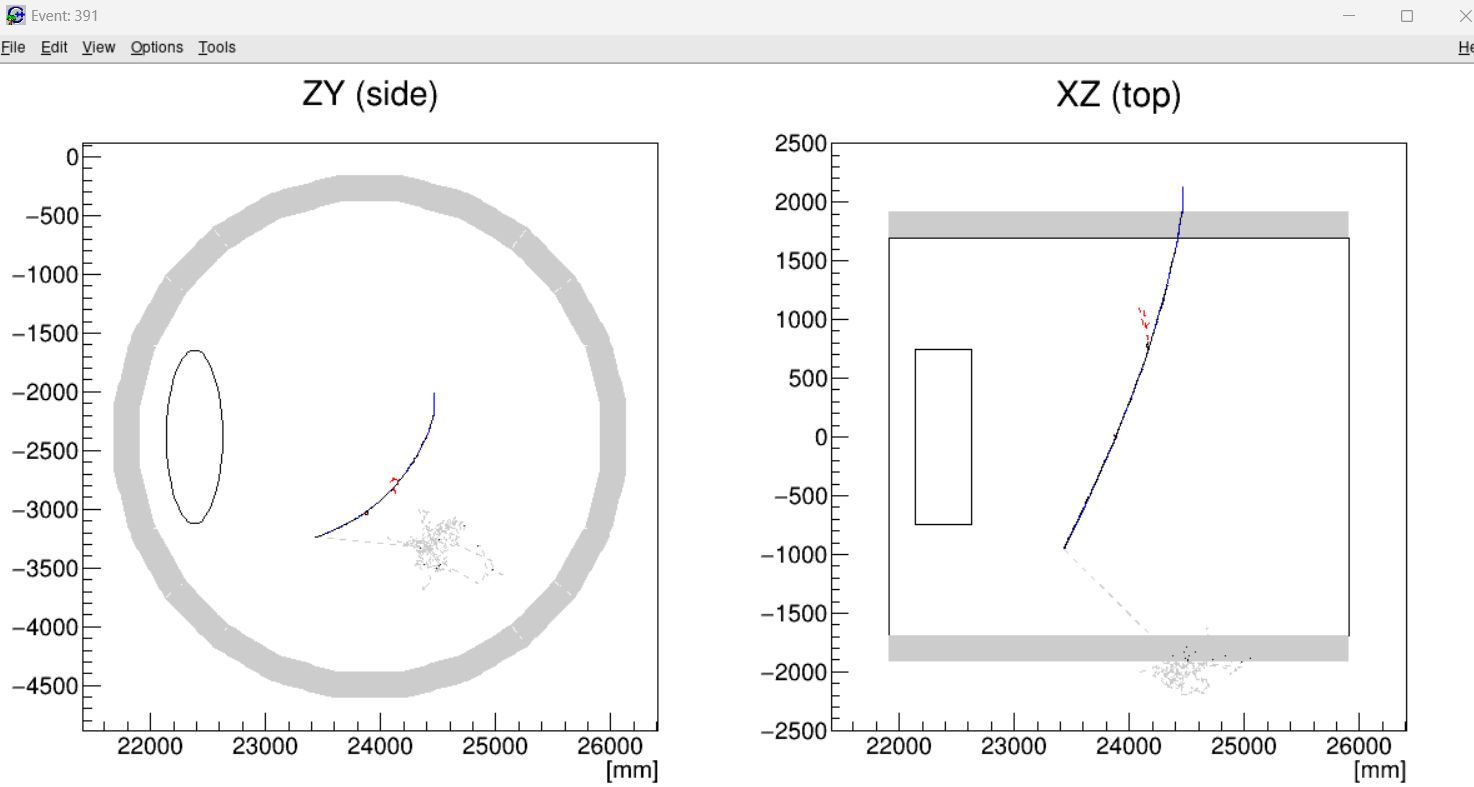

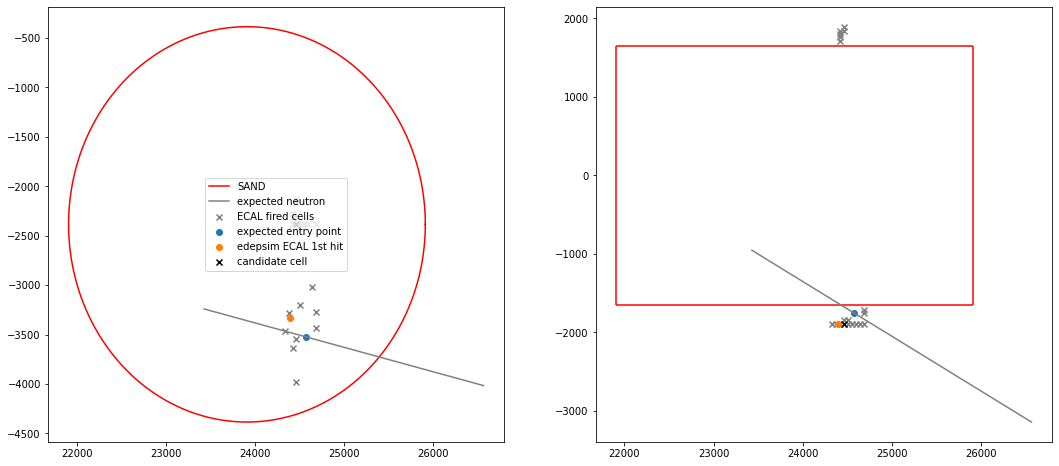

In [72]:

plotEvent(selected_events.loc['events-in-SANDtracker.0.gtrac.root:gRooTracker:391'], 
          primaries_1cp.loc['events-in-SANDtracker.0.gtrac.root:gRooTracker:391'],
          fired_cells_events1cp.loc['events-in-SANDtracker.0.gtrac.root:gRooTracker:391'], 
          selected_events_complete_fired_cells_1cp.loc['events-in-SANDtracker.0.gtrac.root:gRooTracker:391'])

# event 957

/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


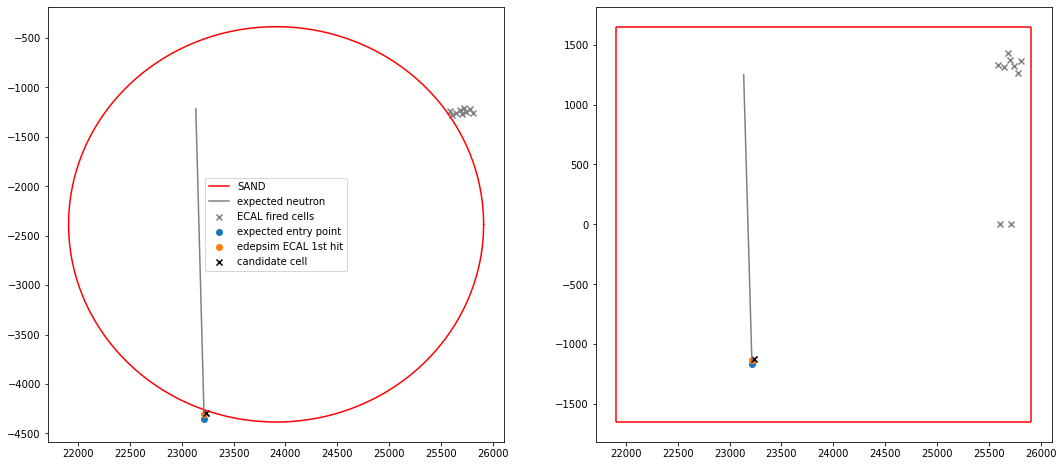

In [16]:
f957 = GetCandidateCell(957)

plotEvent(f957['test_event'], 
          f957['tests_event_primaries'],
          f957['test_event_fired_cells'], 
          f957['best_fired_cell'])

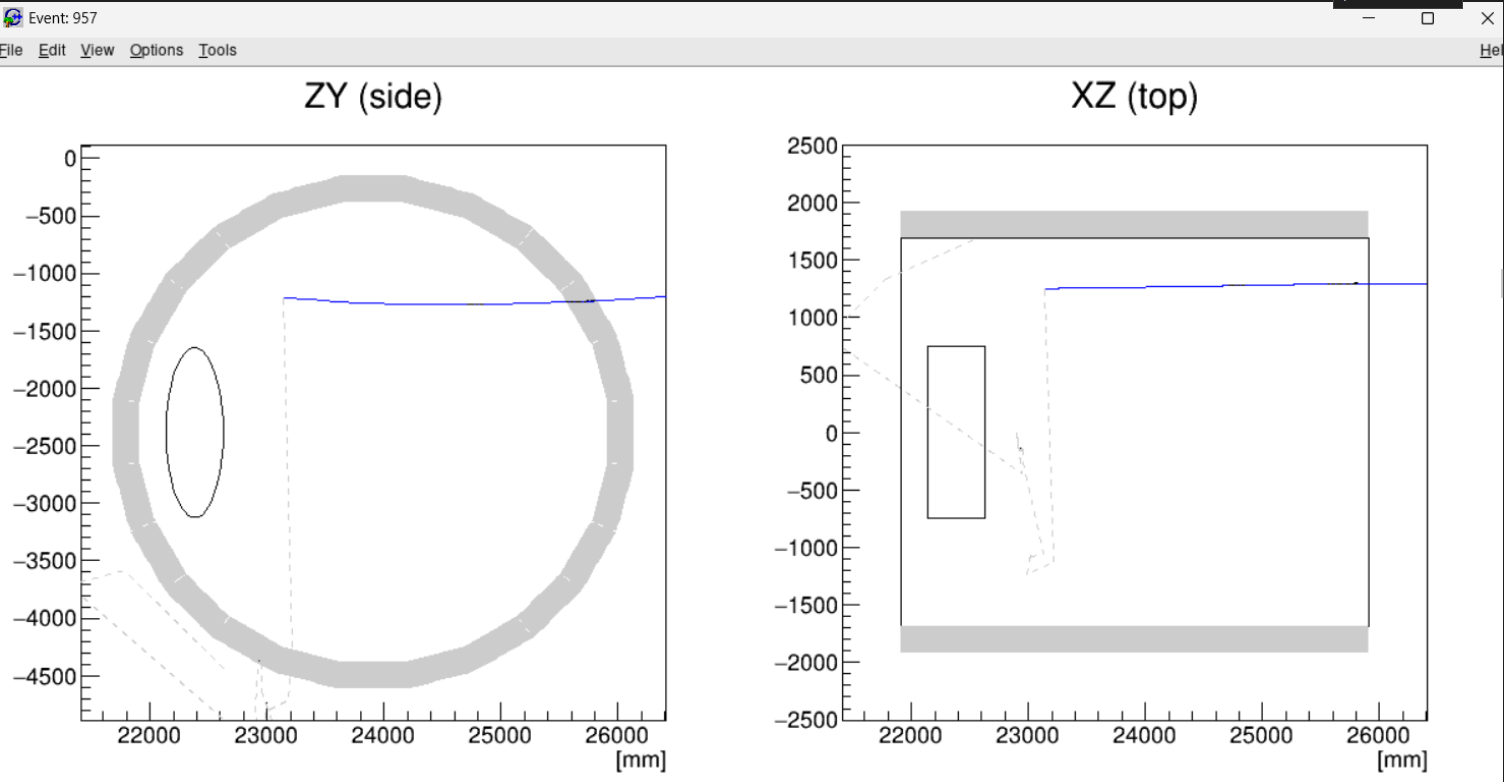

In [22]:
f957['test_event_fired_cells']

FileName  EventId  \
entry subentry                                                               
10    0         events-in-SANDtracker.2.gtrac.root:gRooTracker...      957   
      1         events-in-SANDtracker.2.gtrac.root:gRooTracker...      957   
      2         events-in-SANDtracker.2.gtrac.root:gRooTracker...      957   
      3         events-in-SANDtracker.2.gtrac.root:gRooTracker...      957   
      4         events-in-SANDtracker.2.gtrac.root:gRooTracker...      957   
      5         events-in-SANDtracker.2.gtrac.root:gRooTracker...      957   
      6         events-in-SANDtracker.2.gtrac.root:gRooTracker...      957   
      7         events-in-SANDtracker.2.gtrac.root:gRooTracker...      957   
      8         events-in-SANDtracker.2.gtrac.root:gRooTracker...      957   
      9         events-in-SANDtracker.2.gtrac.root:gRooTracker...      957   

                Fired_Cells_mod  Fired_Cells_id  Fired_Cells_x  Fired_Cells_y  \
entry subentry                                                                  
10    0                      11          211002  -4.536223e-13   -4297.755233   
      1                      20          220008   2.348122e-13   -1277.944609   
      2                      20          220009   2.348122e-13   -1239.630453   
      3                      20          220108   2.348122e-13   -1253.852970   
      4                      20          220207   2.348122e-13   -1269.748798   
      5                      20          220208   2.348122e-13   -1229.761330   
      6                      20          220307   2.348122e-13   -1246.493814   
      7                      20          220308   2.348122e-13   -1205.669691   
      8                      20          220406   2.348122e-13   -1262.352073   
      9                      20          220407   2.348122e-13   -1220.596219   

                Fired_Cells_z  isCellComplete  Fired_Cells_tdc1  \
entry subentry                                                    
10    0          23237.099281               1        138.482773   
      1          25605.801645               0         14.383725   
      2          25583.680957               1         15.120925   
      3          25642.699155               1         15.236414   
      4          25702.683439               1         15.350859   
      5          25679.596664               1         14.488866   
      6          25740.063991               1         15.221426   
      7          25716.494173               0         14.651300   
      8          25805.800088               1         16.004390   
      9          25781.692334               1         16.063977   

                Fired_Cells_tdc2    hit_reco_x   hit_reco_y    hit_reco_z  \
entry subentry                                                              
10    0               125.342246 -1.123122e+03 -4297.755233  23237.099281   
      1                 0.000000  2.348122e-13 -1277.944609  25605.801645   
      2                30.660619  1.328179e+03 -1239.630453  25583.680957   
      3                30.580800  1.311486e+03 -1253.852970  25642.699155   
      4                31.370500  1.369200e+03 -1269.748798  25702.683439   
      5                31.178795  1.426490e+03 -1229.761330  25679.596664   
      6                30.687841  1.321916e+03 -1246.493814  25740.063991   
      7                 0.000000  2.348122e-13 -1205.669691  25716.494173   
      8                31.914023  1.359798e+03 -1262.352073  25805.800088   
      9                30.863997  1.264959e+03 -1220.596219  25781.692334   

                hit_reco_t  STDistToNeutronExpectedHit  space_time_distance2  \
entry subentry                                                                 
10    0         119.335010                1.251854e+04         -6.467653e+03   
      1         -12.577500                1.557950e+09         -1.555961e+09   
      2          10.313272                1.055446e+09         -1.053802e+09   
      3          

# event 927

/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


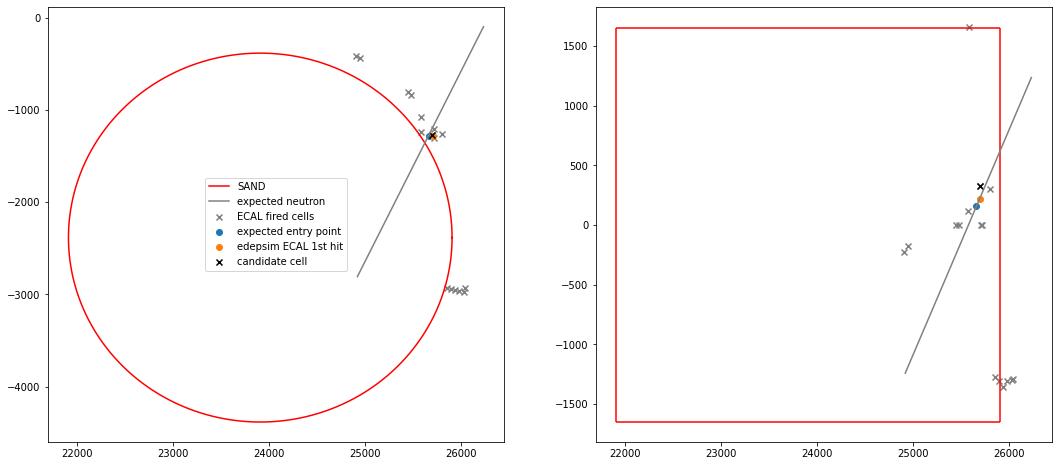

In [25]:
f927 = GetCandidateCell(927)

plotEvent(f927['test_event'], 
          f927['tests_event_primaries'],
          f927['test_event_fired_cells'], 
          f927['best_fired_cell'])

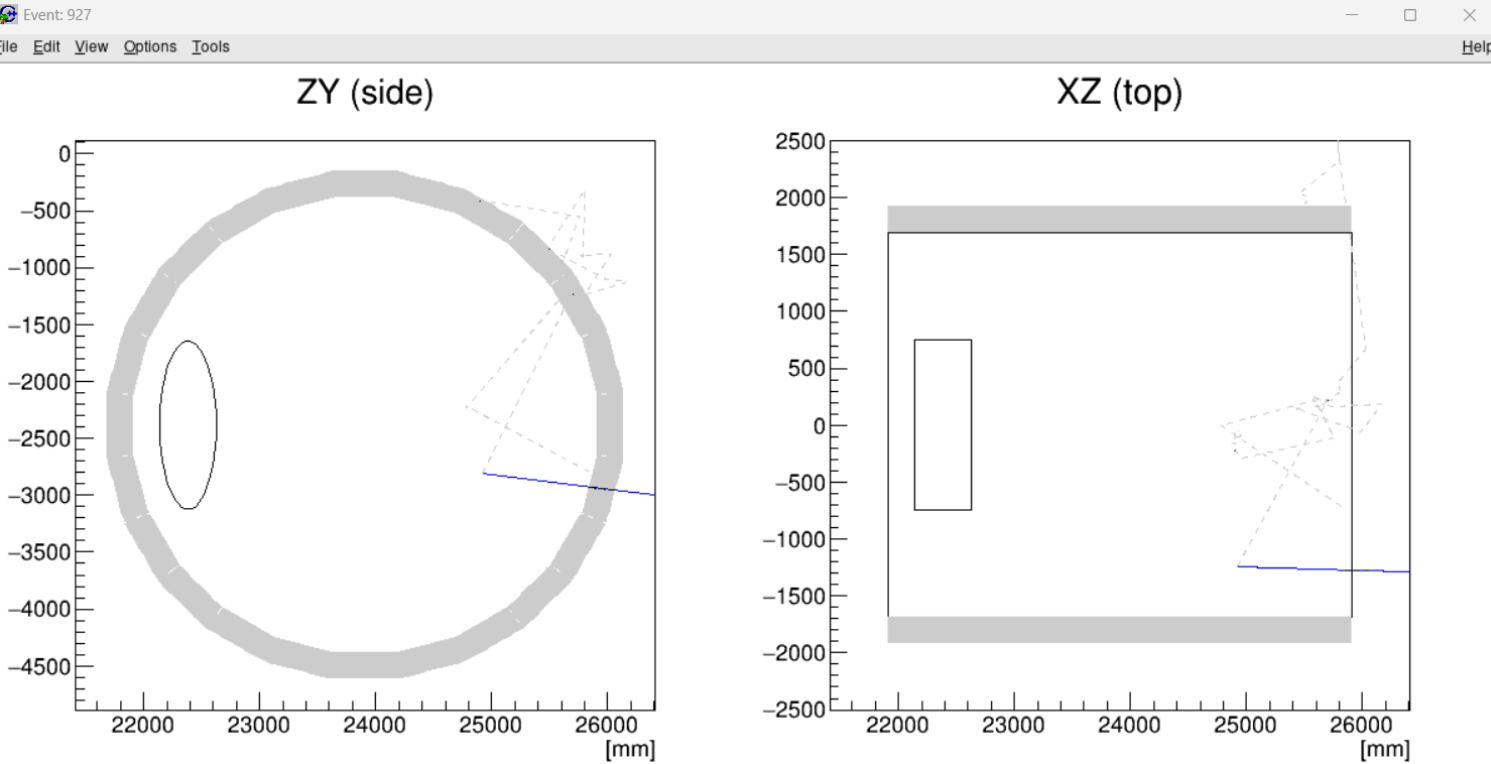

In [27]:
f927['test_event_fired_cells']

FileName  EventId  \
entry subentry                                                               
1     0         events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      1         events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      2         events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      3         events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      4         events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      5         events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      6         events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      7         events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      8         events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      9         events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      10        events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      11        events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      12        events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      13        events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      14        events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   
      15        events-in-SANDtracker.2.gtrac.root:gRooTracker...      927   

                Fired_Cells_mod  Fired_Cells_id  Fired_Cells_x  Fired_Cells_y  \
entry subentry                                                                  
1     0                      17          217005  -1.215477e-13   -2929.429053   
      1                      17          217105  -1.215477e-13   -2941.283676   
      2                      17          217205  -1.215477e-13   -2953.138298   
      3                      17          217305  -1.215477e-13   -2964.992920   
      4                      17          217405  -1.215477e-13   -2978.194658   
      5                      17          217406  -1.215477e-13   -2931.622055   
      6                      20          220009   2.348122e-13   -1239.630453   
      7                      20          220206   2.348122e-13   -1309.736266   
      8                      20          220207   2.348122e-13   -1269.748798   
      9                      20          220308   2.348122e-13   -1205.669691   
      10                     20          220406   2.348122e-13   -1262.352073   
      11                     21          221200   3.320746e-13   -1072.307661   
      12                     21          221405   3.320746e-13    -844.020517   
      13                     21          221406   3.320746e-13    -809.927005   
      14                     22          222407   4.067066e-13    -440.714405   
      15                     22          222408   4.067066e-13    -416.606651   

                Fired_Cells_z  isCellComplete  Fired_Cells_tdc1  \
entry subentry                                                    
1     0          25857.376765               1         25.127447   
      1          25899.752481               1         25.639552   
      2          25942.128196               1         25.982642   
      3          25984.503912               1         26.140111   
      4          26031.695050               1         26.174812   
      5          26044.174141               1         25.996730   
      6          25583.680957               1         41.280563   
      7          25725.770214               0         29.392821   
      8          25702.683439               1         30.380584   
      9          25716.494173               0         31.622960   
      10         25805.800088               1         31.516097   
      11         25581.568278               1         39.108644   
      12         25484.802995               0        316.808993   
      13         25450.709483               0          0.000000   
      14         24948.866219               1        121.065094   
      15         24907.110365               1        1

# event 6

/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


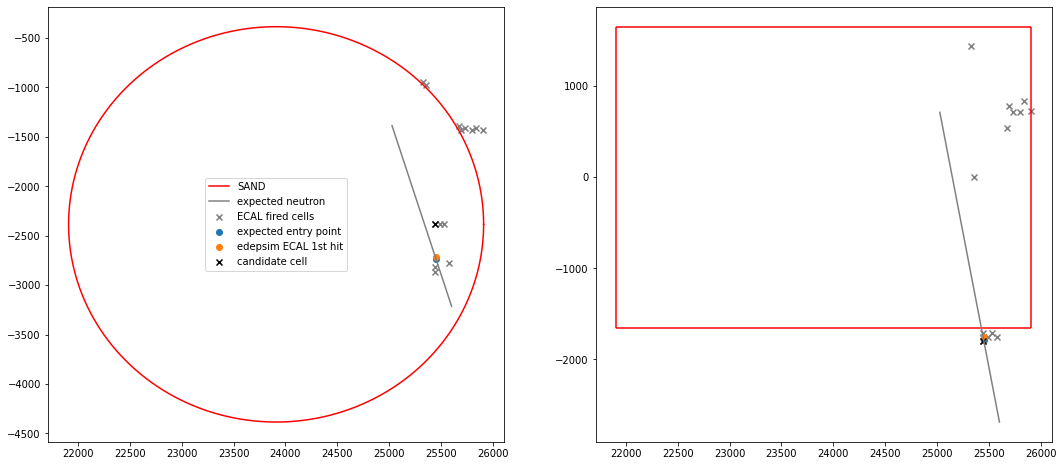

In [12]:
f6 = GetCandidateCell(6)

plotEvent(f6['test_event'], 
          f6['tests_event_primaries'],
          f6['test_event_fired_cells'], 
          f6['best_fired_cell'])

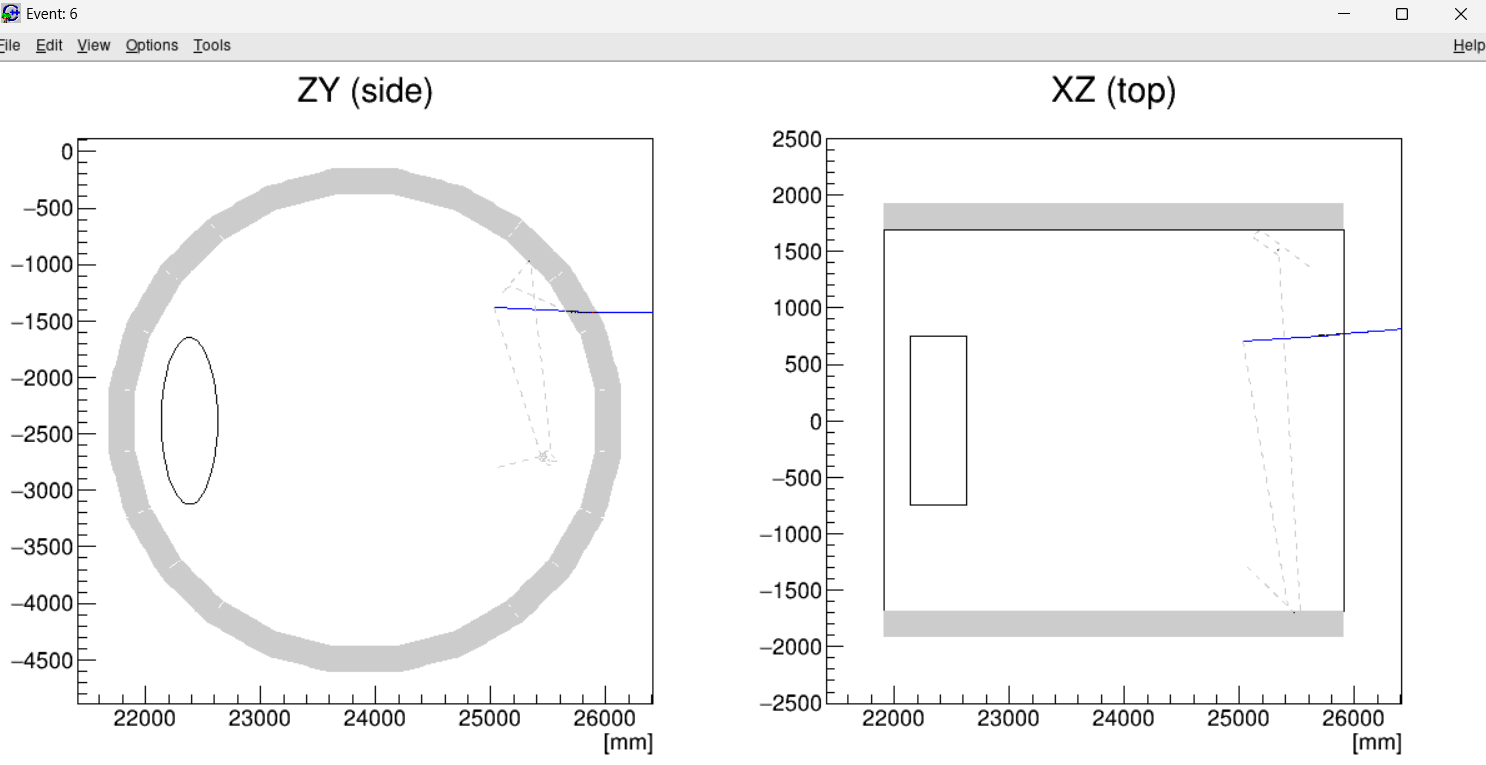

# event 26

/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


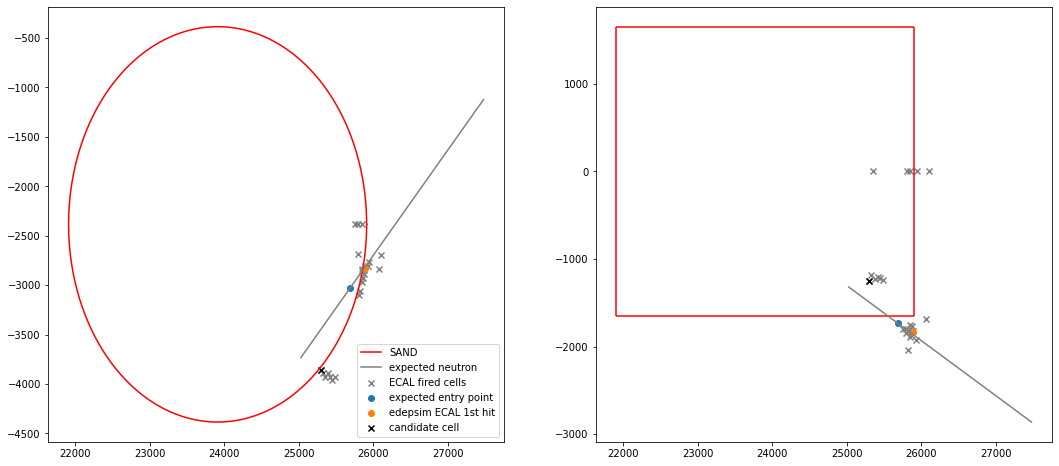

In [13]:
f26 = GetCandidateCell(26)

plotEvent(f26['test_event'], 
          f26['tests_event_primaries'],
          f26['test_event_fired_cells'], 
          f26['best_fired_cell'])

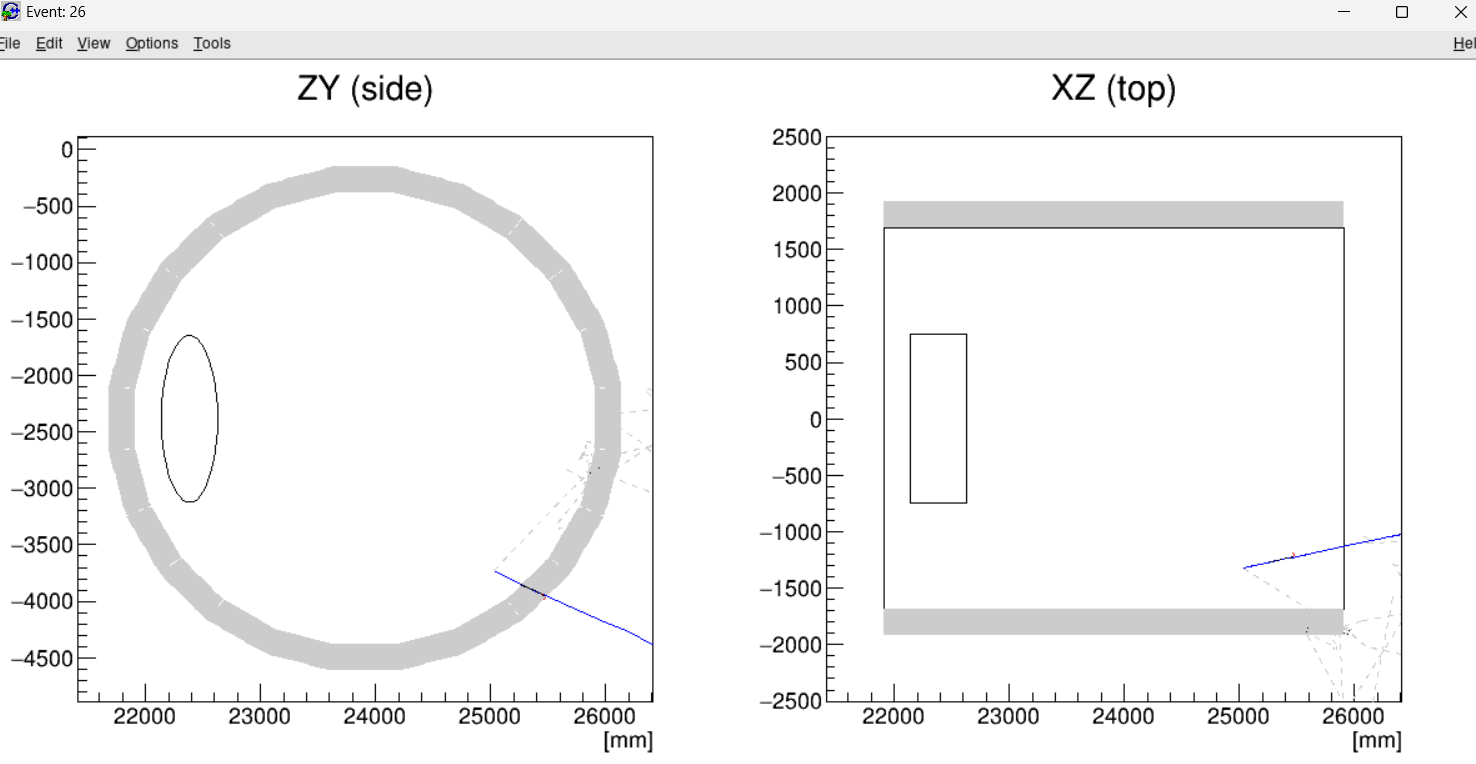

In [14]:
f26['test_event']

,,EventType,CCQEonHydrogen,Interaction_vtxX,Interaction_vtxY,Interaction_vtxZ,PrimaryStateHadronicSystemTotalKinE,ExpectedHadronSystP3fX,ExpectedHadronSystP3fY,ExpectedHadronSystP3fZ,ExpectedNeutronArrivalPositionECALfX,ExpectedNeutronArrivalPositionECALfY,ExpectedNeutronArrivalPositionECALfZ,dist_Vtx2ECAL,ExpectedHadronSystPtot,ExpectedNeutronE,ExpectedNeutronGamma,ExpectedNeutronBeta,ExpectedNeutronCrossingTimeECAL
FileName,EventId,,,,,,,,,,,,,,,,,,
events-in-SANDtracker.2.gtrac.root:gRooTracker:26,26,QES,1,-1.320644,-3.732753,25.027468,0.30424,-0.322022,0.545836,0.512486,-1735.436871,-3029.666541,25687.597212,1049.835106,815.031477,1243.808456,1.323813,0.655271,5.340464


# event 433

/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


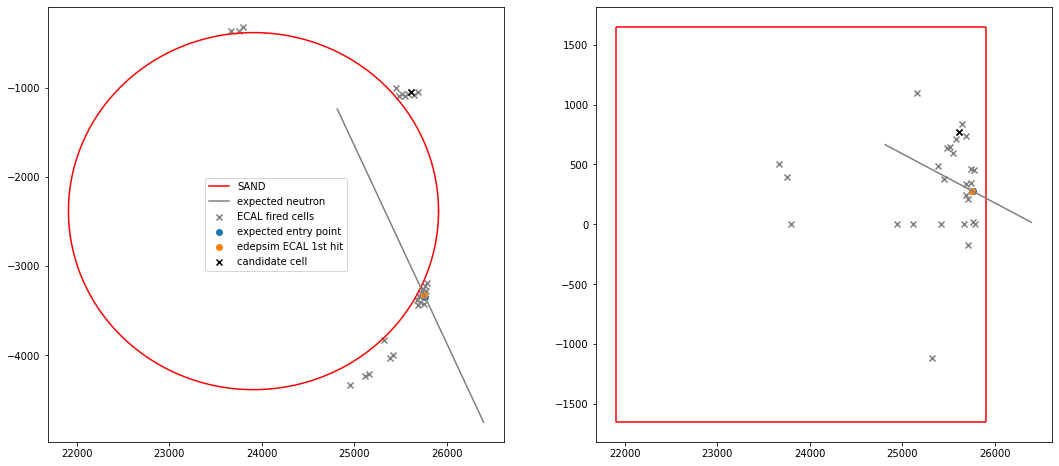

In [15]:
f433 = GetCandidateCell(433)

plotEvent(f433['test_event'], 
          f433['tests_event_primaries'],
          f433['test_event_fired_cells'], 
          f433['best_fired_cell'])

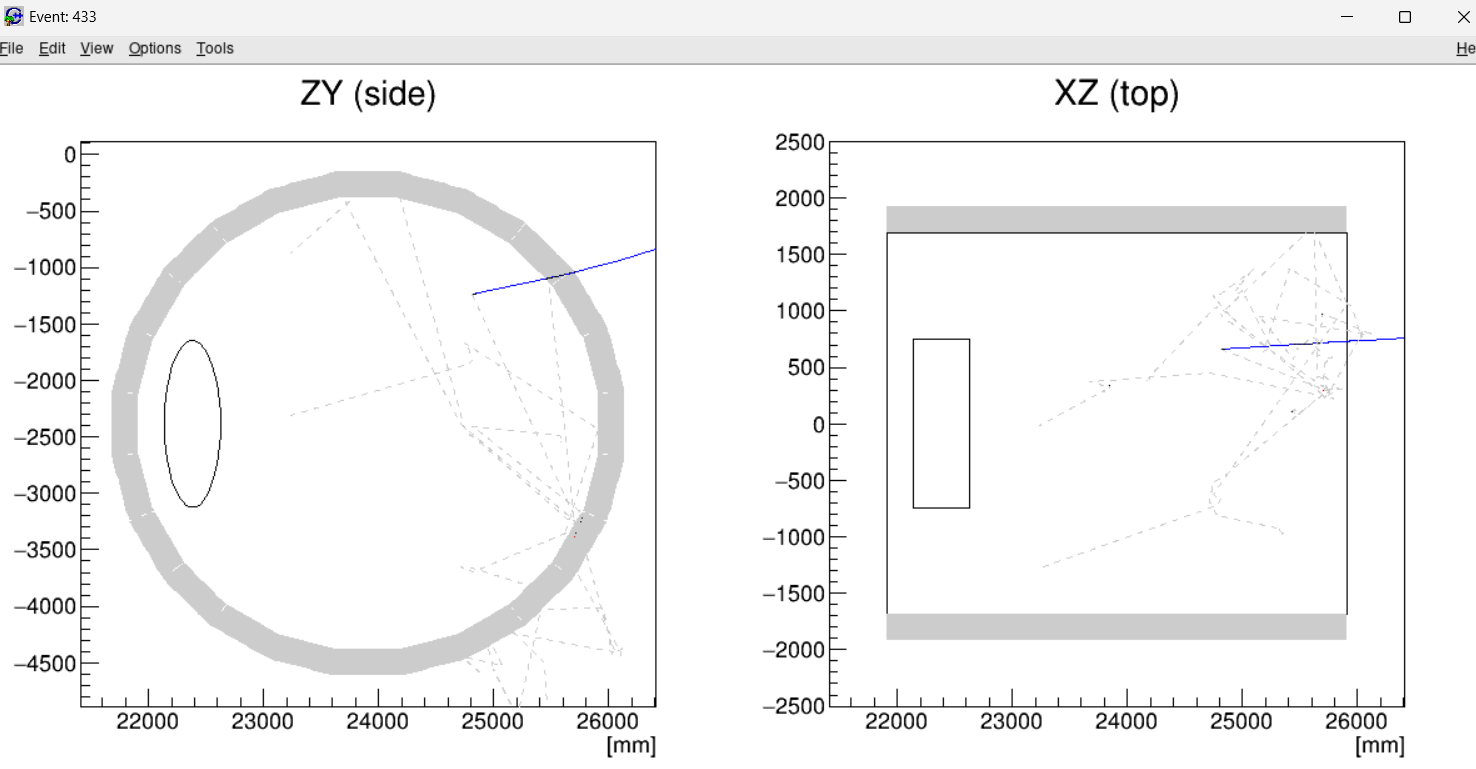

In [16]:
f433['test_event']

,,EventType,CCQEonHydrogen,Interaction_vtxX,Interaction_vtxY,Interaction_vtxZ,PrimaryStateHadronicSystemTotalKinE,ExpectedHadronSystP3fX,ExpectedHadronSystP3fY,ExpectedHadronSystP3fZ,ExpectedNeutronArrivalPositionECALfX,ExpectedNeutronArrivalPositionECALfY,ExpectedNeutronArrivalPositionECALfZ,dist_Vtx2ECAL,ExpectedHadronSystPtot,ExpectedNeutronE,ExpectedNeutronGamma,ExpectedNeutronBeta,ExpectedNeutronCrossingTimeECAL
FileName,EventId,,,,,,,,,,,,,,,,,,
events-in-SANDtracker.2.gtrac.root:gRooTracker:433,433,QES,1,0.665097,-1.241196,24.815954,0.278005,-0.128702,-0.696213,0.313727,276.236733,-3344.741539,25763.851154,2339.791957,774.40402,1217.573304,1.29589,0.636023,12.262627


In [29]:
f433['tests_event_primaries']

EventType  \
FileName                                           EventId             
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433           QES   
                                                   433           QES   

                                                            CCQEonHydrogen  \
FileName                                           EventId                   
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433                   1   
                                                   433                   1   

                                                            Interaction_vtxX  \
FileName                                           EventId                     
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433              0.665097   
                                                   433              0.665097   

                                                            Interaction_vtxY  \
FileName                                           EventId                     
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433             -1.241196   
                                                   433             -1.241196   

                                                            Interaction_vtxZ  \
FileName                                           EventId                     
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433             24.815954   
                                                   433             24.815954   

                                                            Interaction_vtxT  \
FileName                                           EventId                     
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433          7.762681e-09   
                                                   433          7.762681e-09   

                                                             PDG          Px  \
FileName                                           EventId                     
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433       -13  130.539417   
                                                   433      2112 -128.701586   

                                                                    Py  \
FileName                                           EventId               
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433      437.354517   
                                                   433     -696.212556   

                                                                     Pz  ...  \
FileName                                           EventId               ...   
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433      2301.375544  ...   
                                                   433       313.718816  ...   

                                                            PrimariesFirstHitECAL_y  \
FileName                                           EventId                            
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433                 -1102.947637   
                                                   433                 -3327.367169   

                                                            PrimariesFirstHitECAL_z  \
FileName                                           EventId                            
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433                 25457.139737   
                                                   433                 25753.411765   

                                                            PrimariesFirstHitECAL_t  \
FileName                                           EventId                            
events-in-SANDtracker.2.gtrac.root:gRooTracker:433 433                     3.193676   
                                                   433                    13.162853   

                                                            PrimariesEDepECAL  \
FileName                                           EventId                      
events-in-SANDtracker.2.g

In [26]:
f433['test_event_fired_cells'][(f433['test_event_fired_cells'].Fired_Cells_mod==16) & (f433['test_event_fired_cells'].Fired_Cells_mod==16)]

FileName  EventId  \
entry subentry                                                               
61    9         events-in-SANDtracker.2.gtrac.root:gRooTracker...      433   
      10        events-in-SANDtracker.2.gtrac.root:gRooTracker...      433   
      11        events-in-SANDtracker.2.gtrac.root:gRooTracker...      433   
      12        events-in-SANDtracker.2.gtrac.root:gRooTracker...      433   
      13        events-in-SANDtracker.2.gtrac.root:gRooTracker...      433   
      14        events-in-SANDtracker.2.gtrac.root:gRooTracker...      433   
      15        events-in-SANDtracker.2.gtrac.root:gRooTracker...      433   
      16        events-in-SANDtracker.2.gtrac.root:gRooTracker...      433   
      17        events-in-SANDtracker.2.gtrac.root:gRooTracker...      433   
      18        events-in-SANDtracker.2.gtrac.root:gRooTracker...      433   
      19        events-in-SANDtracker.2.gtrac.root:gRooTracker...      433   

                Fired_Cells_mod  Fired_Cells_id  Fired_Cells_x  Fired_Cells_y  \
entry subentry                                                                  
61    9                      16          216006  -2.348122e-13   -3376.572922   
      10                     16          216007  -2.348122e-13   -3338.258766   
      11                     16          216008  -2.348122e-13   -3299.944609   
      12                     16          216009  -2.348122e-13   -3261.630453   
      13                     16          216010  -2.348122e-13   -3223.316297   
      14                     16          216011  -2.348122e-13   -3185.002141   
      15                     16          216105  -2.348122e-13   -3437.305406   
      16                     16          216106  -2.348122e-13   -3398.154594   
      17                     16          216108  -2.348122e-13   -3319.852970   
      18                     16          216109  -2.348122e-13   -3280.702158   
      19                     16          216206  -2.348122e-13   -3419.736266   

                Fired_Cells_z  isCellComplete  Fired_Cells_tdc1  \
entry subentry                                                    
61    9          25672.163711               0          0.000000   
      10         25694.284399               1         28.550888   
      11         25716.405087               1         29.775491   
      12         25738.525776               1         26.649303   
      13         25760.646464               1         28.813461   
      14         25782.767153               0          0.000000   
      15         25687.906618               1         36.840850   
      16         25710.510350               1         26.079840   
      17         25755.717814               1         26.125561   
      18         25778.321546               1         29.233913   
      19         25748.856990               1         36.886772   

                Fired_Cells_tdc2    hit_reco_x   hit_reco_y    hit_reco_z  \
entry subentry                                                              
61    9                64.126600 -2.348122e-13 -3376.572922  25672.163711   
      10               31.373364  2.412372e+02 -3338.258766  25694.284399   
      11               27.786163 -1.700280e+02 -3299.944609  25716.405087   
      12               30.682861  3.447485e+02 -3261.630453  25738.525776   
      13               29.021881  1.781367e+01 -3223.316297  25760.646464   
      14               40.110057 -2.348122e-13 -3185.002141  25782.767153   
      15               40.735469  3.328734e+02 -3437.305406  25687.906618   
      16               28.528510  2.092881e+02 -3398.154594  25710.510350   
      17               29.404806  2.802773e+02 -3319.852970  25755.717814   
      18               34.524435  4.521813e+02 -3280.702158  25778.321546   
      19               42.339330  4.660306e+02 -3419.736266  25748.856990   

                hit_reco_t  space_time_distance2  space_time_distance2_abs  
entry subentry                       

# event 513
incomplete cell

/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


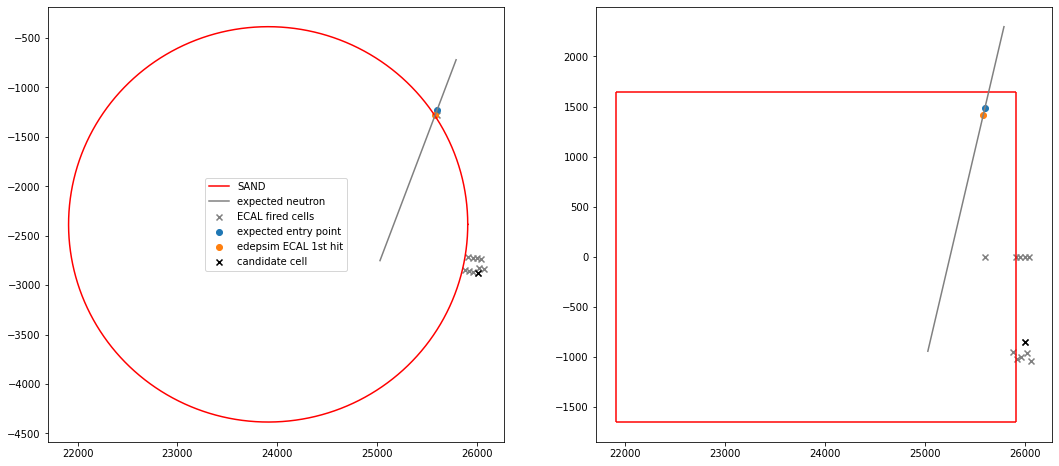

In [18]:
f513 = GetCandidateCell(513)

plotEvent(f513['test_event'], 
          f513['tests_event_primaries'],
          f513['test_event_fired_cells'], 
          f513['best_fired_cell'])

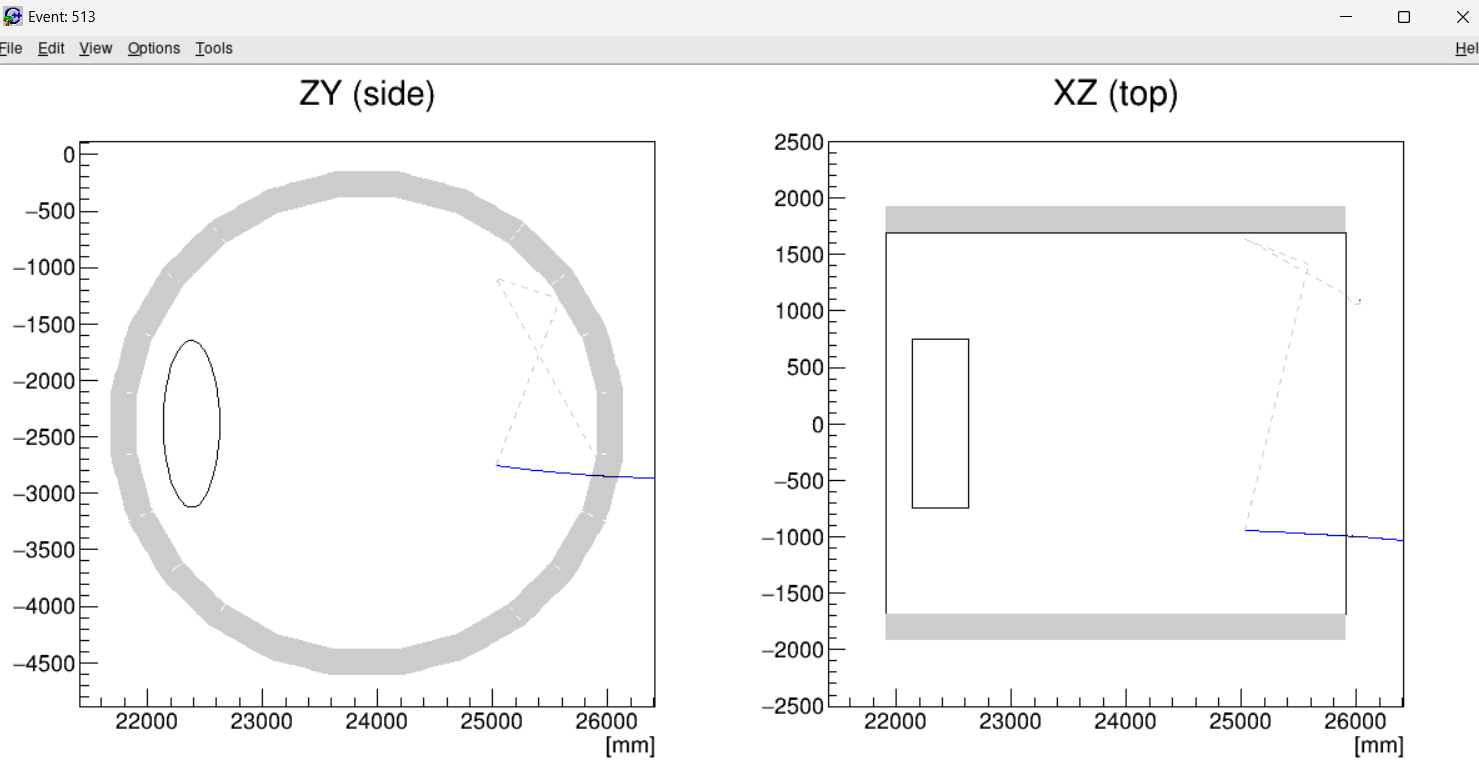

# event 666

/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


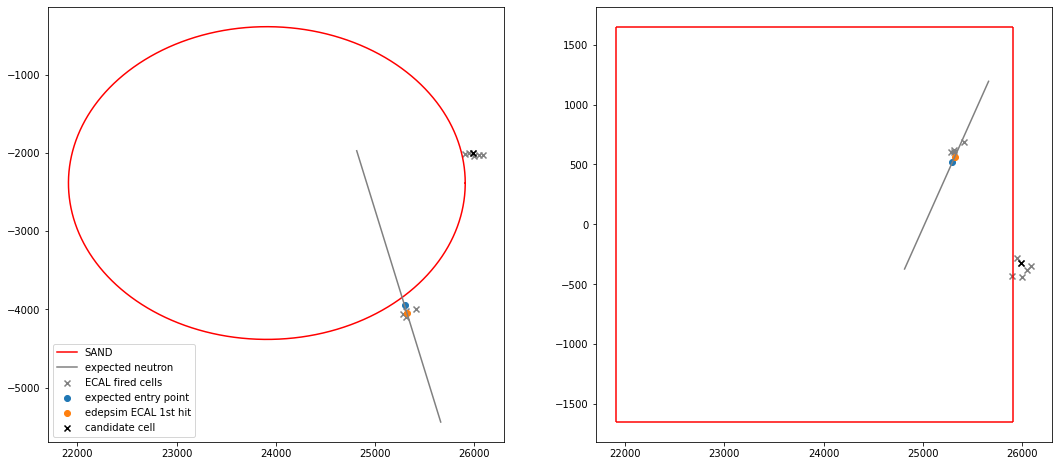

In [19]:
f666 = GetCandidateCell(666)

plotEvent(f666['test_event'], 
          f666['tests_event_primaries'],
          f666['test_event_fired_cells'], 
          f666['best_fired_cell'])

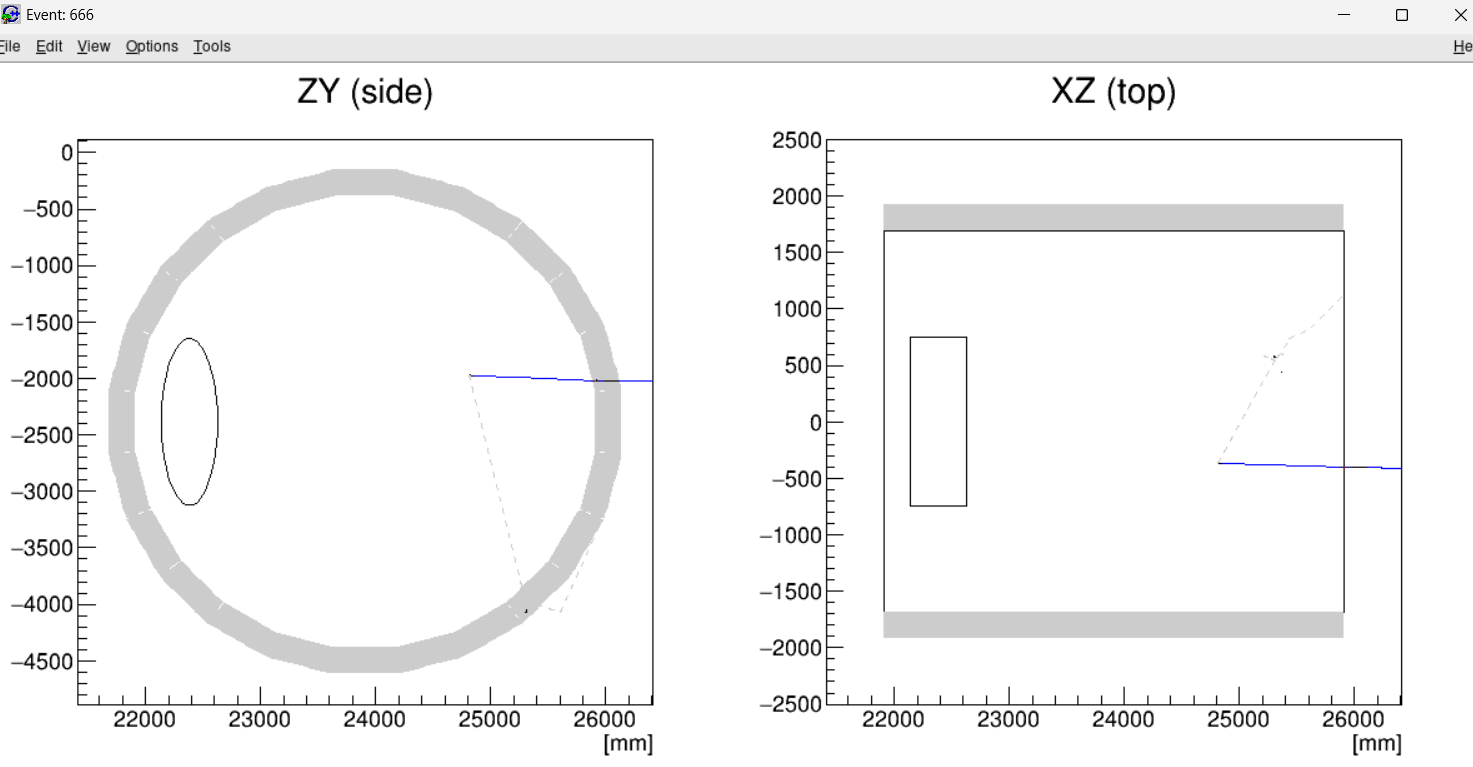

# event 809

/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/NEUTRINO/gianfrancoingratta/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


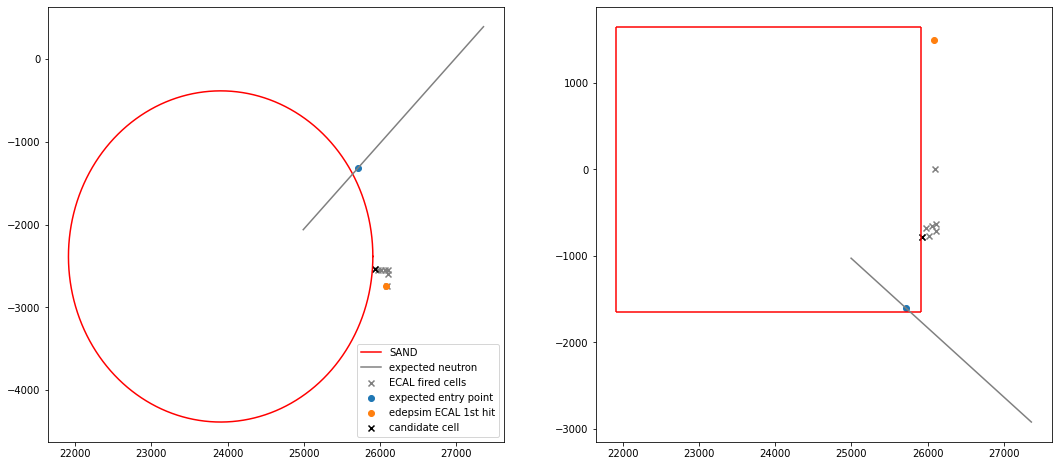

In [20]:
f809 = GetCandidateCell(809)

plotEvent(f809['test_event'], 
          f809['tests_event_primaries'],
          f809['test_event_fired_cells'], 
          f809['best_fired_cell'])

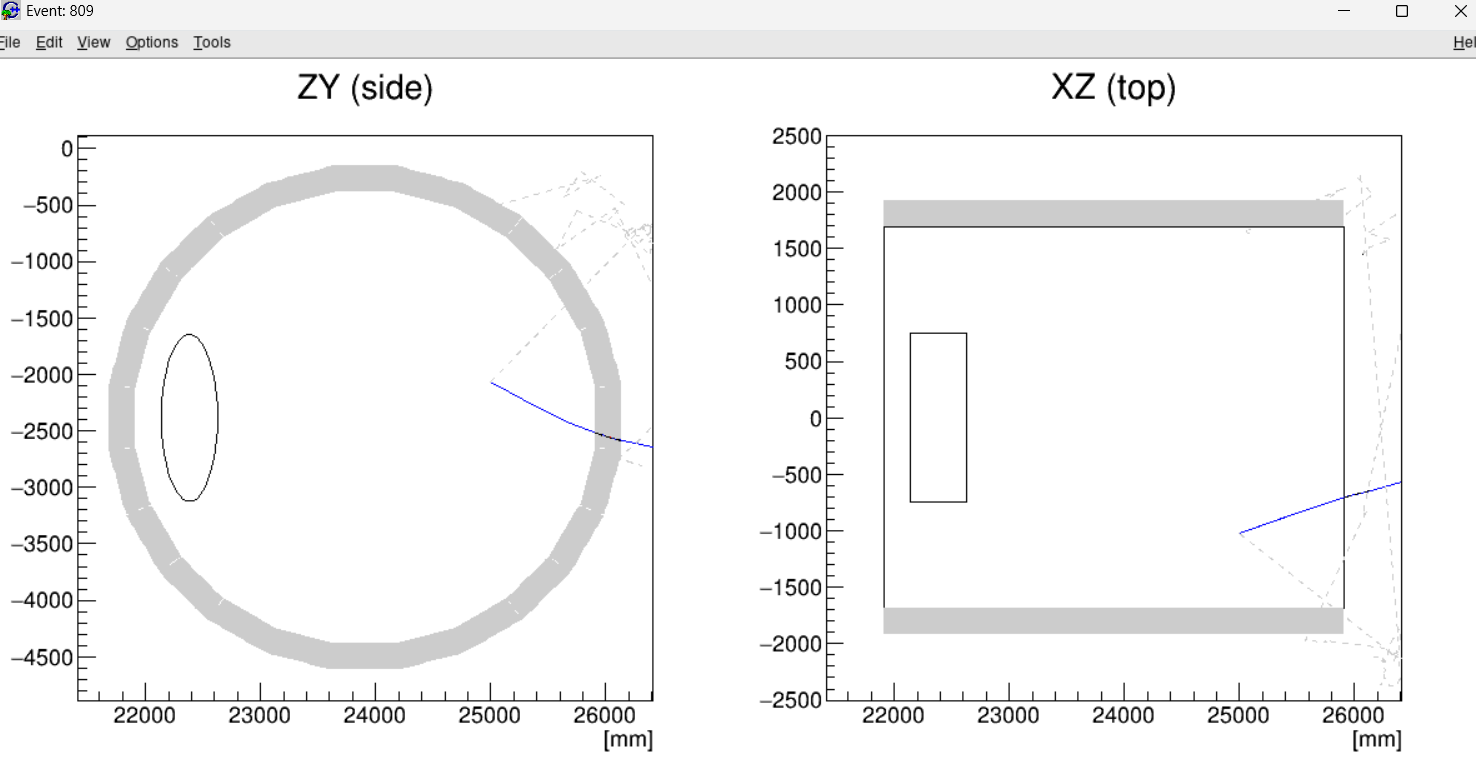

In [33]:
import math

# Constants (placeholders, replace with actual values if needed)
SAND_CENTER_X = 0.0
SAND_CENTER_Y = -2384.73
SAND_CENTER_Z = 23910.
SAND_INNER_VOL_X_LENGTH = 3380.0  # in mm
SAND_INNER_VOL_DIAMETER = 4000.0  # in mm
Module_angle = math.pi / 12.0  # 15 degrees per module
Module_0_starting_angle = (math.pi - Module_angle) * 0.5

def MasterToSAND(point):
    """
    Convert the point coordinates from master coordinates to SAND coordinates.
    """
    return [point[0] - SAND_CENTER_X, 
            point[1] - SAND_CENTER_Y, 
            point[2] - SAND_CENTER_Z]

def GetModuleIdFromPoint(point):
    """
    Given a point in the space, find the ECAL module that contains the point.

    Parameters:
    - units: String representing the unit ('m', 'cm', 'mm').
    - point: A list [x, y, z] representing the point's coordinates.

    Returns:
    - module: The module ID where the point lies.
    """

    # Convert point to SAND coordinates
    Point2SAND = MasterToSAND(point)

    print("coordinates to SAND : ", Point2SAND)

    # Check if the point is in one of the endcaps
    if Point2SAND[0] <= -SAND_INNER_VOL_X_LENGTH / 2.0:
        return 40
    elif Point2SAND[0] >= SAND_INNER_VOL_X_LENGTH / 2.0:
        return 30
    else:
        angle = math.atan2(Point2SAND[1], Point2SAND[2])
        # print("angle to z axis", angle * 180/math.pi)
        # Rotate coordinates with respect to the Module 0 starting angle
        point_z = Point2SAND[2] * math.cos(Module_0_starting_angle) + Point2SAND[1] * math.sin(Module_0_starting_angle)
        point_y = - Point2SAND[2] * math.sin(Module_0_starting_angle) + Point2SAND[1] * math.cos(Module_0_starting_angle)

        print(point_y, point_z)

        # Calculate the angle in the YZ plane and adjust to [0, 2π] range
        angle = math.atan2(point_y, point_z)
        # print("angle to z ECAL", angle * 180/math.pi)
        if point_y < 0:
            angle += 2 * math.pi
        print(angle)
        # Determine which module the point falls into
        module = int(angle / Module_angle)
        return module



In [34]:
# point = [
#     SAND_CENTER_X, 
#     SAND_CENTER_Y + SAND_INNER_VOL_DIAMETER/2 * np.sin(Module_angle/2), 
#     SAND_CENTER_Z + SAND_INNER_VOL_DIAMETER/2 * np.cos(Module_angle/2)
# ]
point = [-1580.72, -2394.04, 26003.9]

# Calcola il modulo
module_id = GetModuleIdFromPoint(point)
print("The point lies in module:", module_id)

coordinates to SAND :  [-1580.72, -9.309999999999945, 2093.9000000000015]
-2077.201594080192 264.07844223017634
4.8388424549564375
The point lies in module: 18


In [64]:
math.sin(Module_0_starting_angle)

0.9914448613738104

In [103]:
c = []
for i, row in fired_cells[['Fired_Cells_x','Fired_Cells_y','Fired_Cells_z','Fired_Cells_mod']].iterrows():
    point = [row.Fired_Cells_x, row.Fired_Cells_y, row.Fired_Cells_z]
    c.append(GetModuleIdFromPoint(point))
    # print(f'id : {row.Fired_Cells_mod}, calculated : {GetModuleIdFromPoint(point)}')

In [107]:
(fired_cells.Fired_Cells_mod.values - np.array(c)).sum()

0